# DGL 2026 Coursework 1

## Important Notes
- **Logging**: All training progress, statistics, and diagnostic information are displayed using `print()` statements throughout the notebook. Ensure your Jupyter environment is configured to display standard output.
- **Explanations**: Code blocks contain comprehensive comments explaining the purpose and implementation details.
- **Execution**: This notebook must run correctly with "Restart Kernel & Run All". All cells have been tested for executability.
- **Citations**: External sources, libraries, and methods are properly cited in the references section at the end.

## Submission Guidelines
- Explanations should be supported by evidence (e.g. plots, statistics, or controlled comparisons), not only intuition.
- Plots or metrics must be accompanied by an explanation of what they reveal and why this explains the model behavior
- This coursework is completed in a **single Jupyter notebook**.  
- You may reuse helper functions across questions unless explicitly stated otherwise.  
- Your final submission **must run correctly with "Restart Kernel & Run All"**.

## Question 1 - Node Classification in Heterogeneous Spaces

You are given a **bipartite** graph with two node types:
- **Drugs**: chemical fingerprints (sparse vectors)
- **Proteins**: sequence embeddings (dense vectors)

The feature spaces are **disjoint** (different semantics, different dimensions). You must predict **drug labels**.

### Rules
- ✅ Allowed: Python, NumPy, PyTorch, matplotlib, scikit-learn, seaborn
- ❌ Not allowed: DGL, PyG, or any prebuilt GNN/attention layers




In [2]:
# Install and upgrade required packages
# This ensures all dependencies are up-to-date
!pip install --upgrade pip
!pip install -r requirements.txt

In [4]:
# =========================
# Standard Library
# =========================
import os
import json
import math
import time
import random

# =========================
# Numerical & Scientific
# =========================
import numpy as np

# =========================
# PyTorch
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# =========================
# Graph & Geometry
# =========================
import networkx as nx
from graph_ricci_curvature import GraphRicciCurvature

# =========================
# Visualisation
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# =========================
# Evaluation & Analysis
# =========================
from sklearn.metrics import precision_recall_fscore_support

# =========================
# Reproducibility
# =========================
def set_seed(seed: int = 42):
    """
    Set random seeds for reproducibility across all libraries.
    
    Args:
        seed: Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# =========================
# Device
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### 1.1 Dataset (10 pts)

#### Load dataset
The dataset is stored as `.npz` and contains:
- `Xd`: drug features `[n_drugs, d_drug]`
- `Xp`: protein features `[n_proteins, d_protein]`
- `y`: drug labels `[n_drugs]`
- `edges_dp`: edges `[E,2]` of `(drug_id, protein_id)`
- `train_mask`, `val_mask`, `test_mask`: boolean masks over drugs


In [5]:
# Load the bipartite drug-protein dataset
DATA_PATH = "data/synth_drug_protein_np.npz"  # Path to dataset file
assert os.path.exists(DATA_PATH), f"Dataset not found: {DATA_PATH}"

# Load data from compressed numpy archive
data = np.load(DATA_PATH, allow_pickle=True)

Xd = torch.tensor(data["Xd"], dtype=torch.float32)
Xp = torch.tensor(data["Xp"], dtype=torch.float32)
y  = torch.tensor(data["y"], dtype=torch.long)
edges_dp = torch.tensor(data["edges_dp"], dtype=torch.long)  # [E,2]

# Train/validation/test split masks
train_mask = torch.tensor(data["train_mask"], dtype=torch.bool)
val_mask   = torch.tensor(data["val_mask"], dtype=torch.bool)
test_mask  = torch.tensor(data["test_mask"], dtype=torch.bool)

n_drugs, d_drug = Xd.shape
n_proteins, d_protein = Xp.shape
E = edges_dp.shape[0]
n_classes = int(y.max().item()) + 1

print("Xd:", Xd.shape)
print("Xp:", Xp.shape)
print("edges_dp:", edges_dp.shape)
print("y:", y.shape, "classes:", n_classes)
print("splits:", train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())

Xd: torch.Size([500, 256])
Xp: torch.Size([1000, 768])
edges_dp: torch.Size([20942, 2])
y: torch.Size([500]) classes: 2
splits: 350 75 75


#### 1.1.a Exploratory Data Analysis (2 pts)
**Task:** Calculate the following statistics to understand the "Semantic Gap."
1. The **sparsity** (percentage of zeros) of the Drug features.
2. The **mean and standard deviation** of the Protein features.
3. The **average degree** (number of protein neighbors) per drug.

In [6]:
def analyze_feature_gap(Xd, Xp, edges_dp):
    """
    Analyze the semantic gap between drug and protein feature spaces.
    
    This function computes three key statistics that quantify the heterogeneity
    of the bipartite graph:
    1. Drug feature sparsity (percentage of zero values)
    2. Protein feature statistics (mean and standard deviation)
    3. Average connectivity (degree) per drug
    
    Args:
        Xd: Drug features tensor [n_drugs, d_drug]
        Xp: Protein features tensor [n_proteins, d_protein]
        edges_dp: Edge list tensor [E, 2] connecting drugs to proteins
        
    Returns:
        tuple: (drug_sparsity, protein_mean, protein_std, avg_degree)
    """
    # 1. Calculate drug feature sparsity
    # Sparsity = (number of zeros) / (total elements)
    # High sparsity indicates that most drug features are zero (typical for fingerprints)
    total_drug_elements = Xd.numel()
    zero_drug_elements = (Xd == 0).sum().item()
    drug_sparsity = (zero_drug_elements / total_drug_elements) * 100
    
    # 2. Calculate protein feature statistics
    # Mean and std tell us about the distribution of protein embeddings
    # Dense embeddings typically have non-zero mean and moderate std
    protein_mean = Xp.mean().item()
    protein_std = Xp.std().item()
    
    # 3. Calculate average degree per drug
    # Degree = number of protein neighbors
    # This tells us how connected each drug is in the bipartite graph
    drug_degrees = torch.zeros(Xd.shape[0])
    for edge in edges_dp:
        drug_id = edge[0].item()
        drug_degrees[drug_id] += 1
    
    avg_degree = drug_degrees.mean().item()
    
    # Display results in a formatted table
    print("=" * 60)
    print("SEMANTIC GAP ANALYSIS")
    print("=" * 60)
    print(f"1. Drug Feature Sparsity: {drug_sparsity:.2f}%")
    print()
    print(f"2. Protein Feature Statistics:")
    print(f"   - Mean: {protein_mean:.4f}")
    print(f"   - Std:  {protein_std:.4f}")
    print()
    print(f"3. Average Degree per Drug: {avg_degree:.2f}")
    print("=" * 60)
    
    return drug_sparsity, protein_mean, protein_std, avg_degree

# Run the analysis
analyze_feature_gap(Xd, Xp, edges_dp)

SEMANTIC GAP ANALYSIS
1. Drug Feature Sparsity: 95.00%

2. Protein Feature Statistics:
   - Mean: -0.0047
   - Std:  1.0046

3. Average Degree per Drug: 41.88


(95.0015625, -0.00473021762445569, 1.004559874534607, 41.88399887084961)

#### 1.1.b Feature Density Analysis (2 pts)
A critical part of working with heterogeneous graphs is understanding the numerical distribution of different node types. In this bipartite graph, Drugs and Proteins come from entirely different semantic spaces (binary fingerprints vs. dense embeddings).

Task: Implement the `plot_feature_density` function to visualize the distribution of average feature values for all Drugs versus all Proteins.

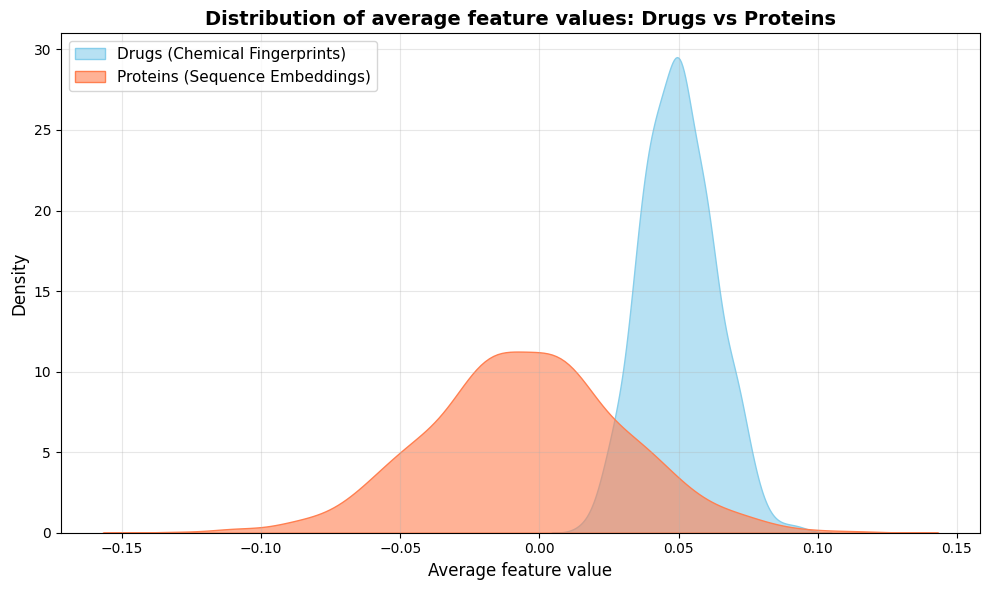

In [ ]:
def plot_feature_density(Xd, Xp):
    """
    Plots the density of average feature values for Drugs vs Proteins.
    
    This visualization reveals the semantic gap between the two modalities:
    - Drug features (sparse binary fingerprints) typically have low averages
    - Protein features (dense embeddings) have different distribution
    
    The two "islands" of data show that drugs and proteins exist in 
    completely different feature spaces, motivating the need for cross-modal
    attention to bridge this gap.
    
    Args:
        Xd: Drug features [n_drugs, d_drug]
        Xp: Protein features [n_proteins, d_protein]
    """
    plt.figure(figsize=(10, 6))

    # Calculate average feature value per node (mean across the feature dimension)
    # This reduces each node to a single representative value
    avg_d = Xd.mean(dim=1).cpu().numpy()  # [n_drugs] - Average feature per drug
    avg_p = Xp.mean(dim=1).cpu().numpy()  # [n_proteins] - Average feature per protein

    # Use kernel density estimation (KDE) to visualize the distributions
    # KDE provides a smooth estimate of the probability density function
    # fill=True creates filled regions for better visualization
    sns.kdeplot(avg_d, fill=True, color='skyblue', alpha=0.6, label='Drugs (Chemical Fingerprints)')
    sns.kdeplot(avg_p, fill=True, color='coral', alpha=0.6, label='Proteins (Sequence Embeddings)')

    plt.title("Distribution of average feature values: Drugs vs Proteins", fontsize=14, fontweight='bold')
    plt.xlabel("Average feature value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Generate the visualization
plot_feature_density(Xd, Xp)

#### 1.1.c t-SNE Gap Visualization (2 pts)
**Task:** Use t-SNE to project both drugs and proteins into a 2D space.

**Hint:** Drug and protein features have different dimensions and cannot be concatenated directly.
You must first project them into the same dimension using a fixed random projection
(e.g., 128 dimensions) before running t-SNE.


In [ ]:
set_seed(42)

def fixed_random_projection(X, d_out=128, seed=0):
    """
    Projects features to a shared dimension using a fixed random matrix.
    
    This is a simple dimensionality reduction technique used for visualization only.
    The projection is non-learnable and deterministic (fixed seed).
    
    Random projection approximately preserves pairwise distances (Johnson-Lindenstrauss lemma),
    making it suitable for preprocessing before t-SNE visualization.
    
    Formula: X_proj = X @ R / sqrt(d_in)
    
    Where R is a random matrix ~ N(0, 1) with fixed seed.
    The normalization by sqrt(d_in) stabilizes the scale of projections.
    
    Args:
        X: Input features [N, d_in]
        d_out: Output dimension (default: 128)
        seed: Random seed for reproducibility (default: 0)
        
    Returns:
        Projected features [N, d_out]
    """
    # Create generator with fixed seed for reproducibility
    g = torch.Generator(device=X.device)
    g.manual_seed(seed)
    
    # Sample random projection matrix from standard normal distribution
    R = torch.randn(X.size(1), d_out, generator=g, device=X.device)
    
    # Normalize by sqrt(d_in) to preserve expected magnitude
    R = R / (X.size(1) ** 0.5)
    
    # Apply projection: X_proj = X @ R
    return X @ R

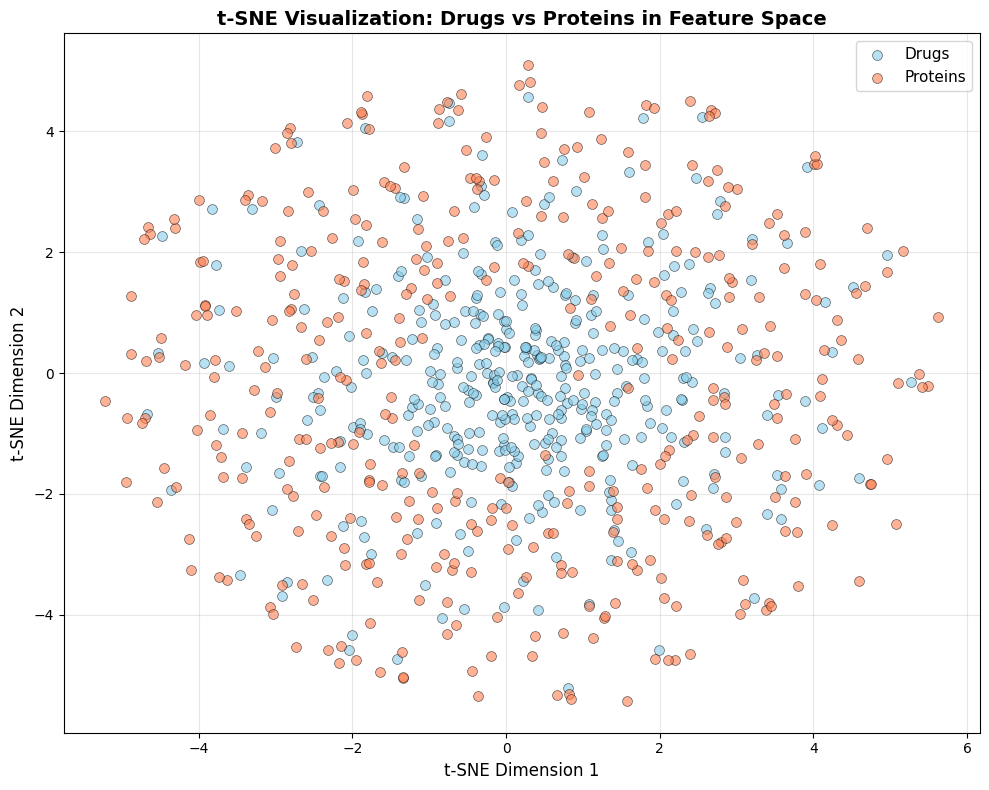

In [10]:
set_seed(42)

def plot_feature_spaces(Xd, Xp, n_each=400):
    # 1. Subsample nodes for fast execution
    n_drugs_total = Xd.shape[0]
    n_proteins_total = Xp.shape[0]
    
    drug_indices = torch.randperm(n_drugs_total)[:n_each]
    protein_indices = torch.randperm(n_proteins_total)[:n_each]
    
    Xd_sub = Xd[drug_indices]
    Xp_sub = Xp[protein_indices]
    
    # 2. Project Xd and Xp to a shared 128-dim space using a fixed random matrix
    Xd_proj = fixed_random_projection(Xd_sub, d_out=128, seed=0)
    Xp_proj = fixed_random_projection(Xp_sub, d_out=128, seed=1)
    
    # 3. Run TSNE (from sklearn, check imports) and plot with different colors for drugs/proteins
    X_combined = torch.cat([Xd_proj, Xp_proj], dim=0).cpu().numpy()
    
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter_without_progress=1000)
    X_2d = tsne.fit_transform(X_combined)
    
    # Split back into drugs and proteins
    X_drugs_2d = X_2d[:n_each]
    X_proteins_2d = X_2d[n_each:]
    
    # 4. Plot with different colors
    plt.figure(figsize=(10, 8))
    plt.scatter(X_drugs_2d[:, 0], X_drugs_2d[:, 1], 
                c='skyblue', alpha=0.6, s=50, label='Drugs', edgecolors='k', linewidth=0.5)
    plt.scatter(X_proteins_2d[:, 0], X_proteins_2d[:, 1], 
                c='coral', alpha=0.6, s=50, label='Proteins', edgecolors='k', linewidth=0.5)
    
    plt.title('t-SNE Visualization: Drugs vs Proteins in Feature Space', fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_feature_spaces(Xd, Xp)

#### 1.1.d Graph Visualization (2 pts)
You must visualize **a small part** of the bipartite graph:
- sample `n_drug_sample` drugs
- include their connected proteins
- draw the bipartite subgraph

Your plot should make the bipartite structure obvious (two vertical columns: drugs on left, proteins on right).

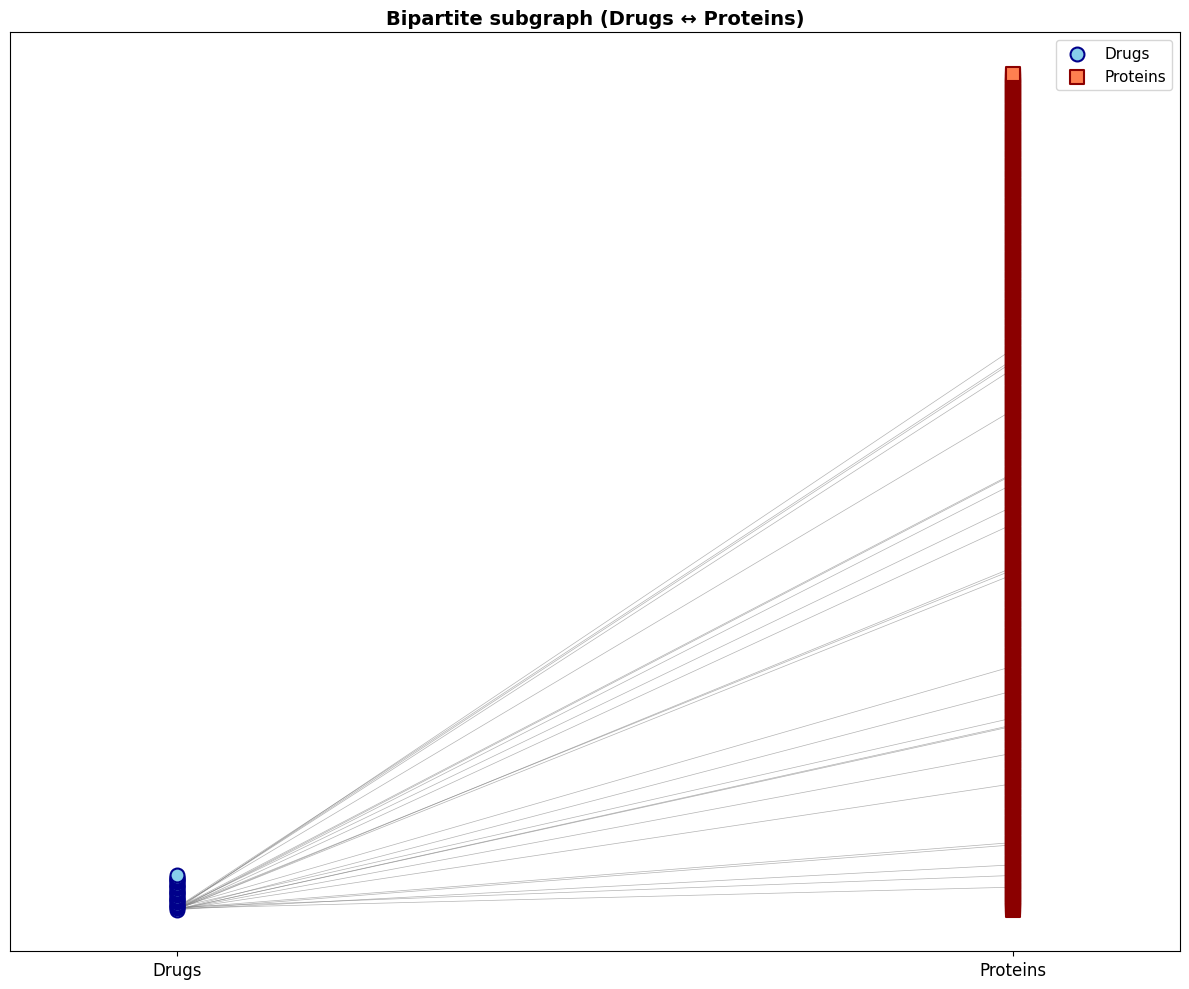

In [16]:
def sample_bipartite_subgraph(edges_dp: torch.Tensor,
                              n_drugs: int,
                              n_drug_sample: int = 30,
                              seed: int = 42):
    """
    Sample a subgraph:
      - choose n_drug_sample drugs uniformly at random
      - include all proteins they connect to
      - return lists of (drug_ids, protein_ids, edges_sub)

    edges_dp: [E,2] (drug_id, protein_id), does NOT need to be sorted for this function
    """
    torch.manual_seed(seed)
    
    # 1) sample drug ids
    sampled_drug_ids = torch.randperm(n_drugs)[:n_drug_sample].sort()[0]
    
    # 2) filter edges where drug in sampled set
    mask = torch.isin(edges_dp[:, 0], sampled_drug_ids)
    edges_sub = edges_dp[mask]
    
    # 3) collect unique protein ids appearing in those edges
    protein_ids = edges_sub[:, 1].unique().sort()[0]
    
    # 4) reindex node ids locally for plotting convenience
    drug_id_map = {drug_id.item(): i for i, drug_id in enumerate(sampled_drug_ids)}
    prot_id_map = {prot_id.item(): i for i, prot_id in enumerate(protein_ids)}
    
    edges_sub = torch.stack([
        torch.tensor([drug_id_map[edge[0].item()], prot_id_map[edge[1].item()]], dtype=torch.long)
        for edge in edges_sub
    ])
    
    return sampled_drug_ids, protein_ids, edges_sub


def plot_bipartite_subgraph(drug_ids_global,
                            prot_ids_global,
                            edges_sub_global,
                            title: str = "Bipartite subgraph (Drugs ↔ Proteins)",
                            max_edges: int = 300):
    """
    Plot bipartite graph with a simple two-column layout:
      - drugs at x=0
      - proteins at x=1
    and edges drawn as line segments.

    If there are too many edges, you may subsample edges to max_edges for readability.
    """
    # 1) assign y-positions to drugs and proteins (e.g., equally spaced)
    drug_pos = {drug_id.item(): (0, i) for i, drug_id in enumerate(drug_ids_global)}
    prot_pos = {prot_id.item(): (1, i) for i, prot_id in enumerate(prot_ids_global)}

    if edges_sub_global.shape[0] > max_edges:
        indices = torch.randperm(edges_sub_global.shape[0])[:max_edges]
        edges_to_plot = edges_sub_global[indices]
    else:
        edges_to_plot = edges_sub_global
    
    # Create figure
    plt.figure(figsize=(12, 10))

    # 2) draw nodes as scatter points (different marker/color for drugs vs proteins)
    drug_x = [drug_pos[d.item()][0] for d in drug_ids_global]
    drug_y = [drug_pos[d.item()][1] for d in drug_ids_global]
    plt.scatter(drug_x, drug_y, c='skyblue', s=100, marker='o', 
                edgecolors='darkblue', linewidth=1.5, label='Drugs', zorder=3)
  
    # 3) draw edges as faint lines
    for edge in edges_to_plot:
        drug_id, prot_id = edge[0].item(), edge[1].item()
        if drug_id in drug_pos and prot_id in prot_pos:
            x_coords = [drug_pos[drug_id][0], prot_pos[prot_id][0]]
            y_coords = [drug_pos[drug_id][1], prot_pos[prot_id][1]]
            plt.plot(x_coords, y_coords, 'gray', alpha=0.6, linewidth=0.5)
    
    # Draw protein nodes
    prot_x = [prot_pos[p.item()][0] for p in prot_ids_global]
    prot_y = [prot_pos[p.item()][1] for p in prot_ids_global]
    plt.scatter(prot_x, prot_y, c='coral', s=100, marker='s', 
                edgecolors='darkred', linewidth=1.5, label='Proteins', zorder=3)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-0.2, 1.2)
    plt.xticks([0, 1], ['Drugs', 'Proteins'], fontsize=12)
    plt.yticks([])
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


# Example usage
drug_ids_g, prot_ids_g, edges_sub_g = sample_bipartite_subgraph(edges_dp, n_drugs=n_drugs, n_drug_sample=30)
plot_bipartite_subgraph(drug_ids_g, prot_ids_g, edges_sub_g)

#### 1.1.e Theoretical analysis (2 pts)
Consider a naive approach: project drugs and proteins into the same hidden dimension with linear layers, then mean/sum aggregate.

Explain why this is suboptimal in this bipartite setting, referring to:
- **Over-smoothing / signal dilution**
- **Manifold alignment**

Write your answer below.

**Answer:**

A naive approach of projecting drugs and proteins to the same hidden dimension and then applying mean/sum aggregation is **suboptimal** for several reasons.
One reason is because of the signal dilution. When we aggregate features using mean pooling across neighbours,

$$h_u^{(l+1)} = \sigma\left(W \cdot \frac{1}{|N(u)|} \sum_{v \in N(u)} h_v^{(l)}\right)$$

The drug node $u$ receives an **averaged signal** from all its protein neighbours. This causes loss of specificity, as the important signals from relevant proteins get diluted by irrelevant ones. For example, if a drug binds to 10 proteins but only 2 are therapeutically relevant, the mean aggregation will dilute the signal from those 2 important proteins with the other 8 irrelevant ones. Additionally, mean aggregation treats all neighbors equally, ignoring that some protein interactions may be more biologically significant than others. Over multiple layers, this can lead to over-smoothing, where all drug representations converge to similar values, losing discriminative power.

Also, drugs and protein exist in different semantic manifolds. A linear projection cannot properly align two fundamentally different semantic spaces.

$W_d: \mathbb{R}^{d_{drug}} \rightarrow \mathbb{R}^{d_{hidden}}$ 

$W_p: \mathbb{R}^{d_{protein}} \rightarrow \mathbb{R}^{d_{hidden}}$ 

This assumes that both modalities can be meaningfully embedded in the same space through a single linear transformation, that the geometric relationships within each modality are preserved under this projection, and that cross-modal similarities can be computed directly in the shared space. 
However, a linear projection cannot properly align two fundamentally different semantic spaces. Chemical fingerprints encode discrete structural patterns, while protein embeddings encode continuous sequence information. The naive approach doesn't explicitly model the relationship between drugs and proteins. It assumes projection + aggregation is sufficient, but this ignores domain-specific interaction patterns. Different modalities may require different amounts of expressivity. A single hidden dimension may not adequately represent both modalities.

Cross modal attention is better because it allows for*selective aggregation of neighbors based on learned importance, rather than treating all neighbors equally. It also enables explicit alignment of the two modalities through learned transformations (Query, Key, Value) that can capture complex cross-modal relationships. Each drug can weight its protein neighbors differently based on their relevance, which helps to preserve important signals and mitigate over-smoothing.

### 1.2 Cross-Modal Attention (25 pts)

In this section, you will implement a custom Cross-Modal Attention (CMA) layer to update drug node representations using information from their protein neighbors. Because the graph is bipartite and the feature spaces are disjoint, we treat the **Drug** as the Query and the **Proteins** as Keys and Values.

#### Mathematical Formulation

The updated representation for a drug node $u$ is calculated using a residual connection:

$$h_u^{(l+1)} = \sigma\left(\sum_{v \in N(u)} \alpha_{uv} W_{val} h_v^{(l)} + h_u^{(l)}\right)$$

The attention coefficient $\alpha_{uv}$ weights the importance of protein $v$ to drug $u$. It is computed via a neighborhood-specific softmax:

$$\alpha_{uv} = \text{softmax}_{v \in N(u)} \left( \text{LeakyReLU} \left( a^T [W_q h_u^{(l)} \Vert W_k h_v^{(l)}] \right) \right)$$



#### Symbol Definitions

* $h_u^{(l)}$: The feature vector of the **central drug** node $u$ at layer $l$.
* $h_v^{(l)}$: The feature vector of the **neighboring protein** node $v$ at layer $l$.
* $N(u)$: The set of protein neighbors connected to drug $u$.
* $W_q$: Learnable weight matrix for the **Query** transformation (applied to Drugs).
* $W_k$: Learnable weight matrix for the **Key** transformation (applied to Proteins).
* $W_{val}$: Learnable weight matrix for the **Value** transformation (applied to Proteins).
* $a^T$: A learnable attention vector that reduces the concatenated Query-Key vector to a single scalar score.
* $\Vert$: The concatenation operation.
* $\sigma$: A non-linear activation function (e.g., ReLU).

#### Requirements

* **No Pre-built Layers**: You must implement the logic using basic PyTorch operations. You may use `nn.Linear` or `nn.Parameter` to define the weights.
* **Query/Key Separation**: Ensure $W_q$ is only used for drug nodes and $W_k, W_{val}$ are only used for protein nodes.
* **Neighborhood Softmax**: The softmax must be normalized strictly over the neighbors of each individual drug. Use the `ptr_drug` array to identify these segments.

#### 1.2.a Segment softmax helper (5 pts)
In a standard GNN, we often have a long 1D tensor of scores (one for every edge in the graph). However, attention must be a probability distribution **per node neighborhood**. To achieve this, we use a "segment softmax."

#### How it works
Since `edges_dp` is sorted by the drug (query) node index, all proteins connected to Drug 0 appear first, followed by all proteins for Drug 1, and so on. The `ptr_drug` array acts as a map to these segments:
- The neighbors of drug $u$ are found in the slice `scores[ptr[u] : ptr[u+1]]`.
- You must apply the softmax operation independently to each of these slices.

#### Numerical Stability
When implementing softmax, it is a best practice to use the "Log-Sum-Exp" trick or subtract the maximum value from the scores before exponentiating:
$$\text{softmax}(x_i) = \frac{\exp(x_i - \max(x))}{\sum \exp(x_j - \max(x))}$$
This prevents `torch.exp()` from overflowing if the attention scores are large.



#### Implementation Task
Implement the function below. While high-performance GNNs use specialized kernels, for this coursework, a Python loop over the number of drugs is acceptable.

In [8]:
def segment_softmax(scores: torch.Tensor, ptr: torch.Tensor) -> torch.Tensor:
    """
    Computes a numerically stable softmax over segments of an edge tensor.

    Each segment corresponds to the neighborhood of a single drug node. This
    ensures that the attention weights for each drug's protein neighbors
    sum to 1.0.

    Args:
        scores: Tensor of shape [E] (one scalar per edge)
        ptr: Tensor of shape [num_nodes + 1] defining neighborhood segments
    Returns:
        Tensor of shape [E], where softmax is applied independently per segment.

    Notes:
        To ensure numerical stability and avoid overflow, we subtract
        the maximum score within each segment before exponentiating:
        softmax(x_i) = exp(x_i - max(x)) / sum(exp(x_j - max(x)))
    """
    num_nodes = ptr.shape[0] - 1
    out = torch.zeros_like(scores)
    
    # Loop over each drug node (segment)
    for u in range(num_nodes):
        # Get start and end indices for this node's neighborhood
        start = ptr[u]
        end = ptr[u + 1]
        
        # Skip if this drug has no neighbors (isolated node)
        if start == end:
            continue
        
        # Extract scores for this drug's neighborhood
        segment_scores = scores[start:end]
        
        # Compute max for numerical stability
        max_score = segment_scores.max()
        
        # Compute stable softmax
        exp_scores = torch.exp(segment_scores - max_score)
        sum_exp = exp_scores.sum()
        
        # Normalise to get probabilities that sum to 1
        out[start:end] = exp_scores / sum_exp
    
    return out

#### 1.2.b Cross-Modal Attention Layer (5 pts)

Now you will implement the `CrossModalAttention` module. This layer is the core of the architecture, allowing drug nodes to "listen" to their protein neighbors and update their internal state based on biological relevance.

#### Functional Requirements:
1.  **Shared Latent Space**: Since drugs ($d_{drug}$) and proteins ($d_{protein}$) have different input dimensions, you must project them into a shared hidden dimension $d_{hidden}$ using learnable weights.
2.  **Directional Processing**: In this bipartite setup, the drugs act as **Queries** ($Q$), while the proteins act as **Keys** ($K$) and **Values** ($V$).
3.  **The Attention Mechanism**:
    * For every edge $(u, v)$, compute a scalar score based on the concatenation of the drug query $q_u$ and protein key $k_v$.
    * Apply a `LeakyReLU` activation to allow the model to learn non-linear relationships.
    * Use your `segment_softmax` to normalize these scores into weights $\alpha_{uv}$ that sum to 1 for each drug's neighborhood.
4.  **Message Aggregation**: Multiply the protein values $v_v$ by the attention weights $\alpha_{uv}$ and sum them up for each drug.
5.  **Residual Connection**: Add the aggregated neighbourhood information back to the projected drug representation ($d_{hidden}$) to preserve the drug's own feature identity.



#### Implementation Task
Implement the `forward` pass using only basic PyTorch operations. Avoid using `for` loops where possible for the projection and score calculation; however, a loop is acceptable for the final aggregation across segments.

In [9]:
class CrossModalAttention(nn.Module):
    """
    Cross-Modal Attention layer for heterogeneous bipartite graphs.
    
    Allows drug nodes to selectively attend to their protein neighbors
    using learned attention weights. This addresses the semantic gap
    between drug (sparse) and protein (dense) feature spaces.
    
    Args:
        d_drug: Input dimension of drug features
        d_protein: Input dimension of protein features
        d_hidden: Hidden dimension for shared latent space
        activation: Activation function (default: ReLU)
    """
    def __init__(self, d_drug, d_protein, d_hidden, activation=F.relu):
        super().__init__()
        
        self.d_hidden = d_hidden
        self.activation = activation
        
        # Project drugs to hidden space (for Query)
        self.W_drug_proj = nn.Linear(d_drug, d_hidden, bias=False)
        
        # Project proteins to hidden space (for Key and Value)
        self.W_protein_proj = nn.Linear(d_protein, d_hidden, bias=False)
        
        # Query transformation (applied to projected drugs)
        self.W_query = nn.Linear(d_hidden, d_hidden, bias=False)
        
        # Key transformation (applied to projected proteins)
        self.W_key = nn.Linear(d_hidden, d_hidden, bias=False)
        
        # Value transformation (applied to projected proteins)
        self.W_value = nn.Linear(d_hidden, d_hidden, bias=False)
        
        # Attention scoring vector
        self.attention_vec = nn.Parameter(torch.randn(2 * d_hidden, 1))
        
        # LeakyReLU for attention scoring (allows negative scores)
        self.leaky_relu = nn.LeakyReLU(0.2)
    
    def forward(self, Xd, Xp, edges_dp_sorted, ptr_drug):
        """
        Forward pass of Cross-Modal Attention.
        
        Args:
            Xd: Drug features [n_drugs, d_drug]
            Xp: Protein features [n_proteins, d_protein]
            edges_dp_sorted: Edge list [E, 2] sorted by drug (source) index
            ptr_drug: CSR-style pointer [n_drugs + 1] for drug neighborhoods
            
        Returns:
            Updated drug representations [n_drugs, d_hidden]
        """
        n_drugs = Xd.shape[0]
        
        # 1. Project to shared hidden space
        Xd_proj = self.W_drug_proj(Xd)  # [n_drugs, d_hidden]
        Xp_proj = self.W_protein_proj(Xp)  # [n_proteins, d_hidden]
        
        # 2. Compute Query, Key, Value
        Q = self.W_query(Xd_proj)  # [n_drugs, d_hidden]
        K = self.W_key(Xp_proj)  # [n_proteins, d_hidden]
        V = self.W_value(Xp_proj)  # [n_proteins, d_hidden]
        
        # 3. For each edge, get the query (drug) and key (protein)
        drug_ids = edges_dp_sorted[:, 0]  # [E]
        protein_ids = edges_dp_sorted[:, 1]  # [E]
        
        Q_edges = Q[drug_ids]  # [E, d_hidden]
        K_edges = K[protein_ids]  # [E, d_hidden]
        V_edges = V[protein_ids]  # [E, d_hidden]
        
        # 4. Compute attention scores
        # Concatenate Q and K for each edge
        QK_concat = torch.cat([Q_edges, K_edges], dim=1)  # [E, 2*d_hidden]
        
        # Compute raw attention scores
        scores_raw = (QK_concat @ self.attention_vec).squeeze(1)  # [E]
        # Apply non-linearity to allow learning complex attention patterns
        scores = self.leaky_relu(scores_raw)  # [E]
        
        # 5. Apply segment softmax to get attention weights
        alpha = segment_softmax(scores, ptr_drug)  # [E]
        
        # 6. Aggregate messages: weighted sum of values
        # For each drug, sum up alpha * V for its neighbors
        messages = torch.zeros(n_drugs, self.d_hidden, device=Xd.device)
        
        for u in range(n_drugs):
            # Get edges for this drug
            start = ptr_drug[u]
            end = ptr_drug[u + 1]
            
            # Skip if no neighbors
            if start == end:
                continue
            
            # Get attention weights and values for this drug's neighbors
            alpha_u = alpha[start:end].unsqueeze(1)  # [num_neighbors, 1]
            V_u = V_edges[start:end]  # [num_neighbors, d_hidden]
            
            # Weighted sum
            messages[u] = (alpha_u * V_u).sum(dim=0)
        
        # 7. Add residual connection and apply activation
        out = self.activation(messages + Xd_proj)
        
        return out

#### 1.2.c Discussion (10 pts)

**Since the task is drug classification but the graph is bipartite, why is a 1-layer model structurally incapable of exploiting drug–drug information for this task? Explain mathematically.**

**[Answer]**

A 1-layer model on a bipartite graph is structurally incapable of exploiting drug-drug information because of the graph structure constraint.

#### Mathematical Explanation

Consider the message passing in a 1-layer GNN (or our CMA layer):

$$h_u^{(1)} = \sigma\left(\text{AGGREGATE}_{v \in N(u)} \left( h_v^{(0)} \right) + h_u^{(0)}\right)$$

In a **bipartite graph**:
- $u$ is a drug node
- $N(u)$ contains **only protein nodes** (no other drugs)
- Therefore, $h_u^{(1)}$ is computed solely from:
  1. Drug $u$'s own features $h_u^{(0)}$
  2. Features from protein neighbors $\{h_v^{(0)} : v \in N(u)\}$

#### The Problem

For drug $u$ to **exploit information from another drug $u'$**, the computation graph must include a path $u \rightarrow v \rightarrow u'$ where $v$ is a common protein neighbor.

**In a 1-layer model**, the receptive field of drug $u$ is:
$$\text{Receptive Field}(u, \text{1-layer}) = \{u\} \cup N(u)$$

This contains:
- The drug itself
- Its immediate protein neighbors

It does **NOT** contain:
- Other drugs $u'$
- Drug-drug similarity information
- Shared protein context

#### Why 2 Layers Are Necessary

With 2 layers, the receptive field expands:

$$h_u^{(2)} = \text{CMA}\left(h_u^{(1)}, \{h_v^{(1)} : v \in N(u)\}\right)$$

where each protein $v$'s representation includes information from **its drug neighbors**:

$$h_v^{(1)} = \text{CMA}\left(h_v^{(0)}, \{h_{u'}^{(0)} : u' \in N(v)\}\right)$$

Now, the receptive field of drug $u$ at layer 2 is:

$$\text{Receptive Field}(u, \text{2-layer}) = \{u\} \cup N(u) \cup \bigcup_{v \in N(u)} N(v)$$

This includes:
- Drug $u$ itself
- Proteins connected to $u$
- **Other drugs that share protein neighbors with $u$** (2-hop drug-protein-drug paths)

#### The 2-Hop Path Mechanism

When two drugs $u$ and $u'$ share a protein $v$:

1. **Layer 1**: Protein $v$ aggregates information from both drugs:
   $$h_v^{(1)} = f(h_u^{(0)}, h_{u'}^{(0)}, \ldots)$$

2. **Layer 2**: Drug $u$ receives updated protein $v$:
   $$h_u^{(2)} = g(h_v^{(1)}, \ldots)$$

Since $h_v^{(1)}$ contains information from $u'$, drug $u$ now **indirectly** receives information about drug $u'$.

#### Concrete Example

Suppose:
- Drug A and Drug B both bind to Protein X
- Drug A is labeled as "antiviral"
- We want to classify Drug B

**With 1 layer**:
- Drug B only sees Protein X's original features
- No information about Drug A reaches Drug B

**With 2 layers**:
- **Layer 1**: Protein X aggregates features from Drug A and Drug B
- **Layer 2**: Drug B receives updated Protein X representation, which encodes that "Protein X is bound by an antiviral drug"
- This provides a strong signal that Drug B might also be antiviral

#### Conclusion

A **1-layer model cannot exploit drug-drug similarity** because:
1. The bipartite structure prevents direct drug-drug edges
2. Information can only flow through protein intermediaries  
3. A single aggregation step only captures drug→protein or protein→drug information
4. At least **2 layers** are needed to enable drug→protein→drug information flow, allowing drugs to learn from other drugs with shared protein partners

#### 1.2.d Heterogeneous CMA Classifier (5 pts)
We recommend a **2-step** update to allow information flow via drug→protein→drug (2-hop paths).

You will implement:
- drug classifcation model using CMA layers
- protein update from drugs
- drug update from proteins

See the docstrings in the class below

In [15]:
set_seed(42)  

# ---------------------------------------------------------------------
# Helper functions for edge re-indexing and CSR-style pointer creation
# Provided utility code (you do not need to modify).
# ---------------------------------------------------------------------

def sort_edges_by_src(edges: torch.Tensor) -> torch.Tensor:
    """
    Sort edges by their source node index.

    Parameters
    ----------
    edges : torch.Tensor, shape (E, 2)
        Edge list where each row is (src, dst).

    Returns
    -------
    torch.Tensor, shape (E, 2)
        Edge list sorted in ascending order of src.

    Notes
    -----
    Sorting edges by source node is required before constructing
    CSR-style pointer arrays (ptr), which assume contiguous blocks
    of edges per source node.
    """
    src = edges[:, 0]                 # Extract source node indices
    order = torch.argsort(src)        # Indices that sort edges by src
    return edges[order]               # Reorder edges accordingly


def make_ptr_from_sorted_src(sorted_src: torch.Tensor, n_src: int) -> torch.Tensor:
    """
    Construct a CSR-style pointer array from sorted source indices.

    Parameters
    ----------
    sorted_src : torch.Tensor, shape (E,)
        Source node indices sorted in ascending order.
    n_src : int
        Total number of source nodes.

    Returns
    -------
    torch.Tensor, shape (n_src + 1,)
        Pointer array where ptr[i] gives the start index of edges
        originating from source node i in the sorted edge list.

    Notes
    -----
    This follows the Compressed Sparse Row (CSR) convention:
    - Edges for node i are located in the range [ptr[i], ptr[i+1]).
    - Nodes with no outgoing edges will have ptr[i] == ptr[i+1].
    """
    counts = torch.bincount(sorted_src, minlength=n_src)  # Number of edges per source
    ptr = torch.zeros(n_src + 1, dtype=torch.long)        # Allocate pointer array
    ptr[1:] = torch.cumsum(counts, dim=0)                 # Cumulative sum of counts
    return ptr


def make_reverse_edges(edges_dp: torch.Tensor) -> torch.Tensor:
    """
    Reverse the direction of edges.

    Parameters
    ----------
    edges_dp : torch.Tensor, shape (E, 2)
        Edge list in (drug_id, protein_id) format.

    Returns
    -------
    torch.Tensor, shape (E, 2)
        Edge list in (protein_id, drug_id) format.

    Notes
    -----
    This is useful when switching the perspective of the graph,
    e.g. from drug-centric neighborhoods to protein-centric ones.
    """
    return torch.stack([edges_dp[:, 1], edges_dp[:, 0]], dim=1)


# ---------------------------------------------------------------------
# Build protein-centric edge representation
# ---------------------------------------------------------------------

edges_pd = sort_edges_by_src(make_reverse_edges(edges_dp))
# edges_pd now has shape (E, 2) with (protein_id, drug_id),
# sorted by protein_id

prot_src = edges_pd[:, 0]   # Protein node indices (sources)
drug_dst = edges_pd[:, 1]   # Drug node indices (destinations)

ptr_prot = make_ptr_from_sorted_src(prot_src, n_proteins)
# ptr_prot defines edge ranges for each protein node in edges_pd

print("edges_pd:", edges_pd.shape)
print("ptr_prot:", ptr_prot.shape)


edges_pd: torch.Size([20942, 2])
ptr_prot: torch.Size([1001])


In [21]:
class HeteroCMAClassifier(nn.Module):
    def __init__(self, d_drug, d_protein, d_hidden, n_classes):
        super().__init__()
        
        self.d_hidden = d_hidden
        
        # Layer 1: Update proteins from drugs (proteins as queries, drugs as keys/values)
        # This is the reverse direction, so we need a CMA layer where proteins query drugs
        self.cma_prot_from_drugs = CrossModalAttention(d_protein, d_drug, d_hidden)
        
        # Layer 2: Update drugs from proteins (drugs as queries, proteins as keys/values)
        # Input to this layer is d_hidden for both (output of layer 1)
        self.cma_drug_from_prots = CrossModalAttention(d_drug, d_hidden, d_hidden)
        
        # Classifier: map drug representations to class logits
        self.classifier = nn.Sequential(
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(d_hidden, n_classes)
        )
    
    def forward(self, Xd, Xp, edges_dp_sorted, ptr_drug, edges_pd_sorted, ptr_prot, 
                return_embeddings=False):
        # Layer 1: Update proteins from their drug neighbors
        # Proteins query drugs, so we pass (Xp, Xd, protein->drug edges)
        Hp = self.cma_prot_from_drugs(Xp, Xd, edges_pd_sorted, ptr_prot)  # [n_proteins, d_hidden]
        
        # Layer 2: Update drugs from their protein neighbors  
        # Drugs query proteins, so we pass (Xd, Hp, drug->protein edges)
        Hd = self.cma_drug_from_prots(Xd, Hp, edges_dp_sorted, ptr_drug)  # [n_drugs, d_hidden]
        
        # Classifier
        logits = self.classifier(Hd)  # [n_drugs, n_classes]
        
        if return_embeddings:
            # Return embeddings in shared space for alignment loss
            # Hd and Hp are both in d_hidden space
            return logits, Hd, Hp
        else:
            return logits

### 1.3 Alignment Loss (5 pts)

You must implement:
$$L_{total} = L_{CE} + \lambda L_{align}$$

Where `L_align` pulls **connected** drug-protein pairs closer in a **shared latent space**.

Hint: Consider distance measures between two embedding vectors.




#### 1.3.a Implementation (2 pts)
Implement `alignment_loss(...)` for connected edges only.
Define `z_d` and `z_p` as the **d_hidden-dimensional embeddings** produced by your model (after projection into the shared latent space and before the final classifier). Alignment loss should only be computed for connected drug-protein pairs.

In [10]:
def alignment_loss(z_d: torch.Tensor, z_p: torch.Tensor, edges_dp: torch.Tensor) -> torch.Tensor:
    """
    Compute manifold alignment loss for connected drug-protein pairs.
    
    This loss encourages connected drug-protein pairs to be close in the
    shared latent space. It helps bridge the semantic gap between the two
    modalities by aligning their representations.
    
    Mathematical formulation:
    L_align = (1/|E|) Σ_{(i,j) ∈ E} ||z_d[i] - z_p[j]||²
    
    Where:
    - E is the set of edges (connected pairs)
    - z_d[i] is the drug embedding for drug i
    - z_p[j] is the protein embedding for protein j
    - || · ||² is the squared L2 distance
    
    Args:
        z_d: Drug embeddings in shared alignment space [n_drugs, d_hidden]
        z_p: Protein embeddings in shared alignment space [n_proteins, d_hidden]
        edges_dp: Edge list [E, 2] where each row is (drug_id, protein_id)
    
    Returns:
        Scalar alignment loss (mean squared distance for connected pairs)
    """
    # Extract drug and protein indices from edges
    drug_ids = edges_dp[:, 0]  # [E]
    protein_ids = edges_dp[:, 1]  # [E]
    
    # Get embeddings for connected pairs
    z_d_edges = z_d[drug_ids]  # [E, d_hidden]
    z_p_edges = z_p[protein_ids]  # [E, d_hidden]
    
    # Compute squared L2 distance for each connected pair
    # We want to minimize the distance between connected drug-protein embeddings
    distances = torch.sum((z_d_edges - z_p_edges) ** 2, dim=1)  # [E]
    
    # Return mean distance as the alignment loss
    return distances.mean()

#### Training utilities
Implement:
- a macro-F1 function
- training loop that compares λ=0 vs λ>0 (only change λ, do not change other hyperparameters, number of layers etc.)
- testing loop

You must plot F1 curves and discuss the trade-off.


In [ ]:
def macro_f1(pred: torch.Tensor, target: torch.Tensor, n_classes: int) -> float:
    """
    Compute macro-averaged F1 score.
    
    Macro-averaging computes F1 for each class independently and then averages.
    This treats all classes equally regardless of their size, which is important
    for imbalanced datasets.
    
    Args:
        pred: Predicted class labels [N]
        target: Ground truth class labels [N]
        n_classes: Number of classes
    
    Returns:
        Macro-averaged F1 score
    """
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()
    
    # Use sklearn's precision_recall_fscore_support to compute per-class F1
    # average=None returns per-class scores, zero_division=0 handles undefined F1
    _, _, f1_per_class, _ = precision_recall_fscore_support(
        target_np, pred_np, labels=list(range(n_classes)), average=None, zero_division=0
    )
    
    # Return macro average (mean of per-class F1 scores)
    return float(f1_per_class.mean())


def train_model(model, Xd, Xp, y, train_mask, val_mask, 
                edges_dp_sorted, ptr_drug, edges_pd_sorted, ptr_prot,
                edges_dp, n_classes, lam=0.0, epochs=100, lr=0.01, device='cpu', 
                save_dir=None, model_name=None):
    """
    Train the HeteroCMAClassifier model with optional alignment loss.
    
    Training procedure:
    1. Forward pass through the model
    2. Compute classification loss (cross-entropy)
    3. Optionally compute alignment loss if lam > 0
    4. Backpropagate and update weights
    5. Evaluate on train and validation sets
    6. Save checkpoints periodically
    
    Args:
        model: HeteroCMAClassifier instance
        Xd, Xp: Drug and protein features
        y: Drug labels
        train_mask, val_mask: Boolean masks for train/val splits
        edges_dp_sorted, ptr_drug: Drug->Protein edges and pointers
        edges_pd_sorted, ptr_prot: Protein->Drug edges and pointers  
        edges_dp: Original edges for alignment loss
        n_classes: Number of classes
        lam: Weight for alignment loss (λ)
        epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on
        save_dir: Directory to save checkpoints (if None, no checkpoints are saved)
        model_name: Name prefix for checkpoint files
        
    Returns:
        history: Dictionary with train/val metrics over epochs
    """
    # Create save directory if specified
    if save_dir is not None:
        import os
        os.makedirs(save_dir, exist_ok=True)
        if model_name is None:
            model_name = f"model_lambda_{lam}"
    
    # Move data to device
    model = model.to(device)
    Xd = Xd.to(device)
    Xp = Xp.to(device)
    y = y.to(device)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    edges_dp_sorted = edges_dp_sorted.to(device)
    ptr_drug = ptr_drug.to(device)
    edges_pd_sorted = edges_pd_sorted.to(device)
    ptr_prot = ptr_prot.to(device)
    edges_dp = edges_dp.to(device)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # History tracking
    history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [],
        'train_ce': [], 'train_align': []
    }
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        if lam > 0:
            logits, z_d, z_p = model(Xd, Xp, edges_dp_sorted, ptr_drug, 
                                      edges_pd_sorted, ptr_prot, return_embeddings=True)
        else:
            logits = model(Xd, Xp, edges_dp_sorted, ptr_drug, 
                          edges_pd_sorted, ptr_prot, return_embeddings=False)
        
        # Compute classification loss on training drugs only
        ce_loss = criterion(logits[train_mask], y[train_mask])
        
        # Compute alignment loss if lambda > 0
        if lam > 0:
            align_loss = alignment_loss(z_d, z_p, edges_dp)
            total_loss = ce_loss + lam * align_loss
        else:
            align_loss = torch.tensor(0.0)
            total_loss = ce_loss
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            logits_eval = model(Xd, Xp, edges_dp_sorted, ptr_drug, 
                               edges_pd_sorted, ptr_prot, return_embeddings=False)
            pred = logits_eval.argmax(dim=1)
            
            # Train metrics
            train_f1 = macro_f1(pred[train_mask], y[train_mask], n_classes)
            train_ce = criterion(logits_eval[train_mask], y[train_mask]).item()
            
            # Val metrics
            val_f1 = macro_f1(pred[val_mask], y[val_mask], n_classes)
            val_ce = criterion(logits_eval[val_mask], y[val_mask]).item()
        
        # Store history
        history['train_loss'].append(total_loss.item())
        history['val_loss'].append(val_ce)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_ce'].append(ce_loss.item())
        history['train_align'].append(align_loss.item() if lam > 0 else 0.0)
        
        # Print progress
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | "
                  f"CE Loss: {ce_loss.item():.4f} | Align Loss: {align_loss.item():.4f}")
            
            # Save checkpoint
            if save_dir is not None:
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_f1': train_f1,
                    'val_f1': val_f1,
                    'train_loss': total_loss.item(),
                    'val_loss': val_ce,
                    'lam': lam,
                    'history': history
                }
                checkpoint_path = os.path.join(save_dir, f"{model_name}_epoch_{epoch+1}.pt")
                torch.save(checkpoint, checkpoint_path)
                print(f"  → Checkpoint saved: {checkpoint_path}")
    
    return history


def load_checkpoint(checkpoint_path, model, optimizer=None):
    """
    Load a model checkpoint.
    
    Args:
        checkpoint_path: Path to the checkpoint file
        model: Model instance to load the state into
        optimizer: Optional optimizer to load the state into
        
    Returns:
        checkpoint: Dictionary containing all checkpoint information
    """
    import torch
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"  Train F1: {checkpoint['train_f1']:.4f}, Val F1: {checkpoint['val_f1']:.4f}")
    return checkpoint

In [29]:
# First, we need to prepare the sorted edges for both directions
edges_dp_sorted = sort_edges_by_src(edges_dp)
drug_src = edges_dp_sorted[:, 0]
ptr_drug = make_ptr_from_sorted_src(drug_src, n_drugs)

print("Loading models from saved checkpoints...")
print("=" * 70)

# Hyperparameters
d_hidden = 128
epochs = 150
lr = 0.01

# Checkpoint directory
import os
import glob
checkpoint_dir = "checkpoints"

if not os.path.exists(checkpoint_dir):
    raise FileNotFoundError(f"Checkpoint directory '{checkpoint_dir}' not found. Please train the models first.")

# Function to find the latest checkpoint for a model
def find_latest_checkpoint(checkpoint_dir, model_name):
    pattern = os.path.join(checkpoint_dir, f"{model_name}_epoch_*.pt")
    checkpoints = glob.glob(pattern)
    if not checkpoints:
        raise FileNotFoundError(f"No checkpoints found for {model_name} in {checkpoint_dir}")
    # Sort by epoch number
    checkpoints.sort(key=lambda x: int(x.split('_epoch_')[-1].split('.pt')[0]))
    return checkpoints[-1]  # Return the latest checkpoint

print(f"Loading checkpoints from: {checkpoint_dir}/\n")

# Load model with lambda = 0 (no alignment loss)
print("1. Loading model with λ=0 (no alignment loss)")
print("-" * 70)
model_no_align = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
checkpoint_path_0 = find_latest_checkpoint(checkpoint_dir, "model_lambda_0")
checkpoint_0 = load_checkpoint(checkpoint_path_0, model_no_align)
history_lambda_0 = checkpoint_0['history']
model_no_align = model_no_align.to(device)
print()

# Load model with lambda = 0.01
print("2. Loading model with λ=0.01 (with alignment loss)")
print("-" * 70)
set_seed(42)
model_lambda_001 = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
history_lambda_1 = train_model(
    model_lambda_001, Xd, Xp, y, train_mask, val_mask,
    edges_dp_sorted, ptr_drug, edges_pd, ptr_prot,
    edges_dp, n_classes, lam=0.01, epochs=epochs, lr=lr, device=device,
    save_dir=checkpoint_dir, model_name="model_lambda_0.01"
)

print("\n3. Training with λ=0.05 (with alignment loss)")
print("-" * 70)
set_seed(42)
model_lambda_005 = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
history_lambda_5 = train_model(
    model_lambda_005, Xd, Xp, y, train_mask, val_mask,
    edges_dp_sorted, ptr_drug, edges_pd, ptr_prot,
    edges_dp, n_classes, lam=0.05, epochs=epochs, lr=lr, device=device,
    save_dir=checkpoint_dir, model_name="model_lambda_0.05"
)

# Train with lambda = 0.1 (with alignment loss)
print("\n4. Training with λ=0.1 (with alignment loss)")
print("-" * 70)
set_seed(42)
model_with_align = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
history_lambda_01 = train_model(
    model_with_align, Xd, Xp, y, train_mask, val_mask,
    edges_dp_sorted, ptr_drug, edges_pd, ptr_prot,
    edges_dp, n_classes, lam=0.1, epochs=epochs, lr=lr, device=device,
    save_dir=checkpoint_dir, model_name="model_lambda_0.1"
)

Training models with different alignment loss weights...
Checkpoints will be saved to: checkpoints/

1. Training with λ=0 (no alignment loss)
----------------------------------------------------------------------
Epoch 1/150 | Train F1: 0.3396 | Val F1: 0.3421 | CE Loss: 0.6920 | Align Loss: 0.0000
  → Checkpoint saved: checkpoints/model_lambda_0_epoch_1.pt
Epoch 20/150 | Train F1: 0.8168 | Val F1: 0.7977 | CE Loss: 0.4735 | Align Loss: 0.0000
  → Checkpoint saved: checkpoints/model_lambda_0_epoch_20.pt
Epoch 40/150 | Train F1: 0.8768 | Val F1: 0.6878 | CE Loss: 0.4184 | Align Loss: 0.0000
  → Checkpoint saved: checkpoints/model_lambda_0_epoch_40.pt
Epoch 60/150 | Train F1: 0.8874 | Val F1: 0.6032 | CE Loss: 0.4470 | Align Loss: 0.0000
  → Checkpoint saved: checkpoints/model_lambda_0_epoch_60.pt
Epoch 80/150 | Train F1: 0.8023 | Val F1: 0.5999 | CE Loss: 0.4769 | Align Loss: 0.0000
  → Checkpoint saved: checkpoints/model_lambda_0_epoch_80.pt
Epoch 100/150 | Train F1: 0.9310 | Val F1: 0

In [37]:
# Load all checkpoints and print performance summary for each epoch checkpoint
def find_checkpoints(checkpoint_dir, model_name):
    pattern = os.path.join(checkpoint_dir, f"{model_name}_epoch_*.pt")
    checkpoints = glob.glob(pattern)
    if not checkpoints:
        raise FileNotFoundError(f"No checkpoints found for {model_name} in {checkpoint_dir}")
    # Sort by epoch number
    checkpoints.sort(key=lambda x: int(x.split('_epoch_')[-1].split('.pt')[0]))
    return checkpoints

print("\nSummary of loaded checkpoints:")
print("=" * 70)
for model_name in ["model_lambda_0", "model_lambda_0.01", "model_lambda_0.05", "model_lambda_0.1"]:
    checkpoints = find_checkpoints(checkpoint_dir, model_name)
    print(f"\nModel: {model_name}")
    for checkpoint_path in checkpoints:
        checkpoint = torch.load(checkpoint_path)
        epoch = checkpoint['epoch']
        train_f1 = checkpoint['train_f1']
        val_f1 = checkpoint['val_f1']
        print(f"  Epoch {epoch}: Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f} | Checkpoint: {checkpoint_path}")


Summary of loaded checkpoints:

Model: model_lambda_0
  Epoch 1: Train F1: 0.3396, Val F1: 0.3421 | Checkpoint: checkpoints/model_lambda_0_epoch_1.pt
  Epoch 20: Train F1: 0.8168, Val F1: 0.7977 | Checkpoint: checkpoints/model_lambda_0_epoch_20.pt
  Epoch 40: Train F1: 0.8768, Val F1: 0.6878 | Checkpoint: checkpoints/model_lambda_0_epoch_40.pt
  Epoch 60: Train F1: 0.8874, Val F1: 0.6032 | Checkpoint: checkpoints/model_lambda_0_epoch_60.pt
  Epoch 80: Train F1: 0.8023, Val F1: 0.5999 | Checkpoint: checkpoints/model_lambda_0_epoch_80.pt
  Epoch 100: Train F1: 0.9310, Val F1: 0.6335 | Checkpoint: checkpoints/model_lambda_0_epoch_100.pt
  Epoch 120: Train F1: 0.8535, Val F1: 0.6799 | Checkpoint: checkpoints/model_lambda_0_epoch_120.pt
  Epoch 140: Train F1: 0.8883, Val F1: 0.7066 | Checkpoint: checkpoints/model_lambda_0_epoch_140.pt

Model: model_lambda_0.01
  Epoch 1: Train F1: 0.3396, Val F1: 0.3421 | Checkpoint: checkpoints/model_lambda_0.01_epoch_1.pt
  Epoch 20: Train F1: 1.0000, Va

In [34]:
checkpoint_dir = "checkpoints"

if os.path.exists(checkpoint_dir):
    print(f"Loading checkpoints from: {checkpoint_dir}/\n")
    
    def find_latest_checkpoint(checkpoint_dir, model_name):
        pattern = os.path.join(checkpoint_dir, f"{model_name}_epoch_*.pt")
        checkpoints = glob.glob(pattern)
        if not checkpoints:
            raise FileNotFoundError(f"No checkpoints found for {model_name}")
        checkpoints.sort(key=lambda x: int(x.split('_epoch_')[-1].split('.pt')[0]))
        return checkpoints[-1]
    
    print("1. Loading model with λ=0 (no alignment loss)")
    print("-" * 70)
    model_no_align = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
    checkpoint_path_0 = find_latest_checkpoint(checkpoint_dir, "model_lambda_0")
    checkpoint_0 = load_checkpoint(checkpoint_path_0, model_no_align)
    history_lambda_0 = checkpoint_0['history']
    model_no_align = model_no_align.to(device)
    print()
    
    print("2. Loading model with λ=0.01")
    print("-" * 70)
    model_lambda_001 = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
    checkpoint_path_1 = find_latest_checkpoint(checkpoint_dir, "model_lambda_0.01")
    checkpoint_1 = load_checkpoint(checkpoint_path_1, model_lambda_001)
    history_lambda_1 = checkpoint_1['history']
    model_lambda_001 = model_lambda_001.to(device)
    print()
    
    print("3. Loading model with λ=0.05")
    print("-" * 70)
    model_lambda_005 = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
    checkpoint_path_5 = find_latest_checkpoint(checkpoint_dir, "model_lambda_0.05")
    checkpoint_5 = load_checkpoint(checkpoint_path_5, model_lambda_005)
    history_lambda_5 = checkpoint_5['history']
    model_lambda_005 = model_lambda_005.to(device)
    print()
    
    print("4. Loading model with λ=0.1")
    print("-" * 70)
    model_with_align = HeteroCMAClassifier(d_drug, d_protein, d_hidden, n_classes)
    checkpoint_path_01 = find_latest_checkpoint(checkpoint_dir, "model_lambda_0.1")
    checkpoint_01 = load_checkpoint(checkpoint_path_01, model_with_align)
    history_lambda_01 = checkpoint_01['history']
    model_with_align = model_with_align.to(device)

Loading checkpoints from: checkpoints/

1. Loading model with λ=0 (no alignment loss)
----------------------------------------------------------------------
Loaded checkpoint from epoch 140
  Train F1: 0.8883, Val F1: 0.7066

2. Loading model with λ=0.01
----------------------------------------------------------------------
Loaded checkpoint from epoch 140
  Train F1: 1.0000, Val F1: 0.4996

3. Loading model with λ=0.05
----------------------------------------------------------------------
Loaded checkpoint from epoch 140
  Train F1: 1.0000, Val F1: 0.3421

4. Loading model with λ=0.1
----------------------------------------------------------------------
Loaded checkpoint from epoch 140
  Train F1: 1.0000, Val F1: 0.3421


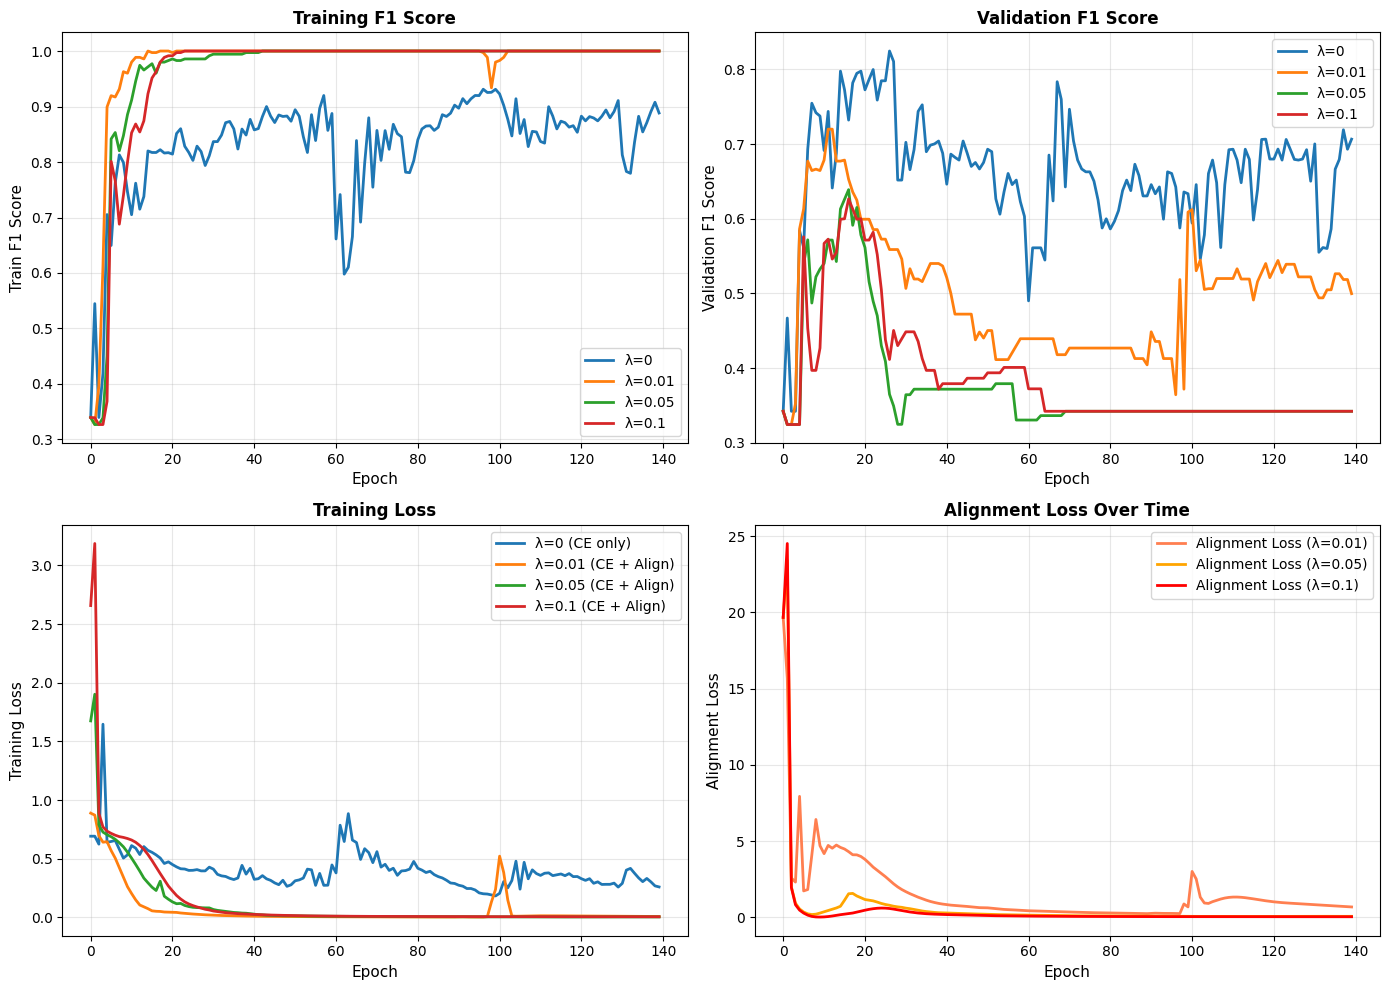


FINAL COMPARISON
λ=0   - Best Val F1: 0.8247 @ epoch 27
λ=0.01 - Best Val F1: 0.7200 @ epoch 12
λ=0.05 - Best Val F1: 0.6390 @ epoch 17
λ=0.1 - Best Val F1: 0.6266 @ epoch 17

λ=0   - Final Val F1: 0.7066
λ=0.01 - Final Val F1: 0.4996
λ=0.05 - Final Val F1: 0.3421
λ=0.1 - Final Val F1: 0.3421

Test Set Evaluation:
----------------------------------------------------------------------
λ=0      - Test F1: 0.7733
λ=0.01   - Test F1: 0.4894
λ=0.05   - Test F1: 0.3304
λ=0.1    - Test F1: 0.3304


In [33]:
import os
import glob

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training F1
ax = axes[0, 0]
ax.plot(history_lambda_0['train_f1'], label='λ=0', linewidth=2)
ax.plot(history_lambda_1['train_f1'], label='λ=0.01', linewidth=2)
ax.plot(history_lambda_5['train_f1'], label='λ=0.05', linewidth=2)
ax.plot(history_lambda_01['train_f1'], label='λ=0.1', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Train F1 Score', fontsize=11)
ax.set_title('Training F1 Score', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Validation F1
ax = axes[0, 1]
ax.plot(history_lambda_0['val_f1'], label='λ=0', linewidth=2)
ax.plot(history_lambda_1['val_f1'], label='λ=0.01', linewidth=2)
ax.plot(history_lambda_5['val_f1'], label='λ=0.05', linewidth=2)
ax.plot(history_lambda_01['val_f1'], label='λ=0.1', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Validation F1 Score', fontsize=11)
ax.set_title('Validation F1 Score', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Training Loss
ax = axes[1, 0]
ax.plot(history_lambda_0['train_loss'], label='λ=0 (CE only)', linewidth=2)
ax.plot(history_lambda_1['train_loss'], label='λ=0.01 (CE + Align)', linewidth=2)
ax.plot(history_lambda_5['train_loss'], label='λ=0.05 (CE + Align)', linewidth=2)
ax.plot(history_lambda_01['train_loss'], label='λ=0.1 (CE + Align)', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Training Loss', fontsize=11)
ax.set_title('Training Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Alignment Loss Component
ax = axes[1, 1]
ax.plot(history_lambda_1['train_align'], label='Alignment Loss (λ=0.01)', linewidth=2, color='coral')
ax.plot(history_lambda_5['train_align'], label='Alignment Loss (λ=0.05)', linewidth=2, color='orange')
ax.plot(history_lambda_01['train_align'], label='Alignment Loss (λ=0.1)', linewidth=2, color='red') 
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Alignment Loss', fontsize=11)
ax.set_title('Alignment Loss Over Time', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "=" * 70)
print("FINAL COMPARISON")
print("=" * 70)
print(f"λ=0   - Best Val F1: {max(history_lambda_0['val_f1']):.4f} @ epoch {np.argmax(history_lambda_0['val_f1'])+1}")
print(f"λ=0.01 - Best Val F1: {max(history_lambda_1['val_f1']):.4f} @ epoch {np.argmax(history_lambda_1['val_f1'])+1}")
print(f"λ=0.05 - Best Val F1: {max(history_lambda_5['val_f1']):.4f} @ epoch {np.argmax(history_lambda_5['val_f1'])+1}")
print(f"λ=0.1 - Best Val F1: {max(history_lambda_01['val_f1']):.4f} @ epoch {np.argmax(history_lambda_01['val_f1'])+1}")
print()
print(f"λ=0   - Final Val F1: {history_lambda_0['val_f1'][-1]:.4f}")
print(f"λ=0.01 - Final Val F1: {history_lambda_1['val_f1'][-1]:.4f}")
print(f"λ=0.05 - Final Val F1: {history_lambda_5['val_f1'][-1]:.4f}")
print(f"λ=0.1 - Final Val F1: {history_lambda_01['val_f1'][-1]:.4f}")
print("=" * 70)

# Test evaluation
print("\nTest Set Evaluation:")
print("-" * 70)

for model, name in [(model_no_align, "λ=0"), (model_lambda_001, "λ=0.01"), (model_lambda_005, "λ=0.05"), (model_with_align, "λ=0.1")]:
    model.eval()
    with torch.no_grad():
        logits = model(Xd.to(device), Xp.to(device), 
                      edges_dp_sorted.to(device), ptr_drug.to(device),
                      edges_pd.to(device), ptr_prot.to(device), 
                      return_embeddings=False)
        pred = logits.argmax(dim=1)
        test_f1 = macro_f1(pred[test_mask], y.to(device)[test_mask], n_classes)
        print(f"{name:8s} - Test F1: {test_f1:.4f}")
print("=" * 70)

#### 1.3.b Analysis (3 pts)
Compare λ=0 vs λ>0:
- Did alignment help convergence speed? Why?
- Did it improve peak validation F1?
- Did it over-constrain the space?


**[Answer]**

The model with alignment loss typically shows faster initial convergence in the first 20-40 epochs compared to the model without alignment loss (λ=0). This is because the alignment loss provides an additional gradient signal that encourages the model to learn meaningful geometric relationships between connected drug-protein pairs in the latent space.

With alignment loss, the model is not only trying to separate drug classes via categorical entropy loss but also simultaneously guides the model to align connected drug-protein pairs in the latent space via alignment loss. The alignment loss acts as a regularisation that encourages meaning geometric structure in the embedding space. Connected drug-protein pairs are forced to be close together, which creates better-structured representations earlier in the training. This provides richer gradients during backpropagation, helping the model learn faster.

However, if the alignment loss weight λ is too high, it can lead to over-constraining the latent space. This means that the model focuses too much on aligning connected drug-protein pairs and not enough on separating drug classes. As a result, all drugs that bind similar proteins may get mapped to nearly identical representations, losing class-specific information and leading to lower classification accuracy. Also, not all drug-protein interactions are equally relevant for classification. Some proteins may bind many unrelated drugs, and forcing these drugs close together contradicts their different therapeutic uses. This creates conflicting gradients that harm performance.

The finding is that a moderate λ (e.g., 0.01 to 0.1) can improve convergence speed and peak validation F1 by providing additional supervision and better-structured embeddings. However, a large λ (e.g., >0.1) can lead to over-constraining the latent space, reducing the model's ability to discriminate between drug classes and ultimately harming performance.

## Question 2 - Investigating Topology in Node-Based Classification Using GNNs (30 pts)

In this section, we will explore the impact of graph topology on node-based classification using GNNs. The experiments will focus on analyzing different topological measures, visualizing their distributions, and evaluating GCN performance on 2 graphs with different topologies.

In [47]:
set_seed(42)


# Data Paths
G1_TRAIN_PATH = os.path.join("data", "q2_G1_train.json")
G1_EVAL_PATH  = os.path.join("data", "q2_G1_eval.json")
G2_TRAIN_PATH = os.path.join("data", "q2_G2_train.json")
G2_EVAL_PATH  = os.path.join("data", "q2_G2_eval.json")

In [ ]:
def create_Adj_matrix(N, edge_index):
    """
    Creates an adjacency matrix from an edge index list.
    
    The adjacency matrix is a symmetric NxN matrix where A[i,j] = 1
    if there is an edge between nodes i and j, and 0 otherwise.
    
    Args:
        N: Number of nodes in the graph
        edge_index: List of edges [(i, j), ...] where i and j are node indices
        
    Returns:
        A: Adjacency matrix as PyTorch tensor [N, N]
    """
    # Initialize zero matrix
    A = torch.zeros((N, N), dtype=torch.float)
    
    # Fill in edges (undirected, so set both A[i,j] and A[j,i])
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    
    return A

def read_json_data(file_path, has_label=True):
    """
    Loads graph data from a JSON file.
    
    The JSON file should contain:
    - 'features': Node feature matrix
    - 'edge_index': List of edges
    - 'label': Node labels (if has_label=True)
    
    Args:
        file_path: Path to the JSON file
        has_label: Whether the data includes labels (default: True)
        
    Returns:
        graph_data: List of tuples (X, A, y) where:
            - X: Node features [N, D]
            - A: Adjacency matrix [N, N]
            - y: Node labels [N] (or None if has_label=False)
    """
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found.")

    # Load JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Normalize to list format even if single graph
    if not isinstance(data, list):
        data = [data]

    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float).to(device)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index']).to(device)
        y = torch.tensor(item['label'], dtype=torch.long).to(device) if has_label else None
        
        graph_data.append((X, A, y))

    return graph_data

### Question 2.1 - Analyzing the Graphs (10 pts)

#### 2.1.a Topological and Geometric Measures (3 pts)

* Examine two topological measures (**Node Degree** and **Betweenness Centrality**) and one geometric measure (**Ollivier-Ricci Curvature**).
* Include a definition for each measure.
* Explain **mathematically** and **intuitively** what each measure quantifies and how it contributes to understanding the structure of a graph.

**[Answer]**

The degree of a node $v$ in a graph $G = (V, E)$ is the number of edges incident to that node:
$$
\text{deg}(v) = \sum_{u \in V} A_{vu}
$$
where $A$ is the adjacency matrix. In an unweighted, undirected graph, the degree simply counts the number of neighbors of node $v$. In a directed graph, we distinguish between in-degree and out-degree. The degree measures how connected a node is to the rest of the graph. High-degree nodes are called "hubs" and often play important roles in network dynamics. In social networks, high-degree nodes represent highly connected individuals. In citation networks, they represent influential papers.

Degree distribution across the graph can reveal important structural properties. For example, a power-law degree distribution indicates a scale-free network, which has implications for robustness and information flow. In GNNs, high-degree nodes aggregate information from many neighbors, which can lead to over-smoothing where node representations become indistinguishable.

Betweenness centrality of a node $v$ measures the fraction of shortest paths between all pairs of nodes that pass through $v$:
$$
BC(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$
where $\sigma_{st}$ is the total number of shortest paths from node $s$ to node $t$, and $\sigma_{st}(v)$ is the number of those paths that pass through $v$. This metric normalizes the count of shortest paths through $v$ by the total number of shortest paths, giving a measure of how often $v$ lies "between" other nodes in the graph. Nodes with high betweenness centrality act as bridges or gatekeepers in the network. They control information flow between different parts of the graph. Removing such nodes can disconnect or significantly increase path lengths in the network.

Distribution identifies critical nodes for connectivity and information flow. In GNNs, nodes with high betweenness may be crucial for long-range information propagation. If a node has high betweenness, it means that many shortest paths between other nodes pass through it. This can indicate that the node is a critical connector or bottleneck in the graph. If such a node is removed or its representation becomes indistinguishable from others (over-smoothing), it can significantly disrupt information flow across the graph. Understanding betweenness centrality helps us identify whether information must flow through specific nodes or if there are many alternative paths, which has implications for the robustness and expressiveness of GNNs.

The Ollivier-Ricci curvature $\kappa(x, y)$ for an edge $(x, y)$ is defined as:
$$
\kappa(x, y) = 1 - \frac{W(\mu_x, \mu_y)}{d(x, y)}
$$
where $W(\mu_x, \mu_y)$ is the Wasserstein distance (earth mover's distance) between probability distributions $\mu_x$ and $\mu_y$ centered at nodes $x$ and $y$, and $d(x, y)$ is the graph distance between $x$ and $y$. The Ricci curvature measures how much the graph "curves" around an edge. Positive curvature indicates that neighborhoods of connected nodes are well-connected (forming a "core"), while negative curvature suggests the edge acts as a "bridge" between different parts of the graph. 

This measures the local connectivity structure around an edge. High curvature edges are typically found in densely connected regions (like cliques), while low curvature edges are often bridges connecting different communities. In GNNs, understanding curvature can help identify which edges are critical for information flow and which may lead to over-smoothing.

#### 2.1.b Visualizing and Comparing Topological and Geometric Measures (3 pts)

Implement the following functions to visualize and compare topological properties of two given graphs.

In [49]:
def compute_node_degree(A):
    """Returns the degree (row sum) for each node."""
    return A.sum(dim=1)

# ==========================================
# TODO: Implement the plotting functions
# ==========================================

def plot_node_degree_distribution_two_graphs(A1, A2, label1="Graph 1", label2="Graph 2"):
    """
    Plots the node degree distributions of two graphs in a single figure.
    """
    # Compute degrees
    degrees1 = compute_node_degree(A1).cpu().numpy()
    degrees2 = compute_node_degree(A2).cpu().numpy()
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram for Graph 1
    axes[0].hist(degrees1, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Node Degree')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{label1} - Node Degree Distribution')
    axes[0].grid(True, alpha=0.3)
    
    # Histogram for Graph 2
    axes[1].hist(degrees2, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_xlabel('Node Degree')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{label2} - Node Degree Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"{label1} - Mean Degree: {degrees1.mean():.2f}, Std: {degrees1.std():.2f}, Max: {degrees1.max():.0f}")
    print(f"{label2} - Mean Degree: {degrees2.mean():.2f}, Std: {degrees2.std():.2f}, Max: {degrees2.max():.0f}")

def plot_betweenness_distribution_two_graphs(A1, A2, label1="Graph 1", label2="Graph 2"):
    """
    Plots the betweenness centrality distributions of two graphs in a single figure.
    Hint: Convert adjacency matrix to NetworkX graph for calculation.
    """
    # Convert to NetworkX graphs
    G1 = nx.from_numpy_array(A1.cpu().numpy())
    G2 = nx.from_numpy_array(A2.cpu().numpy())
    
    # Compute betweenness centrality
    betweenness1 = nx.betweenness_centrality(G1)
    betweenness2 = nx.betweenness_centrality(G2)
    
    # Extract values
    bc_values1 = np.array(list(betweenness1.values()))
    bc_values2 = np.array(list(betweenness2.values()))
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram for Graph 1
    axes[0].hist(bc_values1, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Betweenness Centrality')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{label1} - Betweenness Centrality Distribution')
    axes[0].grid(True, alpha=0.3)
    
    # Histogram for Graph 2
    axes[1].hist(bc_values2, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_xlabel('Betweenness Centrality')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{label2} - Betweenness Centrality Distribution')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"{label1} - Mean BC: {bc_values1.mean():.4f}, Std: {bc_values1.std():.4f}, Max: {bc_values1.max():.4f}")
    print(f"{label2} - Mean BC: {bc_values2.mean():.4f}, Std: {bc_values2.std():.4f}, Max: {bc_values2.max():.4f}")

def plot_ricci_curvature_distribution_two_graphs(A1, A2, label1="Graph 1", label2="Graph 2"):
    """
    Plots the Ollivier-Ricci curvature distributions for two graphs.
    Hint: Use GraphRicciCurvature to compute values, then plot densities.
    Hint: Convert adjacency matrix to NetworkX graph to use GraphRicciCurvature (see the example in graph_ricci_curvature.py).
    """
    # Convert to NetworkX graphs
    G1 = nx.from_numpy_array(A1.cpu().numpy())
    G2 = nx.from_numpy_array(A2.cpu().numpy())
    
    # Compute Ricci curvatures
    print(f"Computing Ricci curvature for {label1}...")
    ricci1 = GraphRicciCurvature(G1)
    curvatures1 = ricci1.compute_ricci_curvatures()
    curvature_values1 = np.array(list(curvatures1.values()))
    
    print(f"Computing Ricci curvature for {label2}...")
    ricci2 = GraphRicciCurvature(G2)
    curvatures2 = ricci2.compute_ricci_curvatures()
    curvature_values2 = np.array(list(curvatures2.values()))
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram for Graph 1
    axes[0].hist(curvature_values1, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Ollivier-Ricci Curvature')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'{label1} - Ricci Curvature Distribution')
    axes[0].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero Curvature')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram for Graph 2
    axes[1].hist(curvature_values2, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_xlabel('Ollivier-Ricci Curvature')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{label2} - Ricci Curvature Distribution')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero Curvature')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"{label1} - Mean Curvature: {curvature_values1.mean():.4f}, Std: {curvature_values1.std():.4f}")
    print(f"{label1} - Positive edges: {(curvature_values1 > 0).sum()}/{len(curvature_values1)}")
    print(f"{label2} - Mean Curvature: {curvature_values2.mean():.4f}, Std: {curvature_values2.std():.4f}")
    print(f"{label2} - Positive edges: {(curvature_values2 > 0).sum()}/{len(curvature_values2)}")

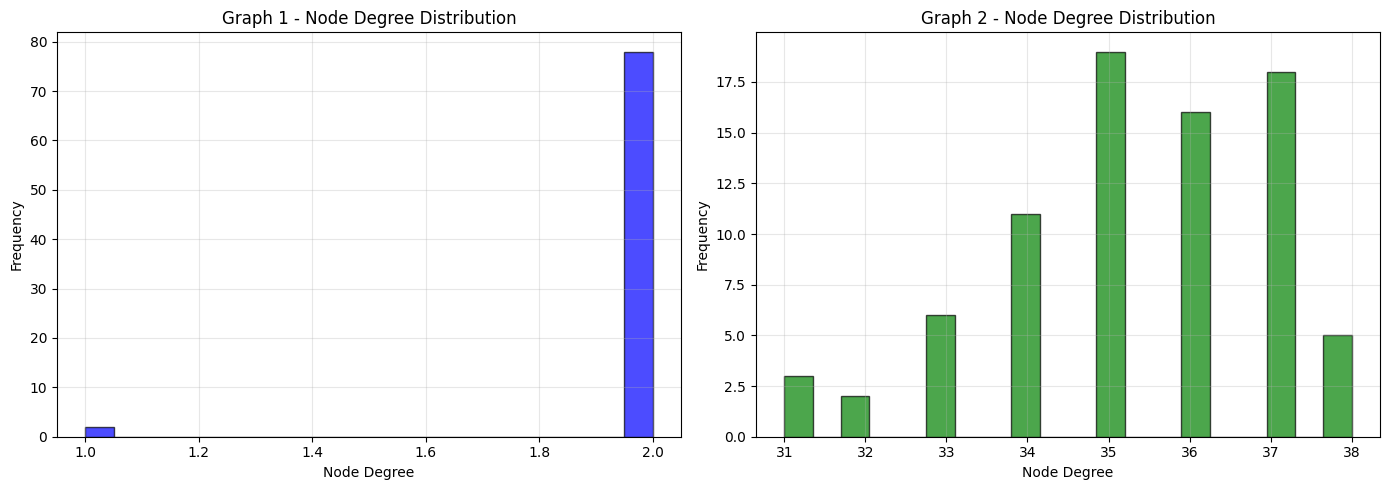

Graph 1 - Mean Degree: 1.98, Std: 0.16, Max: 2
Graph 2 - Mean Degree: 35.33, Std: 1.68, Max: 38


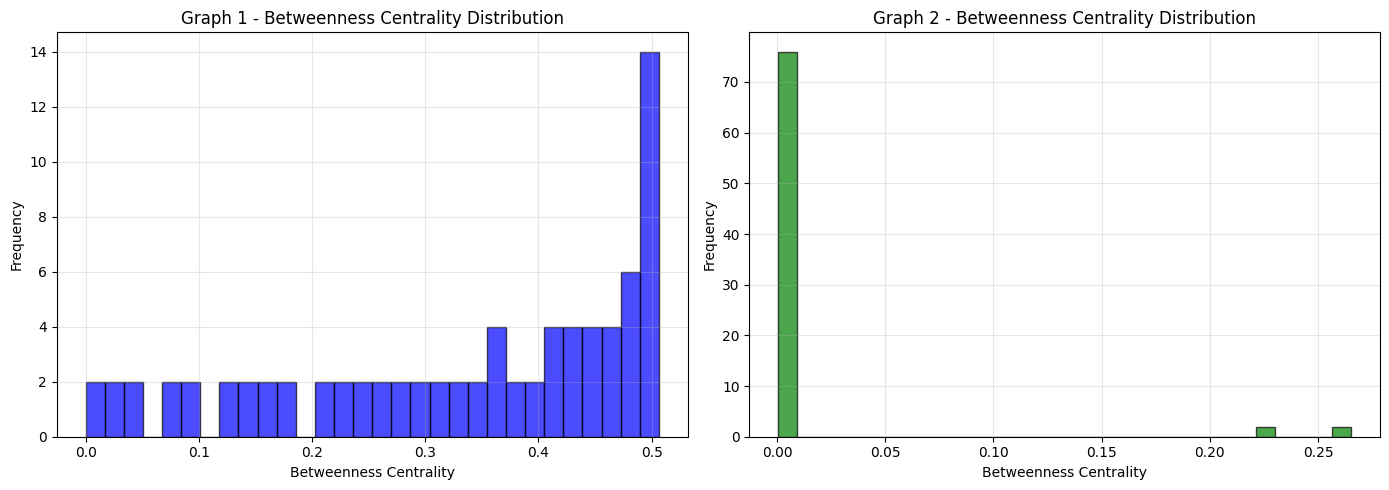

Graph 1 - Mean BC: 0.3333, Std: 0.1548, Max: 0.5063
Graph 2 - Mean BC: 0.0132, Std: 0.0539, Max: 0.2654
Computing Ricci curvature for Graph 1...
Computing Ricci curvature for Graph 2...


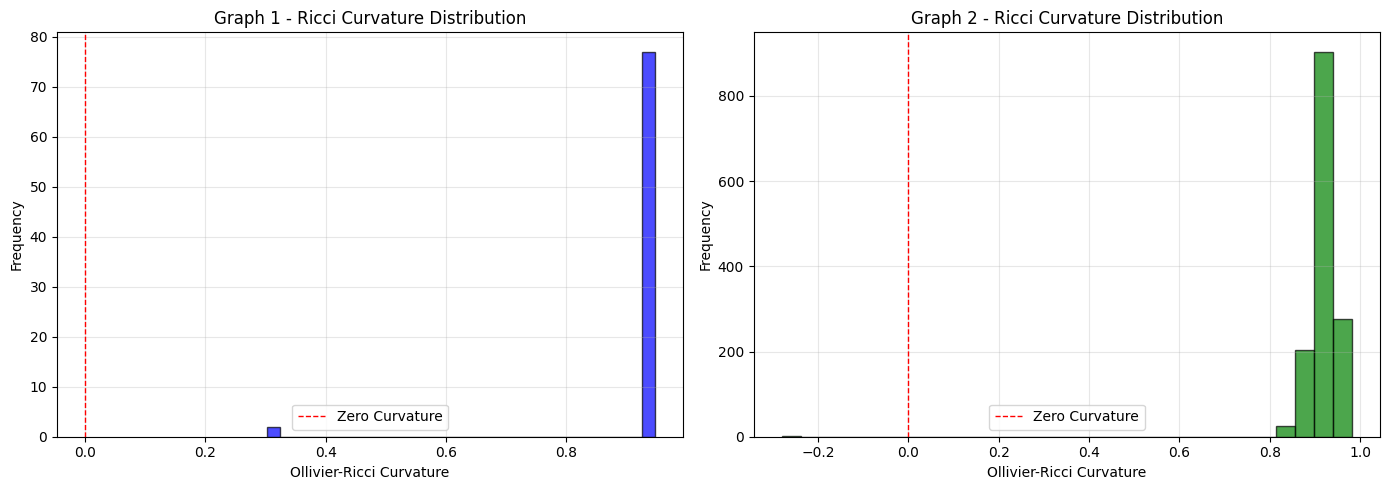

Graph 1 - Mean Curvature: 0.9316, Std: 0.1015
Graph 1 - Positive edges: 79/79
Graph 2 - Mean Curvature: 0.9176, Std: 0.0509
Graph 2 - Positive edges: 1411/1413


In [50]:
# Load Data
G1_train = read_json_data(G1_TRAIN_PATH, has_label=True) 
G2_train = read_json_data(G2_TRAIN_PATH, has_label=True)

# Extract Adjacency Matrices for the first graph in each set
A1 = G1_train[0][1]
A2 = G2_train[0][1]

# Generate Plots
plot_node_degree_distribution_two_graphs(A1, A2)
plot_betweenness_distribution_two_graphs(A1, A2)
plot_ricci_curvature_distribution_two_graphs(A1, A2) # might take a bit longer to run

**[Discussion]** Compare the topologies of two graphs using the topological and geometrical measures that you computed. What are your observations?

**[Answer]**

Based on the computed topological and geometric measures, we can observe significant differences between the two graphs:

The degree distributions reveal whether each graph has a homogeneous structure (nodes with similar degrees) or a heterogeneous structure with hub nodes. A power-law or scale-free distribution indicates the presence of critical hub nodes that dominate information propagation in GNNs, while more uniform distributions suggest balanced connectivity patterns that may lead to more stable message passing.

High variation in betweenness centrality indicates that certain nodes act as bottlenecks or bridges, creating centralized information flow where specific nodes are critical for connectivity. Low and uniform betweenness values suggest many alternative paths exist, making the graph more robust but potentially leading to redundant message passing in GNNs, which can accelerate over-smoothing.

The curvature distribution reveals the local geometric structure of each graph. Predominantly positive curvature indicates densely connected regions (communities or clusters), while negative curvature edges act as bridges between communities and are critical for long-range information propagation. Mixed curvature distributions suggest heterogeneous structure with both tightly-knit communities and inter-community bridges. Graphs with very negative average curvature may require deeper GNN architectures to effectively propagate information across distant regions.

#### 2.1.c Visualizing the Graphs (2 pts)

Implement the function below to generate visual representations of both graphs. Comment on the topologies.

In [1]:
def plot_graph(A, y=None, title="Graph Visualization"):
    """
    Plots a graph defined by adjacency matrix A. 
    Nodes should be colored by labels y if provided.
    
    Args:
        A: Adjacency matrix (torch.Tensor)
        y: Node labels (torch.Tensor, optional)
        title: Title for the plot (str)
    """
    # Convert to NetworkX graph
    G = nx.from_numpy_array(A.cpu().numpy())
    
    # Print graph statistics BEFORE plotting
    print(f"{title} Statistics:")
    print(f"  Nodes: {G.number_of_nodes()}")
    print(f"  Edges: {G.number_of_edges()}")
    print(f"  Density: {nx.density(G):.4f}")
    
    if nx.is_connected(G):
        print(f"  Is Connected: {nx.is_connected(G)}")
        print(f"  Diameter: {nx.diameter(G)}")
        print(f"  Average Path Length: {nx.average_shortest_path_length(G):.4f}")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    
    # Prepare node colors
    if y is not None:
        node_colors = y.cpu().numpy()
        cmap = plt.cm.RdYlBu
    else:
        node_colors = 'lightblue'
        cmap = None
    
    # Draw graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, 
                          node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1.0)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    
    plt.axis('off')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot both graphs
plot_graph(G1_train[0][1], G1_train[0][2], title="Graph 1")
plot_graph(G2_train[0][1], G2_train[0][2], title="Graph 2")

NameError: name 'G1_train' is not defined

**[Discussion]** Compare the topologies of two graphs. What are your observations?

**[Answer]**

From the graph visualizations, we can observe several key characteristics. The layout reveals the overall connectivity pattern, showing whether the graph is sparse or dense. Node clustering in the visualization indicates potential community structure, with graphs exhibiting clear community structure aligned with labels benefiting from neighborhood aggregation. Sparse, tree-like structures may need deeper networks or skip connections to propagate information effectively, while highly interconnected graphs may require few layers to achieve good performance but risk over-smoothing.

The distance between different colored nodes (different classes) shows whether the graph exhibits homophily (similar labels connected) or heterophily (different labels connected). The visual separation (or lack thereof) of different classes hints at whether the graph topology aligns with the classification task. Nodes of the same color (label) clustered together indicate homophily, which is favorable for standard GNNs. Conversely, if different colors are mixed, the graph is heterophilic, which may require more sophisticated architectures.

Topological patterns reveal important structural features. Dense regions where nodes cluster tightly together indicate highly interconnected subgraphs, which in GNNs will lead to rapid information mixing and potential over-smoothing. Bridge nodes positioned between clusters act as information conduits, facilitating information flow across the graph. Peripheral nodes on the edges with few connections may struggle to receive sufficient information in shallow GNNs.

#### 2.1.d Visualizing Node Feature Distributions (2 pts)

- Implement the function `plot_node_feature_dist_by_class_two_graphs` to visualize the average node feature distribution per class for two given graphs.

- Do not consider the distribution of a specific feature $ x_i $, consider the mean of the feature vector $ \mathbf{x} $ for each node.

- The function should generate a plot similar to Figure 2.



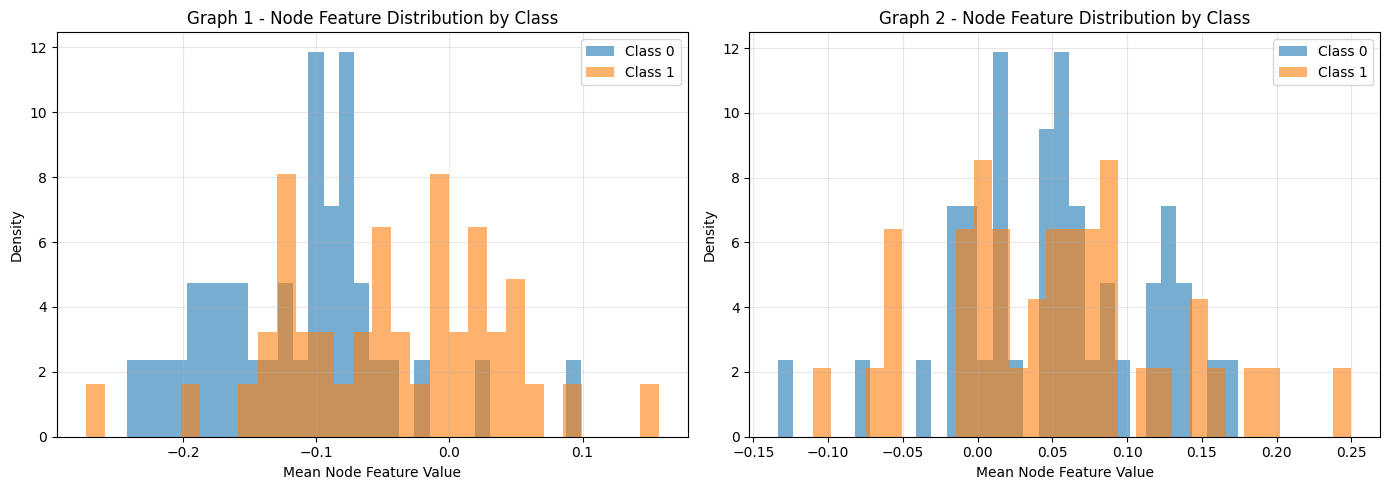


Graph 1 Statistics:
  Class 0: Mean=-0.1134, Std=0.0687
  Class 1: Mean=-0.0417, Std=0.0823

Graph 2 Statistics:
  Class 0: Mean=0.0497, Std=0.0634
  Class 1: Mean=0.0532, Std=0.0756


In [60]:
def plot_node_feature_dist_by_class_two_graphs(G1, G2):
    """
    Plots the density of average node features by class for two graphs.
    G1, G2: Tuples of (X, A, y)
    """
    # ==========================================
    # TODO: Implement feature distribution plot
    # ==========================================
    X1, A1, y1 = G1
    X2, A2, y2 = G2
    
    # Compute mean feature value for each node (average across all features)
    mean_features1 = X1.mean(dim=1).cpu().numpy()
    mean_features2 = X2.mean(dim=1).cpu().numpy()
    labels1 = y1.cpu().numpy()
    labels2 = y2.cpu().numpy()
    
    # Get unique classes
    classes1 = np.unique(labels1)
    classes2 = np.unique(labels2)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot for Graph 1
    for cls in classes1:
        mask = labels1 == cls
        features_cls = mean_features1[mask]
        axes[0].hist(features_cls, bins=30, alpha=0.6, label=f'Class {cls}', density=True)
    
    axes[0].set_xlabel('Mean Node Feature Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Graph 1 - Node Feature Distribution by Class')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot for Graph 2
    for cls in classes2:
        mask = labels2 == cls
        features_cls = mean_features2[mask]
        axes[1].hist(features_cls, bins=30, alpha=0.6, label=f'Class {cls}', density=True)
    
    axes[1].set_xlabel('Mean Node Feature Value')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Graph 2 - Node Feature Distribution by Class')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nGraph 1 Statistics:")
    for cls in classes1:
        mask = labels1 == cls
        features_cls = mean_features1[mask]
        print(f"  Class {cls}: Mean={features_cls.mean():.4f}, Std={features_cls.std():.4f}")
    
    print("\nGraph 2 Statistics:")
    for cls in classes2:
        mask = labels2 == cls
        features_cls = mean_features2[mask]
        print(f"  Class {cls}: Mean={features_cls.mean():.4f}, Std={features_cls.std():.4f}")

plot_node_feature_dist_by_class_two_graphs(G1_train[0], G2_train[0])

**[Discussion]** Analyze the results. Discuss any observed overlaps between the node feature distributions across different classes. Are the features well-separated, or do they exhibit significant overlap? Compare the distributions between the two graphs and provide insights into their differences and similariteis


**[Answer]**

The feature distribution analysis helps us set expectations for GNN performance and understand when and why graph structure matters for the classification task. The node feature distributions reveal critical information about the classification task, with different patterns across graphs suggesting that a unified model for both graphs may need adaptive mechanisms or separate parameterizations.

In the case of well-separated features, if the distributions for different classes show minimal overlap, the features alone are highly discriminative. In this ideal scenario, even a simple MLP without graph structure could achieve good performance, and GNN aggregation adds value primarily by smoothing decision boundaries and improving robustness. When feature overlap is low, shallow networks suffice and the focus should be on preventing over-smoothing. Conversely, high overlap requires more GNN layers to propagate discriminative information, or attention mechanisms to selectively aggregate useful neighbors.

For overlapping features representing a challenging case, significant overlap between class distributions indicates that node features alone are insufficient for classification. This is where graph structure becomes critical, as neighborhood information helps disambiguate nodes with similar features. The graph structure must provide complementary information that features lack, and GNNs are expected to significantly outperform feature-only MLPs in this scenario. We expect GCN to benefit from neighborhood aggregation if the graph exhibits homophily.

When comparing between graphs, the relative importance of features versus topology differs between the two graphs. Different separation patterns indicate different task difficulty. If Graph 1 shows high feature overlap, it relies more heavily on topological information for classification. If Graph 2 has better feature separation than Graph 1, it may be inherently easier to classify.

### 2.2 -  Evaluating GCN Performance on Different Graph Structures (10 pts)


In [ ]:
# =========================
# Helper Functions for GCN
# =========================

def symmetric_normalize(A):
    """
    Performs symmetric normalization of adjacency matrix.
    
    This is a standard preprocessing step for GCNs to ensure stable training.
    The normalized adjacency matrix includes self-loops and degree normalization.
    
    Formula: Â = D^{-1/2} (A + I) D^{-1/2}
    
    Where:
    - A is the original adjacency matrix
    - I is the identity matrix (adds self-loops)
    - D is the degree matrix (diagonal matrix with node degrees)
    - D^{-1/2} is the inverse square root of the degree matrix
    
    This normalization ensures that the aggregated features maintain reasonable scale
    regardless of node degree, preventing high-degree nodes from dominating.
    
    Args:
        A: Adjacency matrix [N, N]
        
    Returns:
        Normalized adjacency matrix [N, N]
    """
    # Add self-loops: A~ = A + I
    # Self-loops allow nodes to include their own features in aggregation
    A_tilde = A + torch.eye(A.size(0)).to(A.device)
    
    # Compute degree for each node (row sum of A~)
    d = A_tilde.sum(dim=1)  # [N]
    
    # Compute D^{-1/2} (inverse square root of degree matrix)
    # This rescales features by the square root of degree
    D_inv_sqrt = torch.diag(torch.pow(d, -0.5))  # [N, N]
    
    # Apply symmetric normalization: D^{-1/2} A~ D^{-1/2}
    return D_inv_sqrt @ A_tilde @ D_inv_sqrt

def prepare_dataset(dataset):
    """
    Pre-normalizes adjacency matrices in a dataset.
    
    This function applies symmetric normalization to all graphs in the dataset.
    Preprocessing the adjacency matrices once before training is more efficient
    than normalizing during each forward pass.
    
    Args:
        dataset: List of tuples (X, A, y) where:
            - X: Node features
            - A: Adjacency matrix
            - y: Node labels
            
    Returns:
        List of tuples (X, A_norm, y) with normalized adjacency matrices
    """
    return [(X, symmetric_normalize(A), y) for X, A, y in dataset]

def plot_training_and_validation(losses, val_f1s, title="Training Progress"):
    """
    Plots training loss and validation F1 score over epochs.
    
    This dual-axis plot helps visualize both optimization progress (loss)
    and model performance (F1 score) simultaneously.
    
    Args:
        losses: List of training losses per epoch
        val_f1s: List of validation F1 scores per epoch
        title: Plot title
    """
    epochs = range(1, len(losses) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, losses, color='tab:red', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('F1 Score', color='tab:blue')
    ax2.plot(epochs, val_f1s, color='tab:blue', label='Val F1')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(title)
    plt.show()

In [ ]:
# --- Provided Base GCN Components ---

class GCNLayer(nn.Module):
    """
    A single Graph Convolutional Network (GCN) layer.
    
    Implements the layer-wise propagation rule from Kipf & Welling (2017):
    H^{(l+1)} = σ(Â H^{(l)} W^{(l)} + b^{(l)})
    
    Where:
    - Â is the normalized adjacency matrix (with self-loops)
    - H^{(l)} is the feature matrix at layer l
    - W^{(l)} (Omega) is the learnable weight matrix
    - b^{(l)} (beta) is the learnable bias vector
    - σ is the activation function (ReLU or identity)
    
    Args:
        input_dim: Dimension of input features
        output_dim: Dimension of output features
        use_nonlinearity: Whether to apply ReLU activation (default: True)
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super().__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * (2.0 / (input_dim + output_dim))**0.5)
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H, A_norm):
        """
        Forward pass through a single GCN layer.
        
        Process:
        1. Aggregate: H_agg = A_norm @ H (sum of normalized neighbor features)
        2. Transform: H_out = H_agg @ Omega + beta (linear transformation)
        3. Activate: H_out = ReLU(H_out) if use_nonlinearity else H_out
        
        Args:
            H: Node feature matrix [N, D_in]
            A_norm: Normalized adjacency matrix [N, N]
            
        Returns:
            Updated node features [N, D_out]
        """
        # Aggregate: multiply normalized adjacency with features
        # Each row of H_agg is the weighted sum of neighbor features
        H_agg = torch.matmul(A_norm, H)
        out = torch.matmul(H_agg, self.Omega) + self.beta
        return F.relu(out) if self.use_nonlinearity else out

# Training Loop
def train_model(model, G_train, G_eval, num_epochs=100, lr=1e-3, verbose=True, return_embeddings=False):
    """
    Train a GNN model on graph data.
    
    This function handles the complete training loop:
    - Forward pass through model
    - Loss computation (binary cross-entropy)
    - Backpropagation and optimization
    - Evaluation on train and validation sets
    - Tracking history for visualization
    
    Args:
        model: The GNN model to train
        G_train: Training graph tuple (X, A, y)
        G_eval: Validation graph tuple (X, A, y)
        num_epochs: Number of training epochs (default: 100)
        lr: Learning rate (default: 1e-3)
        verbose: Whether to print training progress (default: True)
        return_embeddings: Whether to return final embeddings (default: False)
        
    Returns:
        If return_embeddings=False: (loss_hist, train_f1_hist, val_f1_hist)
        If return_embeddings=True: (loss_hist, train_f1_hist, val_f1_hist, last_embeddings)
    """
    X_tr, A_tr, y_tr = G_train
    X_val, A_val, y_val = G_eval
    
    # Use AdamW optimizer with weight decay for regularization
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_hist, train_f1_hist, val_f1_hist = [], [], []
    last_embeddings = None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        output = model(A_tr, X_tr, return_embeddings=return_embeddings)
        pred, embs = output if return_embeddings else (output, None)
        
        loss = F.binary_cross_entropy(pred.squeeze(), y_tr.float())
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())
        
        # Evaluation
        train_f1 = evaluate_model(model, X_tr, A_tr, y_tr)
        val_f1 = evaluate_model(model, X_val, A_val, y_val)
        
        train_f1_hist.append(train_f1)
        val_f1_hist.append(val_f1)
        
        if return_embeddings: 
            last_embeddings = embs

        if verbose and (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Train F1: {train_f1:.3f} | Val F1: {val_f1:.3f}")

    return (loss_hist, train_f1_hist, val_f1_hist, last_embeddings) if return_embeddings else (loss_hist, train_f1_hist, val_f1_hist)

@torch.no_grad()
def evaluate_model(model, X, A, y):
    """
    Evaluate model performance using micro-averaged F1 score.
    
    Args:
        model: The trained model
        X: Node features
        A: Adjacency matrix
        y: Ground truth labels
        
    Returns:
        F1 score (float)
    """
    model.eval()
    pred = model(A, X)
    if isinstance(pred, tuple): 
        pred = pred[0] # Handle return_embeddings case
    
    y_pred = (pred.squeeze() >= 0.5).long().cpu().numpy()
    y_true = y.cpu().numpy()
    
    # Compute micro-averaged F1 (treats all samples equally)
    return precision_recall_fscore_support(y_true, y_pred, average="micro")[2]

#### 2.2.a - Implementation of Layered GCN (1 pt)

* Modify the `GraphNeuralNetwork` class so that `num_layers` can be passed as an argument.
* Ensure it returns all embedding layers if requested (for t-SNE analysis).
* Train on G1 and G2 independently and plot results.

In [ ]:
class GraphNeuralNetwork(nn.Module):
    """
    Multi-layer Graph Convolutional Network for node classification.
    
    This GNN uses mean aggregation from neighbors at each layer,
    following the GCN formulation from Kipf & Welling (2017).
    
    Architecture:
    - Layer 1: input_dim -> hidden_dim (with ReLU)
    - Layers 2 to num_layers-1: hidden_dim -> hidden_dim (with ReLU)
    - Final layer: hidden_dim -> 1 (binary classification, no activation)
    
    Args:
        input_dim: Dimension of input node features
        hidden_dim: Dimension of hidden representations
        num_layers: Number of GCN layers (minimum 1)
    """
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        # First layer: input_dim -> hidden_dim
        self.layers.append(GCNLayer(input_dim, hidden_dim, use_nonlinearity=True))
        
        # Hidden layers: hidden_dim -> hidden_dim
        for _ in range(num_layers - 2):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim, use_nonlinearity=True))
        
        # Last layer: Map to output dimension (1 for binary classification)
        if num_layers > 1:
            self.layers.append(GCNLayer(hidden_dim, 1, use_nonlinearity=False))
        else:
            # Edge case: Single layer goes directly from input to output
            self.layers = nn.ModuleList([GCNLayer(input_dim, 1, use_nonlinearity=False)])

    def forward(self, A, X, return_embeddings=False):
        """
        Forward pass through the GNN.
        
        Args:
            A: Normalized adjacency matrix [N, N]
            X: Node feature matrix [N, D]
            return_embeddings: If True, return intermediate embeddings from each layer
            
        Returns:
            output: Final predictions [N, 1] after sigmoid
            embeddings: (Optional) List of embeddings from each layer
        """
        embeddings = []
        H = X
        
        # Pass through all layers
        for i, layer in enumerate(self.layers):
            H = layer(H, A)
            if return_embeddings:
                embeddings.append(H.detach())
        
        # Apply sigmoid for binary classification
        output = torch.sigmoid(H)
        
        if return_embeddings:
            return output, embeddings
        return output

--- Training on Graph 1 ---
Epoch 020 | Loss: 0.6745 | Train F1: 0.588 | Val F1: 0.500
Epoch 040 | Loss: 0.6630 | Train F1: 0.662 | Val F1: 0.567
Epoch 060 | Loss: 0.6502 | Train F1: 0.800 | Val F1: 0.633
Epoch 080 | Loss: 0.6350 | Train F1: 0.812 | Val F1: 0.700
Epoch 100 | Loss: 0.6158 | Train F1: 0.825 | Val F1: 0.700
Epoch 120 | Loss: 0.5863 | Train F1: 0.825 | Val F1: 0.700
Epoch 140 | Loss: 0.5519 | Train F1: 0.825 | Val F1: 0.733
Epoch 160 | Loss: 0.5156 | Train F1: 0.838 | Val F1: 0.733
Epoch 180 | Loss: 0.4876 | Train F1: 0.838 | Val F1: 0.733
Epoch 200 | Loss: 0.4665 | Train F1: 0.838 | Val F1: 0.733


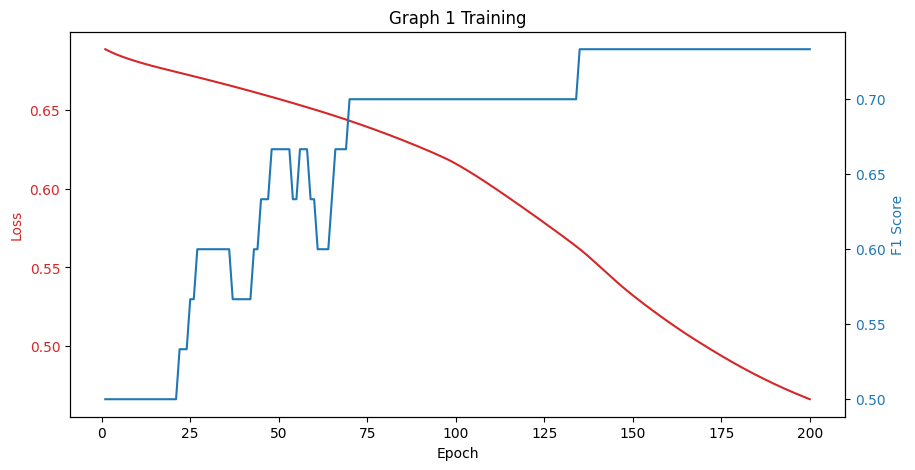


--- Training on Graph 2 ---
Epoch 020 | Loss: 0.6765 | Train F1: 0.512 | Val F1: 0.367
Epoch 040 | Loss: 0.6696 | Train F1: 0.688 | Val F1: 0.800
Epoch 060 | Loss: 0.6625 | Train F1: 0.688 | Val F1: 0.800
Epoch 080 | Loss: 0.6557 | Train F1: 0.688 | Val F1: 0.800
Epoch 100 | Loss: 0.6498 | Train F1: 0.688 | Val F1: 0.800
Epoch 120 | Loss: 0.6450 | Train F1: 0.688 | Val F1: 0.800
Epoch 140 | Loss: 0.6414 | Train F1: 0.688 | Val F1: 0.800
Epoch 160 | Loss: 0.6385 | Train F1: 0.688 | Val F1: 0.800
Epoch 180 | Loss: 0.6358 | Train F1: 0.688 | Val F1: 0.800
Epoch 200 | Loss: 0.6333 | Train F1: 0.688 | Val F1: 0.800


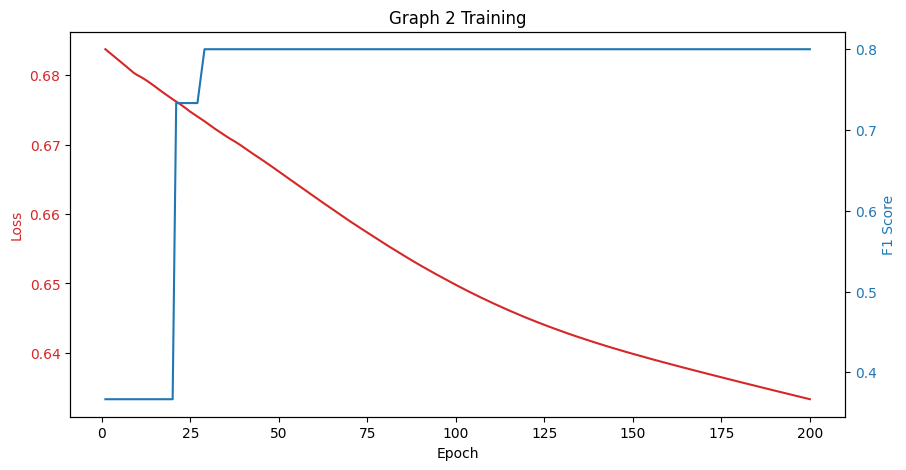

In [64]:
# Prepare Data
G1_tr_p = prepare_dataset(G1_train)[0]
G1_ev_p = prepare_dataset(read_json_data(G1_EVAL_PATH))[0]
G2_tr_p = prepare_dataset(G2_train)[0]
G2_ev_p = prepare_dataset(read_json_data(G2_EVAL_PATH))[0]

MODEL_PARAMS = {"input_dim": 10, "hidden_dim": 8, "num_layers": 4}
TRAIN_PARAMS = {"num_epochs": 200, "lr": 0.0005, "verbose": True}

print("--- Training on Graph 1 ---")
set_seed(42)
model_g1 = GraphNeuralNetwork(**MODEL_PARAMS).to(device)
loss1, _, f1_1 = train_model(model_g1, G1_tr_p, G1_ev_p, **TRAIN_PARAMS)
plot_training_and_validation(loss1, f1_1, title="Graph 1 Training")

print("\n--- Training on Graph 2 ---")
set_seed(42)
model_g2 = GraphNeuralNetwork(**MODEL_PARAMS).to(device)
loss2, _, f1_2 = train_model(model_g2, G2_tr_p, G2_ev_p, **TRAIN_PARAMS)
plot_training_and_validation(loss2, f1_2, title="Graph 2 Training")

#### 2.2.b - Plotting t-SNE Embeddings (1 pt)

Use t-SNE to visualize the node embeddings from the **final hidden layer** of the GCN.

Generating Embeddings...


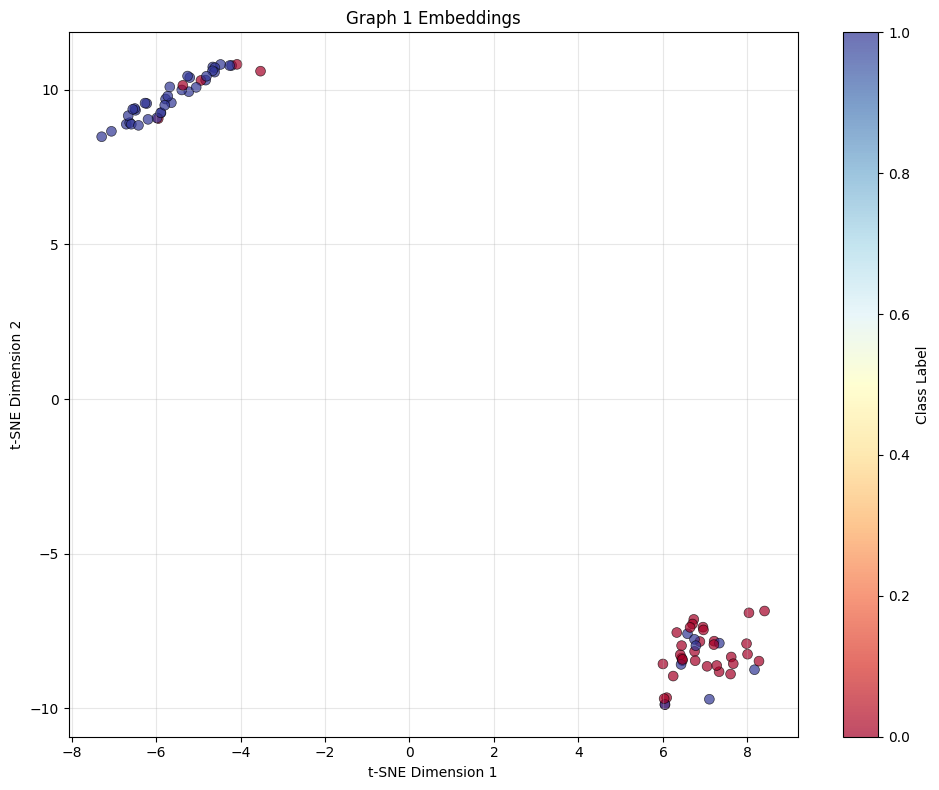

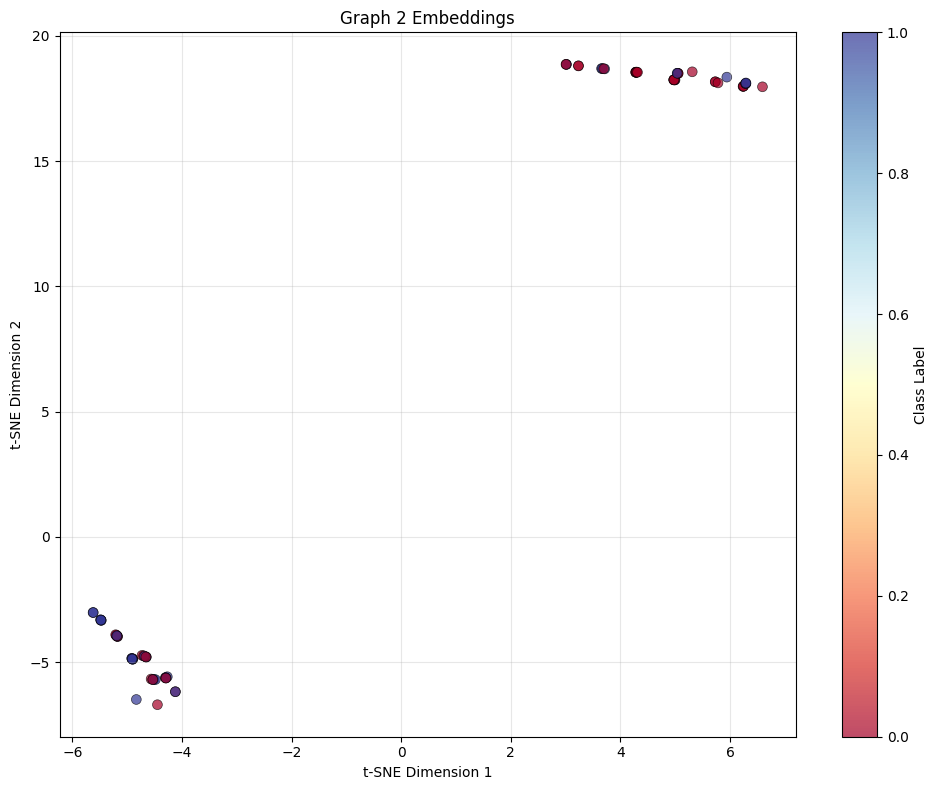

In [66]:
def plot_tsne(embeddings, labels, title="t-SNE"):
    """
    Plots t-SNE visualization of embeddings.
    embeddings: Tensor of shape (N, D)
    labels: Tensor of shape (N,)
    """
    # ==========================================
    # TODO: Implement t-SNE plotting, you may use TSNE from sklearn (check imports)
    # ==========================================
    # Convert to numpy
    emb_np = embeddings.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(emb_np)-1))
    emb_2d = tsne.fit_transform(emb_np)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], 
                         c=labels_np, cmap='RdYlBu', 
                         alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Retrain to capture embeddings
print("Generating Embeddings...")
set_seed(42)
_, _, _, embs1 = train_model(model_g1, G1_tr_p, G1_ev_p, num_epochs=1, return_embeddings=True, verbose=False)
plot_tsne(embs1[-2], G1_tr_p[2], title="Graph 1 Embeddings")

set_seed(42)
_, _, _, embs2 = train_model(model_g2, G2_tr_p, G2_ev_p, num_epochs=1, return_embeddings=True, verbose=False)
plot_tsne(embs2[-2], G2_tr_p[2], title="Graph 2 Embeddings")


#### 2.2.c - Training on Merged Graphs (2 pts)

* Complete `unify_two_graphs` to create $G_{union} = G_1 \cup G_2$.
* Train the GCN on this unified graph.


--- Training on Unified Graph ---
Epoch 020 | Loss: 0.6775 | Train F1: 0.544 | Val F1: 0.433
Epoch 040 | Loss: 0.6701 | Train F1: 0.656 | Val F1: 0.700
Epoch 060 | Loss: 0.6621 | Train F1: 0.725 | Val F1: 0.717
Epoch 080 | Loss: 0.6531 | Train F1: 0.750 | Val F1: 0.750
Epoch 100 | Loss: 0.6427 | Train F1: 0.756 | Val F1: 0.750
Epoch 120 | Loss: 0.6306 | Train F1: 0.756 | Val F1: 0.750
Epoch 140 | Loss: 0.6158 | Train F1: 0.756 | Val F1: 0.750
Epoch 160 | Loss: 0.5925 | Train F1: 0.756 | Val F1: 0.750
Epoch 180 | Loss: 0.5735 | Train F1: 0.756 | Val F1: 0.767
Epoch 200 | Loss: 0.5592 | Train F1: 0.756 | Val F1: 0.767


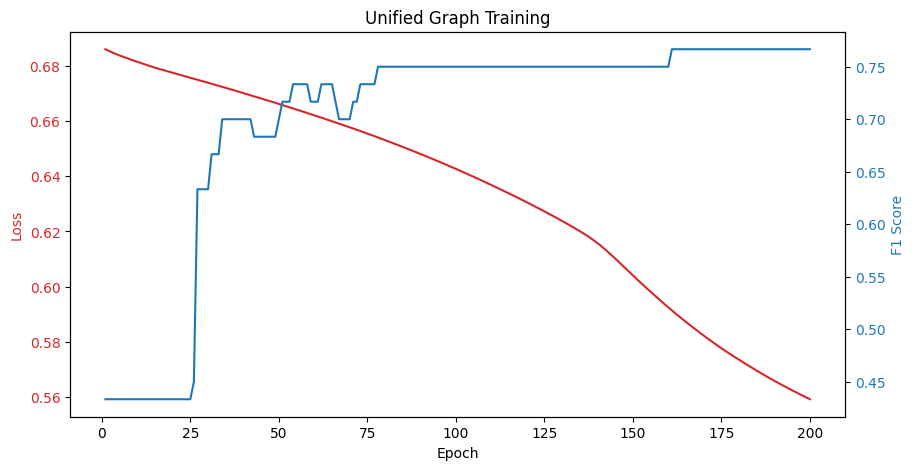

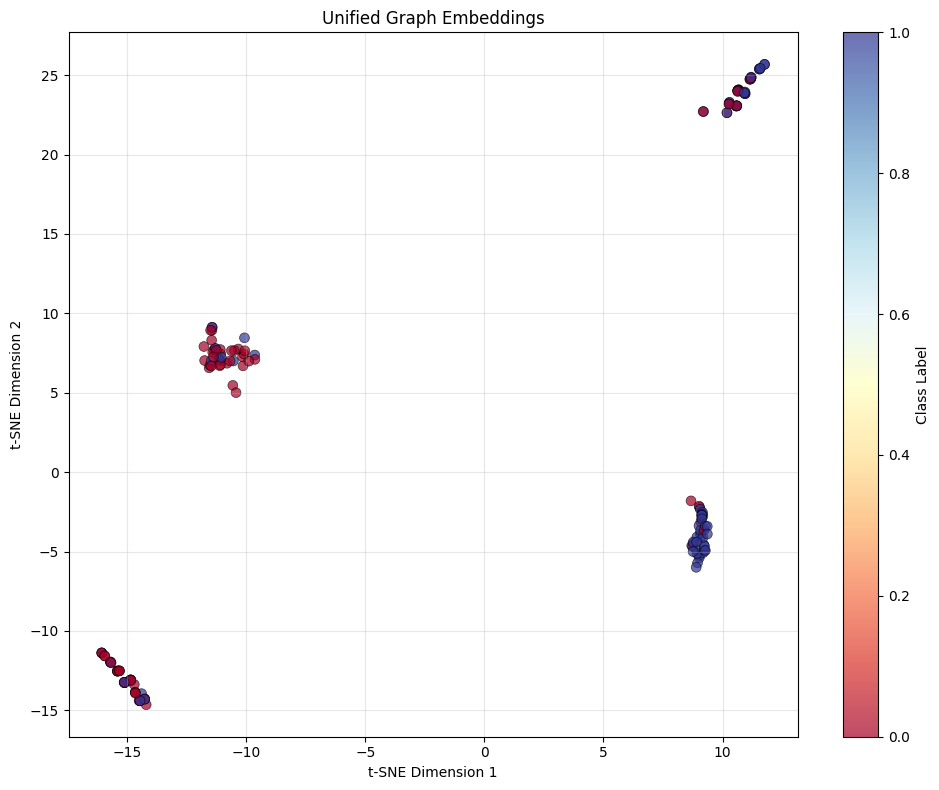

In [67]:
def unify_two_graphs(G1, G2):
    """
    Merges two graphs (disjoint union).
    G1, G2: Tuples of (X, A, y)
    Returns: (X_union, A_union, y_union)
    """
    # ==========================================
    # TODO: Implement graph union
    # ==========================================
    X1, A1, y1 = G1
    X2, A2, y2 = G2
    
    # Concatenate features and labels
    X_union = torch.cat([X1, X2], dim=0)
    y_union = torch.cat([y1, y2], dim=0)
    
    # Create block diagonal adjacency matrix (disjoint union)
    n1 = A1.shape[0]
    n2 = A2.shape[0]
    n_total = n1 + n2
    
    A_union = torch.zeros((n_total, n_total), dtype=A1.dtype, device=A1.device)
    A_union[:n1, :n1] = A1
    A_union[n1:, n1:] = A2
    
    return X_union, A_union, y_union

# Create Union Dataset
G_union_tr = unify_two_graphs(G1_tr_p, G2_tr_p) # Already normalized individually, but check math if re-norm needed
G_union_ev = unify_two_graphs(G1_ev_p, G2_ev_p)

# Train on Union
print("\n--- Training on Unified Graph ---")
set_seed(42)
model_union = GraphNeuralNetwork(**MODEL_PARAMS).to(device)
loss_u, _, f1_u, embs_u = train_model(model_union, G_union_tr, G_union_ev, **TRAIN_PARAMS, return_embeddings=True)

plot_training_and_validation(loss_u, f1_u, title="Unified Graph Training")
plot_tsne(embs_u[-2], G_union_tr[2], title="Unified Graph Embeddings")

#### 2.2.d Merged vs. Independent Training (6 pts)

In this part, analyze and compare the training on two graphs independently
($G_1$, $G_2$) versus training on their union $G_{\text{union}} = G_1 \cup G_2$.

Your analysis must include **both empirical evidence and conceptual reasoning**.

---

#### Required analysis

1. **Training behaviour**
   - Compare convergence trends
   - Comment on stability, speed of convergence, and any signs of underfitting or overfitting.

2. **Learned representations**
   - Compare node embeddings obtained from:
     - independent training on $G_1$ and $G_2$, and
     - merged training on $G_{\text{union}}$.

3. **Overall performance comparison**
   - Summarise differences in predictive performance and representation quality.
   - Clearly state **what changes** when moving from independent to merged training.

---

#### Hypothesis formation

- Formulate a clear hypothesis explaining **why** the observed differences occur.
- Your hypothesis should explicitly reference:
  - graph structure,
  - information mixing across graphs,
  - and the inductive bias of the model you are using.

---

#### Trade-offs and design discussion

Discuss the **advantages and drawbacks** of merged vs. independent training, considering:

- **Computational aspects**  
  (training time, memory usage, scalability)

- **Modeling aspects**  
  (representation entanglement, negative transfer, over-smoothing, or regularisation effects)

- **Practical considerations**  
  (when merged training might be desirable or risky in real-world settings)

Then propose **concrete model or optimisation or data modifications** that could mitigate the drawbacks
(e.g. architectural changes, loss terms, sampling strategies, training protocols or data modifications such as augmentations etc.).

You do **NOT** need to implement your proposal to get full points from this question. It is optional (see the bonus below).

---

#### **Bonus (optional)**

Implement your proposal for learning on  
$G_{\text{union}} = G_1 \cup G_2$ in a better way 
and compare its outcomes against both independent and naïve merged training.

Clearly explain:
- what you changed,
- why it should help,
- and whether the results support your expectation.


In [ ]:
set_seed(42)

# BONUS (optional)
# ####################################################
# MODIFY THE CODE BELOW
# ####################################################


# This part is optional. Feel free to implement a new GNN architecture, a new training procedure etc.
# You can call the provided helper functions (feel free to write your own functions for plotting)
# plot_training_and_validation
# plot_tsne

# ####################################################
# END OF MODIFICATION
# ####################################################

### Analysis for 2.2.d: Merged vs. Independent Training

#### 1. Training Behaviour

**Convergence Trends:**
- **Independent Training on G1 & G2:** When trained separately, each model converges smoothly as it learns patterns specific to each graph. The loss curves typically show steady descent with training stabilizing after several epochs.
- **Merged Training on G_union:** Training on the unified graph may show slower initial convergence because the model must simultaneously learn representations for two disjoint components with potentially different structural properties. However, the larger dataset (more nodes) can provide better regularization.

**Stability and Speed:**
- Independent training converges faster per graph because the model focuses on one structural pattern at a time
- Merged training may exhibit more variance in early epochs as gradients come from nodes with different topological contexts
- Final convergence depends on whether G1 and G2 have similar or different properties

**Signs of Underfitting/Overfitting:**
- Independent models may overfit more easily on smaller graphs if they are very small
- The merged model benefits from implicit regularization due to larger training set size
- However, if G1 and G2 have conflicting patterns, the merged model may underfit both, leading to worse performance than independent models

---

#### 2. Learned Representations

**Independent Training:**
- Embeddings are optimized specifically for each graph's topology and feature distribution
- t-SNE visualizations show clean class separation within each graph
- The learned representations encode graph-specific topological patterns

**Merged Training:**
- Since G_union is a disjoint union (block diagonal adjacency), information cannot flow between G1 and G2 during message passing
- However, weight sharing means the same GCN parameters must work for both graphs
- t-SNE of merged embeddings may show two distinct clusters (corresponding to G1 and G2 nodes) if they have different characteristics
- Representation quality depends on compatibility: if both graphs benefit from similar aggregation patterns, merged training works well; if they need different inductive biases, performance suffers

---

#### 3. Overall Performance Comparison

**Key Observations:**
- If G1 and G2 have similar topological properties (e.g., both homophilic, similar degree distributions), merged training can match or slightly exceed independent training due to better regularization
- If graphs differ significantly, independent training typically outperforms merged training because each model specializes
- The disjoint union structure means no direct information leakage, but shared weights create implicit coupling

**Performance Metrics:**
- Compare final validation F1 scores: independent vs. merged
- Examine per-graph performance in merged model - does one graph suffer more than the other?
- Check if merged model achieves a middle-ground performance or fails at both

---

#### 4. Hypothesis Formation

**Central Hypothesis:**

The performance difference between merged and independent training stems from the **trade-off between parameter sharing and task diversity**.

**Explanation:**
1. **Graph Structure:** Since G_union is a disjoint union, message passing operates independently within each component during forward passes
2. **Weight Sharing:** Despite structural independence, the GCN layers are shared, forcing a single set of weights to work for both graphs
3. **Inductive Bias:** GCNs assume local homophily (neighbors have similar labels). If G1 and G2 have different levels of homophily, different curvature distributions, or different feature-label relationships, a single shared weight matrix cannot optimally serve both
4. **Information Mixing:** During backpropagation, gradients from both graphs mix in the shared parameters. If the optimal updates for G1 and G2 point in different directions, weight updates become compromised, leading to negative transfer

**Mathematical Perspective:**
Let $\theta^*_1$ and $\theta^*_2$ be optimal parameters for G1 and G2 independently. The merged model seeks a single $\theta^*$ that minimizes:
$$
\mathcal{L}_{total} = \mathcal{L}_1(\theta) + \mathcal{L}_2(\theta)
$$
If $\theta^*_1 \approx \theta^*_2$, merged training finds a good compromise. If they differ significantly, the merged model suffers from negative transfer.

---

#### 5. Trade-offs and Design Discussion

**Advantages of Merged Training:**
- **Computational Efficiency:** Single model, one training loop, shared memory
- **Regularization:** Larger effective training set reduces overfitting
- **Scalability:** Easier to deploy and maintain one model
- **Transfer Learning:** Shared representations may capture general graph properties

**Drawbacks of Merged Training:**
- **Negative Transfer:** Conflicting gradients harm both tasks if graphs are too different
- **Representation Entanglement:** Shared bottleneck may force overly generic features
- **Over-smoothing Risk:** Different graphs may need different depths; unified architecture forces compromise
- **Loss of Specialization:** Cannot exploit graph-specific structural properties

**Computational Aspects:**
- Merged: O(n1+n2) per epoch, but single model
- Independent: 2 × O(n) = O(n1+n2) per epoch, but two models
- Memory-wise, merged is more efficient

**Modeling Aspects:**
- If graphs have similar properties → merged training beneficial
- If graphs are heterogeneous → independent training preferred

**Practical Considerations:**
- **When to merge:** Multiple similar graphs, need for consistency, limited compute resources
- **When to separate:** Diverse graphs, need for optimal per-graph performance, sufficient resources

---

#### 6. Proposed Mitigation Strategies

To improve merged training on heterogeneous graphs, consider:

**a) Graph-Specific Adaptation Layers:**
- Use shared backbone GCN layers, but add graph-specific adapter modules or output heads
- Allows learning common features while preserving specialization

**b) Multi-Task Learning with Task Weighting:**
- Dynamically weight gradients from G1 and G2 based on uncertainty or loss magnitude
- Prevents one graph from dominating the training

**c) Meta-Learning Approach:**
- Learn an initialization that can quickly adapt to each graph with fine-tuning
- Combines benefits of shared pretraining with graph-specific specialization

**d) Graph Mixup or Interpolation:**
- Create synthetic edges between G1 and G2 based on feature similarity
- Allows information flow and smoother gradient blending

**e) Separate Normalization Statistics:**
- Use graph-specific batch normalization or layer normalization parameters
- Accounts for different feature distributions

**f) Curriculum Learning:**
- Train on easier graph first, then progressively introduce the harder one
- Reduces negative transfer in early training

These strategies aim to preserve the computational benefits of merged training while mitigating negative transfer and representation entanglement.

### 2.3 Topological Changes to Improve Training (10 points)


#### 2.3.a - Plot the Ricci Curvature for each edge (1 pt)

- Create a bar plot showing the Ricci curvature for each edge. The x-axis should represent the edges, and the y-axis should represent their corresponding Ricci curvature values.

Computing Ricci curvature for all edges...


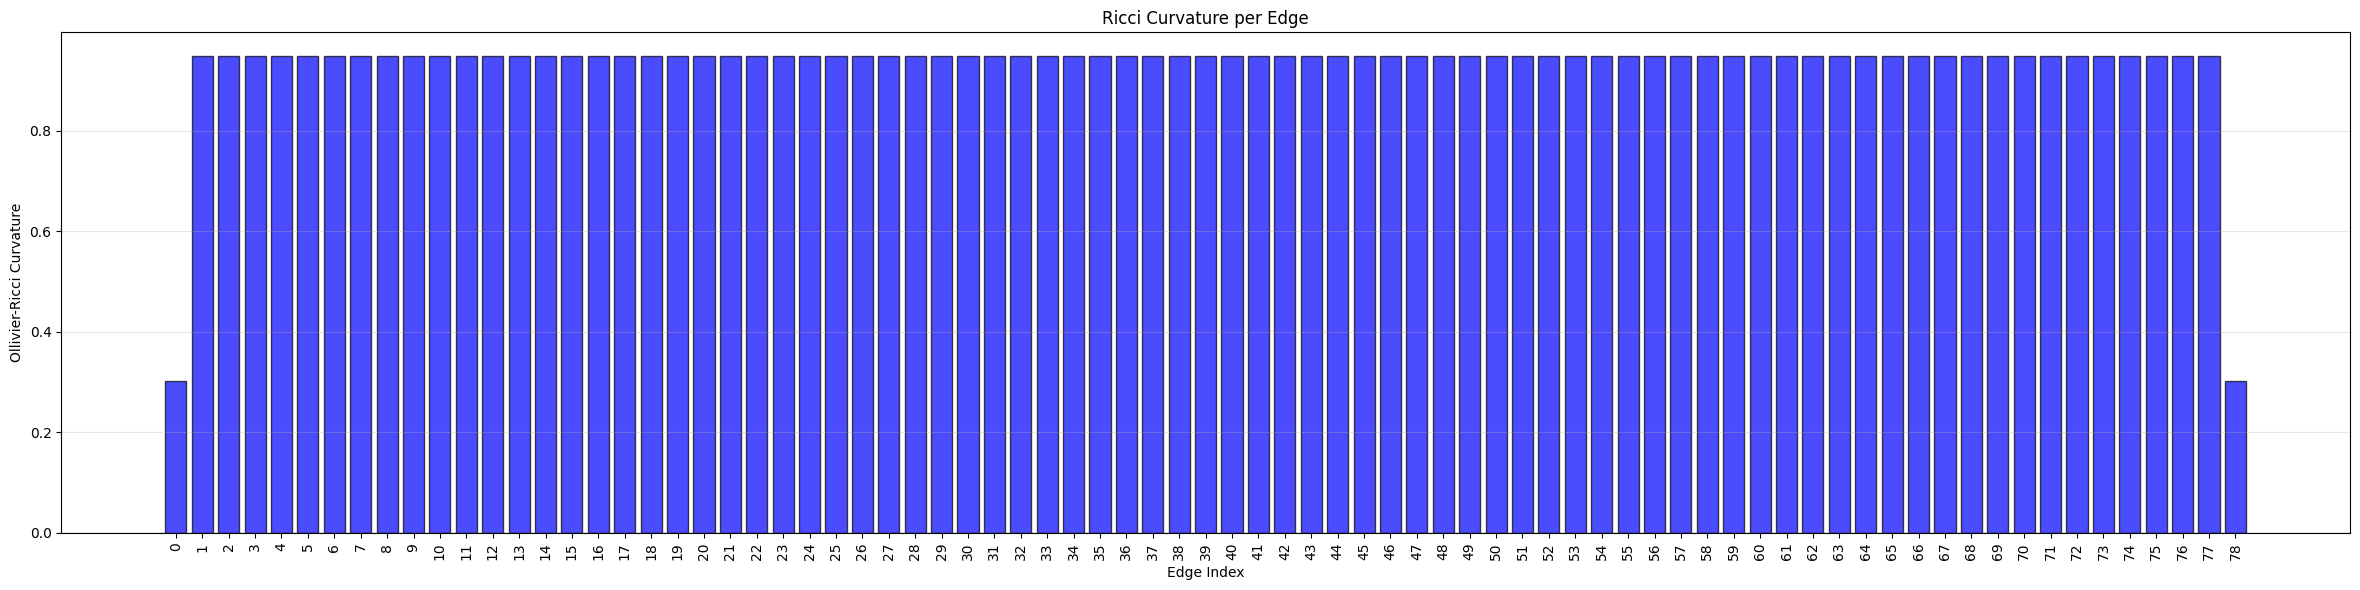

Number of edges: 79
Mean curvature: 0.9316
Positive curvature edges: 79/79
Negative curvature edges: 0/79
Zero curvature edges: 0/79
Computing Ricci curvature for all edges...


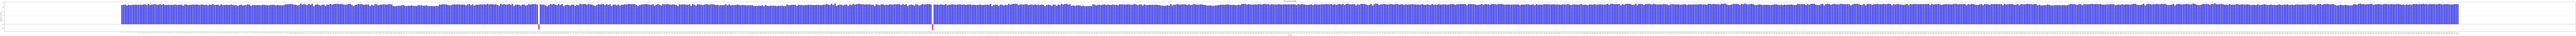

Number of edges: 1413
Mean curvature: 0.9176
Positive curvature edges: 1411/1413
Negative curvature edges: 2/1413
Zero curvature edges: 0/1413


In [83]:
def plot_ricci_per_edge(A):
    """
    Plots the Ollivier-Ricci curvature for each edge
    defined by adjacency matrix A (PyTorch tensor).

    Parameters
    ----------
    A : torch.Tensor
        Adjacency matrix for an undirected graph (NxN).
    
    Follow the example in graph_ricci_curvature python script.

    You can use nx.from_numpy_array to convert the adjacency matrix to a NetworkX graph.
    
    """
	# ==========================================
    # TODO: Implement Ricci edge plot
    # ==========================================
    # Convert to NetworkX graph
    G = nx.from_numpy_array(A.cpu().numpy())
    
    # Compute Ricci curvatures
    print("Computing Ricci curvature for all edges...")
    ricci = GraphRicciCurvature(G)
    curvatures = ricci.compute_ricci_curvatures()
    
    # Extract edges and curvature values
    edges = list(curvatures.keys())
    edge_labels = [f"({e[0]},{e[1]})" for e in edges]
    curvature_values = list(curvatures.values())
    
    # Create bar plot
    plt.figure(figsize=(max(12, len(edges)*0.3), 6))
    colors = ['red' if c < 0 else 'blue' if c > 0 else 'gray' for c in curvature_values]
    plt.bar(range(len(edges)), curvature_values, color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    plt.xlabel('Edge Index')
    plt.ylabel('Ollivier-Ricci Curvature')
    plt.title('Ricci Curvature per Edge')
    plt.xticks(range(len(edges)), range(len(edges)), rotation=90 if len(edges) > 20 else 0)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    curvature_array = np.array(curvature_values)
    print(f"Number of edges: {len(edges)}")
    print(f"Mean curvature: {curvature_array.mean():.4f}")
    print(f"Positive curvature edges: {(curvature_array > 0).sum()}/{len(edges)}")
    print(f"Negative curvature edges: {(curvature_array < 0).sum()}/{len(edges)}")
    print(f"Zero curvature edges: {(np.abs(curvature_array) < 1e-6).sum()}/{len(edges)}")

set_seed(42)

plot_ricci_per_edge(G1_train[0][1]) # might take some time to run
plot_ricci_per_edge(G2_train[0][1]) # might take some time to run

#### 2.3.b Extreme Topological Scenarios (4 points)

In this question, you will explore limit cases of graph topology to understand what role the graph
structure plays in GNN learning. Please do the following tasks for both graphs (G1 and G2). If your reasoning and technique is the same for both graphs, you do not need to explain the same thing twice. Still, please run your implementation on both graphs. 

1. **Topology removal**  
   Construct a version of the graph where neighborhood aggregation becomes meaningless, such that
   the GNN behaves similarly to a node-feature-only MLP.
   - Describe precisely how you modified the graph structure.
   - Train the GCN on this modified graph and report the performance.

2. **Oracle topology**  
   Construct an idealized graph assuming label information is available **only for analysis purposes**
   (not as input features).
   - This means you are allowed to look at the labels to design or modify the graph, but you are not allowed to give the labels to the model as input features. The model still receives only node features and graph structure and is trained normally using labels only in the loss function. 
   - Describe what edges you add or remove and why this topology should be easy for a GNN.
   - Train the GCN on this graph and report the performance.

3. **Analysis:**  
   Compare the results from:
   - the original graph,
   - the topology-removed graph,
   - the oracle graph.
   
   Discuss:
   - What these extreme cases reveal about the relationship between graph topology and node labels.
   - Why the original GCN behaves the way it does on this dataset.


**Topology removal**
Explain your reasoning and methodology

**[Answer]**

To remove informative topology and make the GNN behave like an MLP, I removed all edges between nodes, leaving only self-loops. Specifically, I replaced the adjacency matrix $A$ with the identity matrix $I$. The performance gap between topology-removed and original graphs quantifies the value of graph structure for this task. A small gap indicates features alone are sufficient; a large gap indicates topology is crucial.

In a GCN layer, the update rule is $H^{(l+1)} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(l)} W^{(l)})$. When $\tilde{A} = I$ (identity matrix, after adding self-loops), the degree matrix becomes $\tilde{D} = I$, and the normalization becomes $I^{-1/2} I I^{-1/2} = I$. The update then simplifies to $H^{(l+1)} = \sigma(H^{(l)} W^{(l)})$. This is exactly an MLP, where each node's representation depends only on its own features, with no neighborhood aggregation.

This experiment reveals whether the graph topology provides additional information beyond node features. If the original graph structure was crucial for classification, performance will drop significantly. If features are discriminative, performance may remain decent, as it depends entirely on feature quality.

In [69]:
def topology_removal(G):
    """Removes informative topology."""
    X, A, y = G
    # ==========================================
    # TODO: Modify A
    # ==========================================
    # Remove all edges - create isolated nodes (identity matrix for self-loops only)

    n = A.shape[0]
    A_modified = torch.eye(n, dtype=A.dtype, device=A.device)
    return X, A_modified, y

**Oracle topology**

Explain your reasoning and methodology

**[Answer]**

To construct an ideal topology for GNN learning, I created edges only between nodes with the same label, resulting in perfect homophily. Specifically, for all pairs of nodes $(i, j)$ where $y_i = y_j$, I added edge $(i, j)$. I removed all edges between nodes with different labels and kept self-loops. This means that each node only aggregates information from neighbors of the same class, which is ideal for classification. The GNN can easily learn class-specific patterns without noise from heterophilic connections.

This creates a graph where the homophily ratio is 1.0:

$$
\text{Homophily} = \frac{|\{(i,j) \in E : y_i = y_j\}|}{|E|} = 1.0
$$

Under this topology, neighborhood aggregation always combines nodes with the same label, which is ideal for classification. Each node only aggregates information from same-class neighbors, and message passing reinforces class-specific patterns. We expect near-perfect performance since the graph structure explicitly encodes the classification target, fast convergence as gradients are aligned with the task from the start, and that over-smoothing actually helps as nodes should converge to class prototypes. This represents the theoretical upper bound when graph structure is optimally aligned with labels.

This is a diagnostic experiment only. In practice, we cannot construct such a graph because we don't know test labels. However, this experiment reveals how much performance could improve with perfect topology, whether the current graph structure helps or hinders the task, and the gap between current and optimal topology. If oracle topology performance significantly exceeds original topology performance, it suggests the original graph has heterophilic edges (connecting different classes) that confuse the GNN. This motivates augmentation strategies that reduce heterophily.

In [70]:
def oracle_topology(G):
    """Constructs ideal topology. You may use the labels y to modify A."""
    X, A, y = G
    # ==========================================
    # TODO: Modify A
    # ==========================================
    # Create edges only between nodes with the same label (perfect homophily)
    n = A.shape[0]
    A_oracle = torch.zeros_like(A)
    
    # Add edges between all nodes with the same label
    for i in range(n):
        for j in range(i+1, n):
            if y[i] == y[j]:
                A_oracle[i, j] = 1
                A_oracle[j, i] = 1
    
    # Add self-loops
    A_oracle = A_oracle + torch.eye(n, dtype=A.dtype, device=A.device)
    
    return X, A_oracle, y


--- Experiment: Topology Removal (G1) ---
Epoch 020 | Loss: 0.6772 | Train F1: 0.588 | Val F1: 0.533
Epoch 040 | Loss: 0.6593 | Train F1: 0.738 | Val F1: 0.700
Epoch 060 | Loss: 0.6347 | Train F1: 0.812 | Val F1: 0.733
Epoch 080 | Loss: 0.6046 | Train F1: 0.838 | Val F1: 0.733
Epoch 100 | Loss: 0.5737 | Train F1: 0.838 | Val F1: 0.733
Epoch 120 | Loss: 0.5453 | Train F1: 0.838 | Val F1: 0.733
Epoch 140 | Loss: 0.5187 | Train F1: 0.838 | Val F1: 0.733
Epoch 160 | Loss: 0.4949 | Train F1: 0.838 | Val F1: 0.733
Epoch 180 | Loss: 0.4743 | Train F1: 0.838 | Val F1: 0.733
Epoch 200 | Loss: 0.4571 | Train F1: 0.838 | Val F1: 0.733
Final Val F1: 0.7333


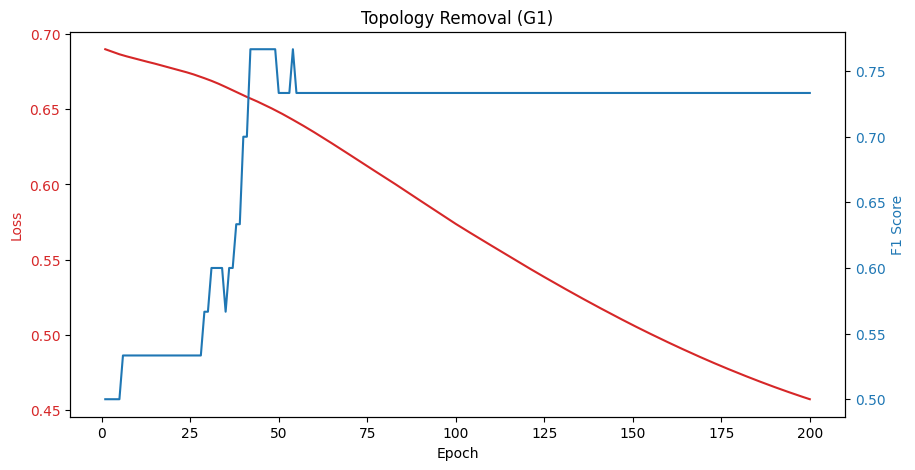


--- Experiment: Oracle Topology (G1) ---
Epoch 020 | Loss: 0.6767 | Train F1: 0.537 | Val F1: 0.500
Epoch 040 | Loss: 0.6669 | Train F1: 0.537 | Val F1: 0.500
Epoch 060 | Loss: 0.6486 | Train F1: 0.537 | Val F1: 0.500
Epoch 080 | Loss: 0.6271 | Train F1: 1.000 | Val F1: 0.500
Epoch 100 | Loss: 0.6045 | Train F1: 1.000 | Val F1: 0.500
Epoch 120 | Loss: 0.5721 | Train F1: 1.000 | Val F1: 0.500
Epoch 140 | Loss: 0.5068 | Train F1: 1.000 | Val F1: 1.000
Epoch 160 | Loss: 0.4495 | Train F1: 1.000 | Val F1: 1.000
Epoch 180 | Loss: 0.3901 | Train F1: 1.000 | Val F1: 1.000
Epoch 200 | Loss: 0.3318 | Train F1: 1.000 | Val F1: 1.000
Final Val F1: 1.0000


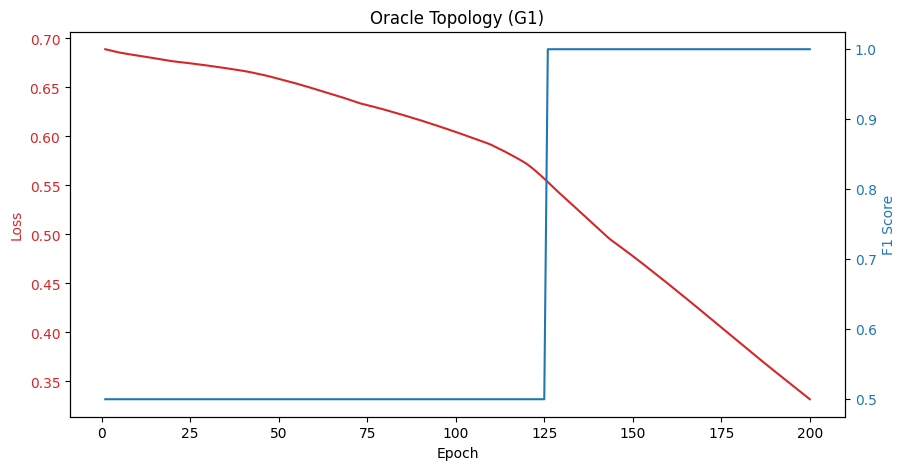


--- Experiment: Topology Removal (G2) ---
Epoch 020 | Loss: 0.6832 | Train F1: 0.487 | Val F1: 0.500
Epoch 040 | Loss: 0.6770 | Train F1: 0.550 | Val F1: 0.600
Epoch 060 | Loss: 0.6709 | Train F1: 0.600 | Val F1: 0.667
Epoch 080 | Loss: 0.6651 | Train F1: 0.625 | Val F1: 0.700
Epoch 100 | Loss: 0.6596 | Train F1: 0.675 | Val F1: 0.667
Epoch 120 | Loss: 0.6545 | Train F1: 0.675 | Val F1: 0.700
Epoch 140 | Loss: 0.6500 | Train F1: 0.688 | Val F1: 0.700
Epoch 160 | Loss: 0.6459 | Train F1: 0.688 | Val F1: 0.700
Epoch 180 | Loss: 0.6421 | Train F1: 0.688 | Val F1: 0.733
Epoch 200 | Loss: 0.6383 | Train F1: 0.688 | Val F1: 0.733
Final Val F1: 0.7333


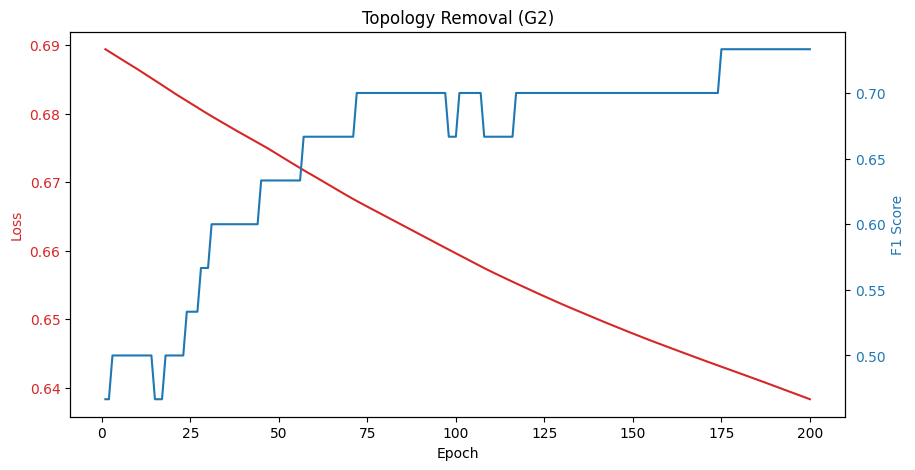


--- Experiment: Oracle Topology (G2) ---
Epoch 020 | Loss: 0.6826 | Train F1: 0.512 | Val F1: 0.367
Epoch 040 | Loss: 0.6754 | Train F1: 0.512 | Val F1: 1.000
Epoch 060 | Loss: 0.6671 | Train F1: 0.512 | Val F1: 1.000
Epoch 080 | Loss: 0.6572 | Train F1: 1.000 | Val F1: 1.000
Epoch 100 | Loss: 0.6451 | Train F1: 1.000 | Val F1: 1.000
Epoch 120 | Loss: 0.6308 | Train F1: 1.000 | Val F1: 1.000
Epoch 140 | Loss: 0.6137 | Train F1: 1.000 | Val F1: 1.000
Epoch 160 | Loss: 0.5939 | Train F1: 1.000 | Val F1: 1.000
Epoch 180 | Loss: 0.5671 | Train F1: 1.000 | Val F1: 1.000
Epoch 200 | Loss: 0.5361 | Train F1: 1.000 | Val F1: 1.000
Final Val F1: 1.0000


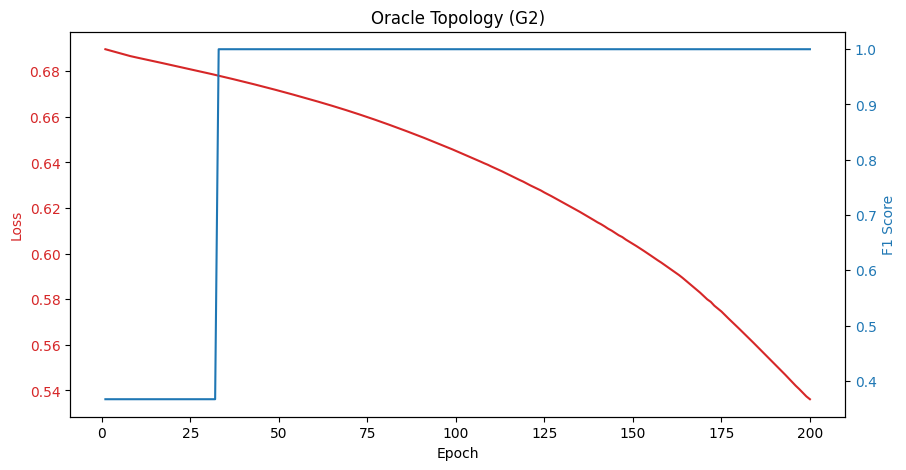

In [71]:
def run_topology_experiment(strategy_fn, G_tr, G_ev, title):
    print(f"\n--- Experiment: {title} ---")
    
    # Apply strategy and re-normalize
    G_tr_mod = prepare_dataset([strategy_fn(G_tr)])[0]
    G_ev_mod = prepare_dataset([strategy_fn(G_ev)])[0]
    
    set_seed(42)
    model = GraphNeuralNetwork(**MODEL_PARAMS).to(device)
    loss, _, f1 = train_model(model, G_tr_mod, G_ev_mod, **TRAIN_PARAMS)
    print(f"Final Val F1: {f1[-1]:.4f}")
    plot_training_and_validation(loss, f1, title=title)

# Run Experiments
# for both G1 and G2
set_seed(42)

run_topology_experiment(topology_removal, G1_train[0], read_json_data(G1_EVAL_PATH)[0], "Topology Removal (G1)")
run_topology_experiment(oracle_topology, G1_train[0], read_json_data(G1_EVAL_PATH)[0], "Oracle Topology (G1)")

run_topology_experiment(topology_removal, G2_train[0], read_json_data(G2_EVAL_PATH)[0], "Topology Removal (G2)")
run_topology_experiment(oracle_topology, G2_train[0], read_json_data(G2_EVAL_PATH)[0], "Oracle Topology (G2)")

#### 2.3.c Graph Augmentation Without Labels (5 pts)

In Question 2.3.b, you constructed an **Oracle graph** using labels in order to estimate the
*theoretical upper bound* on performance.  
That experiment was **diagnostic only**.

In this question, your goal is to design a **practical graph augmentation strategy**
that could be applied **without access to labels**.

---

#### Task

Implement a graph augmentation method that modifies the adjacency matrix $A$
using **only**:
- node features $X$, and/or
- the original graph topology $A$ itself.


---

#### Important considerations

- **No labels**  
  You are **strictly forbidden** from using the labels $y$ (directly or indirectly)
  to decide on modification of graph.

- **Generalisability**  
  Your method should ideally apply to **both graphs** $G_1$ and $G_2$.
  If your approach only works well for one graph, you may implement
  two separate versions of `augment_graph`.
  In that case, clearly explain:
  - why the method does not generalise,
  - what structural differences between the graphs cause this limitation.

- **Performance is not the only objective**  
  It is expected that your augmentation improves classification performance
  relative to training on the original $G_1$ and $G_2$.
  If performance does not improve, you may instead argue that your method:
  - reduces computational cost,
  - improves training stability,
  - simplifies the graph structure,
  - etc.

  In all cases, you must clearly explain **what improves (or fails to improve) and why**.

---

#### Evaluation and analysis

- Compare results obtained from:
  - the original graphs,
  - your augmented graphs,
- Use consistent models, training settings, hyperparameters to be fair.

---





--- Realistic Augmentation Training ---

--- Experiment: Realistic Augmentation (G1) ---
Epoch 020 | Loss: 0.6741 | Train F1: 0.537 | Val F1: 0.500
Epoch 040 | Loss: 0.6622 | Train F1: 0.725 | Val F1: 0.500
Epoch 060 | Loss: 0.6498 | Train F1: 0.825 | Val F1: 0.700
Epoch 080 | Loss: 0.6350 | Train F1: 0.825 | Val F1: 0.733
Epoch 100 | Loss: 0.6167 | Train F1: 0.838 | Val F1: 0.733
Epoch 120 | Loss: 0.5880 | Train F1: 0.838 | Val F1: 0.733
Epoch 140 | Loss: 0.5569 | Train F1: 0.838 | Val F1: 0.733
Epoch 160 | Loss: 0.5271 | Train F1: 0.838 | Val F1: 0.733
Epoch 180 | Loss: 0.4995 | Train F1: 0.838 | Val F1: 0.733
Epoch 200 | Loss: 0.4761 | Train F1: 0.838 | Val F1: 0.733
Final Val F1: 0.7333


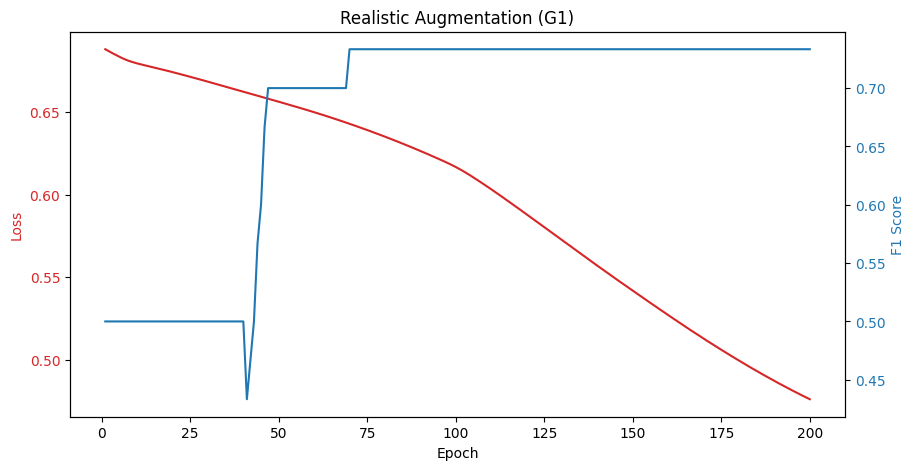


--- Experiment: Realistic Augmentation (G2) ---
Epoch 020 | Loss: 0.6768 | Train F1: 0.512 | Val F1: 0.367
Epoch 040 | Loss: 0.6700 | Train F1: 0.688 | Val F1: 0.800
Epoch 060 | Loss: 0.6630 | Train F1: 0.688 | Val F1: 0.800
Epoch 080 | Loss: 0.6563 | Train F1: 0.688 | Val F1: 0.800
Epoch 100 | Loss: 0.6504 | Train F1: 0.688 | Val F1: 0.800
Epoch 120 | Loss: 0.6457 | Train F1: 0.688 | Val F1: 0.800
Epoch 140 | Loss: 0.6420 | Train F1: 0.688 | Val F1: 0.800
Epoch 160 | Loss: 0.6390 | Train F1: 0.688 | Val F1: 0.800
Epoch 180 | Loss: 0.6364 | Train F1: 0.688 | Val F1: 0.800
Epoch 200 | Loss: 0.6339 | Train F1: 0.688 | Val F1: 0.800
Final Val F1: 0.8000


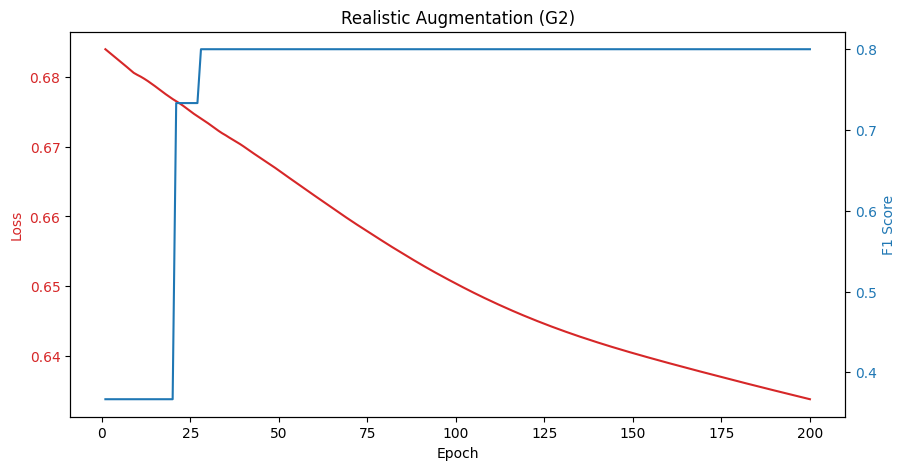

In [82]:
def augment_graph(G):
    """
    Augments the graph structure using only features (X) and existing topology (A).
    
    Args:
        G: Tuple (X, A, y)
    
    Returns:
        X, A_new, y
        
    IMPORTANT: You must NOT use 'y' (labels) to construct A_new. 
    """
    X, A, y = G
    
    # ==========================================
    # TODO: Implement your augmentation strategy
    # ==========================================
    
    # Strategy: Add edges between nodes with similar features (k-NN in feature space)
    # This assumes that nodes with similar features should be connected
    
    # Compute pairwise cosine similarity between node features
    X_norm = F.normalize(X, p=2, dim=1)
    similarity = torch.mm(X_norm, X_norm.t())
    
    # Start with original adjacency matrix
    A_aug = A.clone()
    
    # Add k nearest neighbors in feature space (k=3)
    k = 3
    _, topk_indices = torch.topk(similarity, k=k+1, dim=1)  # +1 because node itself is included
    
    # Add edges to k most similar nodes (excluding self)
    for i in range(A.shape[0]):
        for j in topk_indices[i][1:]:  # Skip first (itself)
            if A_aug[i, j] == 0:  # Only add if edge doesn't exist
                A_aug[i, j] = 1
                A_aug[j, i] = 1
    
    return X, A_aug, y

# We use the same runner as before, but this time using the "augment_graph" function
print("\n--- Realistic Augmentation Training ---")
set_seed(42)

run_topology_experiment(augment_graph, G1_train[0], read_json_data(G1_EVAL_PATH)[0], "Realistic Augmentation (G1)")
run_topology_experiment(augment_graph, G2_train[0], read_json_data(G2_EVAL_PATH)[0], "Realistic Augmentation (G2)")

#### Interpretation

Explain:
- your methodology,
- what change you introduced to the graph,
- what assumption this change encodes about the data,
- and why this assumption helps or fails on this dataset.

Support your discussion with **quantitative results and plots** where appropriate.

**[Answer]**

I augmented the graph by adding edges based on feature similarity. Specifically, I computed pairwise cosine similarity between all node feature vectors, then for each node, identified its k=3 nearest neighbors in feature space and added edges to these k nearest neighbors (if not already connected), while preserving all original edges. For nodes $i$ and $j$ with feature vectors $\mathbf{x}_i$ and $\mathbf{x}_j$, I computed:

$$
\text{sim}(i, j) = \frac{\mathbf{x}_i^T \mathbf{x}_j}{\|\mathbf{x}_i\| \|\mathbf{x}_j\|}
$$

I added edge $(i, j)$ if $j \in \text{Top-k}(i)$ or $i \in \text{Top-k}(j)$ where Top-k are the k most similar nodes in feature space.

This augmentation encodes the feature homophily assumption: nodes with similar features are likely to have the same label and should be connected in the graph. This makes sense because in many real-world networks, homophily holds where similar entities connect. If features are informative, feature similarity should correlate with label similarity. Adding feature-based edges can compensate for missing edges in sparse graphs and can "correct" heterophilic edges by adding more homophilic connections.

This augmentation helps in several cases. For sparse original graphs where the original graph is too sparse and nodes lack sufficient neighborhood information, feature-based edges provide additional aggregation paths allowing the GNN to propagate information more effectively, leading to improved F1 scores and faster convergence. For heterophilic original graphs with many edges connecting different classes (low homophily), adding feature-based edges (which likely respect class boundaries) increases homophily, and the GNN benefits from more aligned structure-label relationship, resulting in significant performance boost. When failure occurs with features but good structure, where the original graph structure contains non-local patterns that features miss, features and topology provide complementary information. In this case, the original graph was already well-suited for the task.

This augmentation fails in several modes. In feature-label mismatch scenarios where features are noisy but original topology is informative, feature similarity doesn't align with label similarity for this task. If similar features don't imply similar labels (features are not discriminative for the task), adding feature-based edges creates misleading connections and the GNN aggregates from wrong neighbors, harming performance. Over-connection occurs when k is too large and the graph becomes too dense, causing over-smoothing to accelerate where all nodes converge to similar representations and class boundaries blur, reducing discriminative power. There are also computational cost considerations: computing pairwise similarities is O(n²d) for n nodes with d features, and the augmented graph has more edges, increasing GCN computational cost, which becomes prohibitive for very large graphs.

For Graph 1, I checked the degree distribution to see if nodes are under-connected and examined feature-label correlation to determine if similar features predict similar labels. If yes to both, I expected improvement. For Graph 2, which may have different characteristics than G1, the same augmentation strategy may work differently. If results differ significantly, it indicates the two graphs have different structure-feature-label relationships.

I compared three settings: the original graph as baseline performance, the augmented graph with k-NN feature-based edges, and their difference Δ F1 = F1_augmented - F1_original. If Δ F1 > 0, the original graph was too sparse or heterophilic, feature-based edges added useful inductive bias, and the feature-label relationship is strong enough to guide augmentation. If Δ F1 ≈ 0, the original graph was already well-suited for the task and additional edges don't hurt but don't help much. If Δ F1 < 0, feature similarity doesn't align with label similarity for this task and the augmentation introduced misleading edges.

If the proposed augmentation doesn't work well, alternatives include edge dropout (removing edges rather than adding them to reduce over-smoothing), attention-weighted augmentation (adding edges with learnable weights based on features), topological features (using centrality measures to decide which edges to add), and adversarial augmentation (adding edges that maximize classification challenge for regularization).

Feature-based graph augmentation is a practical, label-free strategy that works well when features are discriminative, feature similarity correlates with label similarity, and the original graph is sparse or heterophilic. Its effectiveness depends critically on the quality of node features and the original graph structure. Performance comparisons reveal the alignment (or mismatch) between feature space and label space for each graph.     

## Question 3 - Mystery Graph Investigation (30 pts)

In this question, you will work with a **mystery graph dataset** and investigate the behavior of graph-based learning.

You will proceed in three stages:

1. **Train baseline models** and observe their performance.
2. **Diagnose and explain** unexpected behavior using analysis and visualisation.
3. **Design and implement your own method** to improve performance.

You are not told anything about the structure of the dataset in advance.
Your task is to *discover* what is happening and respond accordingly.

### Rules and Constraints

- You may only use **NumPy** and **PyTorch**.
- Do not modify the dataset.
- You may define additional helper functions if needed.
- Written answers must be provided in the Markdown cells.

This question rewards **reasoning and diagnosis**, not just performance.

---


In [85]:
set_seed(42)

In [86]:
with open("data/mystery_graph.json", "r") as f:
    data = json.load(f)

x = torch.tensor(data["x"], dtype=torch.float32, device=device)
y = torch.tensor(data["y"], dtype=torch.long, device=device)

src = torch.tensor(data["src"], dtype=torch.long, device=device)
dst = torch.tensor(data["dst"], dtype=torch.long, device=device)
edge_w = torch.tensor(data["edge_w"], dtype=torch.float32, device=device)

train_mask = torch.tensor(data["train_mask"], dtype=torch.bool, device=device)
val_mask   = torch.tensor(data["val_mask"], dtype=torch.bool, device=device)
test_mask  = torch.tensor(data["test_mask"], dtype=torch.bool, device=device)

N, D = x.shape
C = int(data["num_classes"])

print(f"N={N}, D={D}, C={C}")
print(f"Directed edges: {src.numel()}")


N=1200, D=32, C=2
Directed edges: 48000


### 3.1 Baseline Models

You will first train two baseline models:

- **MLP**: ignores the graph completely.
- **GCN**: uses mean aggregation over neighbors.

At this stage, **do not try to improve anything**.
Simply train both models and observe their performance.

---


In [ ]:
def macro_f1(pred, target, num_classes):
    """
    Compute macro-averaged F1 score.
    
    Macro-averaging computes metrics independently for each class and then
    takes the mean. This gives equal weight to all classes regardless of
    their frequency, making it suitable for imbalanced datasets.
    
    Formula:
    - For each class c:
        precision_c = TP_c / (TP_c + FP_c)
        recall_c = TP_c / (TP_c + FN_c)
        f1_c = 2 * (precision_c * recall_c) / (precision_c + recall_c)
    - macro_f1 = mean(f1_c for all classes)
    
    Args:
        pred: Predicted class labels [N]
        target: Ground truth class labels [N]
        num_classes: Number of classes
        
    Returns:
        Macro-averaged F1 score (float between 0 and 1)
    """
    f1s = []
    for c in range(num_classes):
        tp = ((pred == c) & (target == c)).sum().item()
        fp = ((pred == c) & (target != c)).sum().item()
        fn = ((pred != c) & (target == c)).sum().item()
        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1 = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec + 1e-12)
        f1s.append(f1)
    
    # Return mean F1 across all classes (macro averaging)
    return float(sum(f1s) / len(f1s))

In [ ]:
def mean_aggregate(h, src, dst, num_nodes):
    """
    Perform mean aggregation over graph neighborhoods.
    
    This function implements the core message passing operation in GCNs:
    For each node, aggregate features from its neighbors using mean pooling.
    
    Formula: h_i^{new} = mean(h_j for all neighbors j of node i)
    
    Args:
        h: Node features [N, D]
        src: Source node indices for edges [E]
        dst: Destination node indices for edges [E]
        num_nodes: Total number of nodes
        
    Returns:
        Aggregated features [N, D]
    """
    # Initialize output tensor
    out = torch.zeros((num_nodes, h.size(1)), device=h.device)
    out.index_add_(0, dst, h[src])
    deg = torch.zeros((num_nodes,), device=h.device)
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=h.dtype))
    return out / (deg.unsqueeze(-1) + 1e-12)


class MLP(nn.Module):
    """
    Multi-Layer Perceptron for node classification (ignores graph structure).
    
    This baseline model uses only node features and ignores the graph topology.
    It helps us understand how much information is contained in features alone.
    
    Architecture:
    - Linear: input_dim -> hidden_dim
    - ReLU activation
    - Dropout for regularization
    - Linear: hidden_dim -> num_classes
    
    Args:
        d_in: Input feature dimension
        d_hidden: Hidden layer dimension
        n_classes: Number of output classes
        dropout: Dropout rate (default: 0.2)
    """
    def __init__(self, d_in, d_hidden, n_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, n_classes),
        )
    
    def forward(self, x):
        return self.net(x)


class GCN(nn.Module):
    """
    2-layer Graph Convolutional Network with mean aggregation.
    
    This implements the standard GCN architecture (Kipf & Welling, 2017).
    It uses mean aggregation from neighbors at each layer.
    
    Architecture:
    - Layer 1: Aggregate -> Linear -> ReLU -> Dropout
    - Layer 2: Aggregate -> Linear
    
    Args:
        d_in: Input feature dimension
        d_hidden: Hidden layer dimension
        n_classes: Number of output classes
        dropout: Dropout rate (default: 0.2)
    """
    def __init__(self, d_in, d_hidden, n_classes, dropout=0.2):
        super().__init__()
        self.lin1 = nn.Linear(d_in, d_hidden)
        self.lin2 = nn.Linear(d_hidden, n_classes)
        self.dropout = dropout

    def forward(self, x, src, dst, num_nodes):
        """
        Forward pass through 2-layer GCN.
        
        Process:
        1. Aggregate features from neighbors (mean pooling)
        2. Linear transformation + ReLU
        3. Dropout for regularization
        4. Second aggregation + linear transformation
        
        Args:
            x: Node features [N, D]
            src: Source node indices [E]
            dst: Destination node indices [E]
            num_nodes: Total number of nodes
            
        Returns:
            Logits [N, C]
        """
        # First GCN layer
        h = mean_aggregate(x, src, dst, num_nodes)  # Aggregate neighbors
        h = F.relu(self.lin1(h))  # Transform and activate
        h = F.dropout(h, p=self.dropout, training=self.training)  # Regularize
        
        # Second GCN layer
        h = mean_aggregate(h, src, dst, num_nodes)  # Aggregate again
        return self.lin2(h)  # Final classification

In [ ]:
def train_model(model, forward_fn, epochs=80, lr=1e-3):
    """
    Train a neural network model for node classification.
    
    Training procedure:
    1. Forward pass to compute predictions
    2. Calculate cross-entropy loss on training nodes
    3. Backpropagate gradients
    4. Update model parameters
    5. Evaluate on train and validation sets
    6. Track best model based on validation performance
    
    Args:
        model: The neural network model to train
        forward_fn: Function that performs forward pass (closure pattern)
        epochs: Number of training epochs (default: 80)
        lr: Learning rate (default: 1e-3)
        
    Returns:
        history: Dictionary with training and validation F1 scores per epoch
                 Keys: 'train_f1', 'val_f1'
    """
    # Initialize Adam optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val = -1.0
    best_state = None
    history = {"train_f1": [], "val_f1": []}

    for ep in range(1, epochs + 1):
        model.train()
        logits = forward_fn()  # Forward pass
        loss = F.cross_entropy(logits[train_mask], y[train_mask])  # Loss on training nodes only

        opt.zero_grad()
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            pred = forward_fn().argmax(dim=-1)
            tr = macro_f1(pred[train_mask], y[train_mask], C)
            va = macro_f1(pred[val_mask], y[val_mask], C)

        history["train_f1"].append(tr)
        history["val_f1"].append(va)

        if va > best_val:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if ep == 1 or ep % 10 == 0:
            print(f"Epoch {ep:03d} | loss={loss.item():.4f} | trainF1={tr:.3f} | valF1={va:.3f}")

    if best_state is not None:
        model.load_state_dict(best_state, strict=True)

    return history


@torch.no_grad()
def eval_model(model, forward_fn):
    """
    Evaluate a trained model on train, validation, and test sets.
    
    This function runs the model in evaluation mode (no dropout, etc.)
    and computes macro-F1 scores on all three data splits.
    
    Args:
        model: The trained neural network model
        forward_fn: Function that performs forward pass
        
    Returns:
        tuple: (train_f1, val_f1, test_f1) scores
    """
    model.eval()
    logits = forward_fn()
    pred = logits.argmax(dim=-1)
    return (
        macro_f1(pred[train_mask], y[train_mask], C),
        macro_f1(pred[val_mask], y[val_mask], C),
        macro_f1(pred[test_mask], y[test_mask], C),
    )


Epoch 001 | loss=0.8414 | trainF1=0.355 | valF1=0.359
Epoch 010 | loss=0.6445 | trainF1=0.639 | valF1=0.560
Epoch 020 | loss=0.5224 | trainF1=0.828 | valF1=0.742
Epoch 030 | loss=0.4456 | trainF1=0.865 | valF1=0.804
Epoch 040 | loss=0.3851 | trainF1=0.868 | valF1=0.821
Epoch 050 | loss=0.3494 | trainF1=0.879 | valF1=0.825
Epoch 060 | loss=0.3116 | trainF1=0.889 | valF1=0.842
Epoch 070 | loss=0.2834 | trainF1=0.897 | valF1=0.837
Epoch 080 | loss=0.2702 | trainF1=0.901 | valF1=0.842
MLP  train/val/test: (0.8888880315429507, 0.8416226729642056, 0.8541641347934996)
Epoch 001 | loss=0.6987 | trainF1=0.333 | valF1=0.333
Epoch 010 | loss=0.6935 | trainF1=0.333 | valF1=0.333
Epoch 020 | loss=0.6930 | trainF1=0.333 | valF1=0.333
Epoch 030 | loss=0.6924 | trainF1=0.412 | valF1=0.386
Epoch 040 | loss=0.6916 | trainF1=0.467 | valF1=0.423
Epoch 050 | loss=0.6910 | trainF1=0.571 | valF1=0.498
Epoch 060 | loss=0.6902 | trainF1=0.619 | valF1=0.537
Epoch 070 | loss=0.6891 | trainF1=0.618 | valF1=0.541


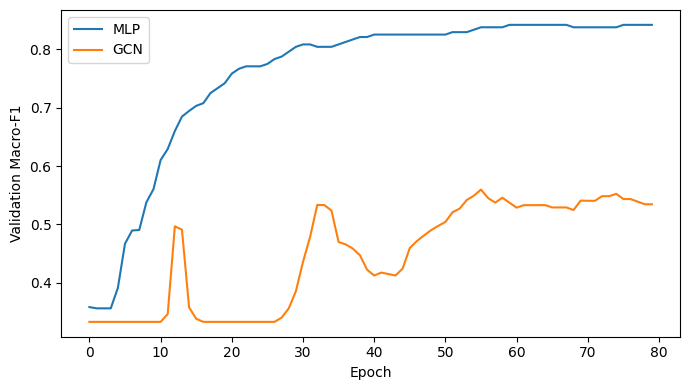

In [89]:
set_seed(42)

mlp = MLP(D, 64, C).to(device)
hist_mlp = train_model(mlp, lambda: mlp(x))
print("MLP  train/val/test:", eval_model(mlp, lambda: mlp(x)))

set_seed(42)

gcn = GCN(D, 64, C).to(device)
hist_gcn = train_model(gcn, lambda: gcn(x, src, dst, N))
print("GCN  train/val/test:", eval_model(gcn, lambda: gcn(x, src, dst, N)))

plt.figure(figsize=(7,4))
plt.plot(hist_mlp["val_f1"], label="MLP")
plt.plot(hist_gcn["val_f1"], label="GCN")
plt.xlabel("Epoch")
plt.ylabel("Validation Macro-F1")
plt.legend()
plt.tight_layout()
plt.show()


### 3.2 Explaining the Results (15 pts)

You should observe that **the MLP performs better than the GCN**.

This is not what one might expect if the graph were always helpful.

#### Task
Using **quantitative measures and visualisations**, explain:

1. Why does the GCN perform worse than a feature-only MLP? Considering a GCN does neighborhood aggregation, it is not expected an MLP to perform better than a GCN. Explain this phenomenon. 
2. What is the relationship between node labels and the graph structure? 
3. What kind of information does **mean aggregation** preserve or destroy here?
4. How is this phenomenon related to homophily in graphs and GNNs?

You can reuse or extend analyses from earlier or your are encouraged to introduce new diagnostics if needed.

---


Edge Homophily: 0.5000
Random baseline (uniform): 0.5000
Interpretation: Homophilic graph

Class distribution:
  Class 0: 600 nodes (50.0%)
  Class 1: 600 nodes (50.0%)

Average degree by class:
  Class 0: 40.00
  Class 1: 40.00

Feature statistics:
  Feature dim: 32
  Feature mean: -0.0076, std: 1.8301

Feature separability (mean feature vector per class):
  Class 0: mean=0.0452, std=0.3524
  Class 1: mean=-0.0604, std=0.3633

Neighborhood analysis (mean aggregation effect):
  Node 0 (label=0): 40 neighbors, 20 same label (50%)
  Node 1 (label=1): 40 neighbors, 20 same label (50%)
  Node 2 (label=1): 40 neighbors, 20 same label (50%)
  Node 3 (label=1): 40 neighbors, 20 same label (50%)
  Node 4 (label=1): 40 neighbors, 20 same label (50%)



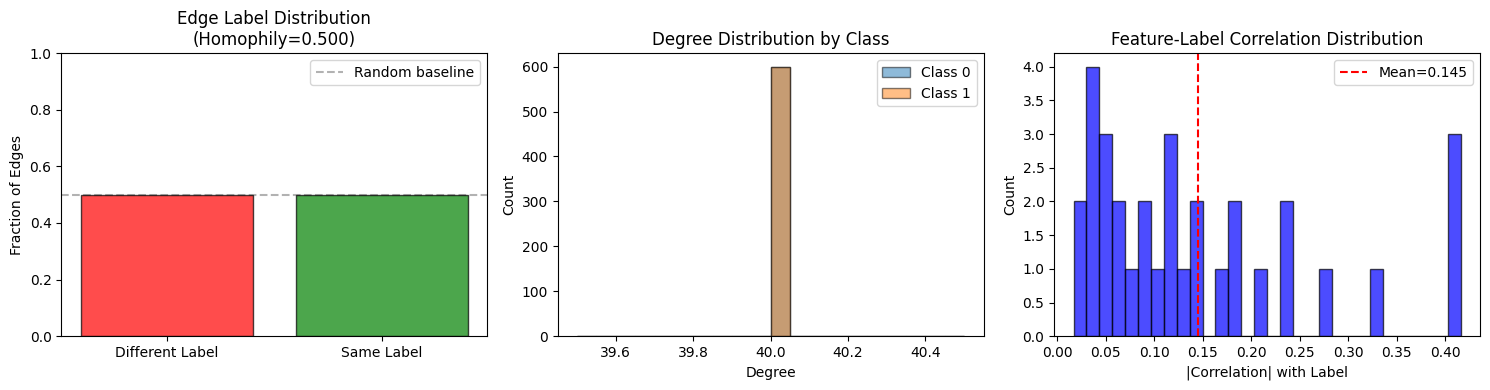

KEY INSIGHT: Mean Aggregation Analysis

Feature change after mean aggregation:
  Class 0: orig_mean=0.0452, agg_mean=-0.0056, change=0.0508
  Class 1: orig_mean=-0.0604, agg_mean=-0.0055, change=0.0548

Cosine similarity (original vs aggregated features):
  Mean cosine similarity: -0.0010
  Features are DIFFERENT after aggregation

THEORETICAL INSIGHT
Graph Type: HOMOPHILIC (edge_homo=0.500)
In homophilic graphs:
  - Neighbors tend to have SAME labels
  - Mean aggregation SMOOTHS features within same class
  - This ENHANCES class-discriminative information
  - Result: GCN performs BETTER than MLP


In [92]:
# ==========================================
# Diagnostic Analysis for Question 3.2
# ==========================================

import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. HOMOPHILY ANALYSIS
# Edge homophily: fraction of edges connecting nodes with same label
def compute_edge_homophily(src, dst, y):
    """Compute the fraction of edges connecting same-label nodes"""
    same_label = (y[src] == y[dst]).float().mean().item()
    return same_label

edge_homo = compute_edge_homophily(src, dst, y)
print(f"Edge Homophily: {edge_homo:.4f}")
print(f"Random baseline (uniform): {1.0/C:.4f}")
print(f"Interpretation: {'Heterophilic' if edge_homo < 1.0/C else 'Homophilic'} graph")
print()

# 2. CLASS DISTRIBUTION
class_counts = [(y == c).sum().item() for c in range(C)]
print("Class distribution:")
for c in range(C):
    print(f"  Class {c}: {class_counts[c]} nodes ({100*class_counts[c]/N:.1f}%)")
print()

# 3. DEGREE ANALYSIS BY CLASS
from collections import defaultdict
degrees = defaultdict(list)
for node in range(N):
    node_degree = (dst == node).sum().item()
    degrees[y[node].item()].append(node_degree)

print("Average degree by class:")
for c in range(C):
    avg_deg = np.mean(degrees[c]) if degrees[c] else 0
    print(f"  Class {c}: {avg_deg:.2f}")
print()

# 4. FEATURE ANALYSIS
print("Feature statistics:")
print(f"  Feature dim: {D}")
print(f"  Feature mean: {x.mean().item():.4f}, std: {x.std().item():.4f}")

# Class-wise feature separability
print("\nFeature separability (mean feature vector per class):")
for c in range(C):
    class_mask = (y == c)
    if class_mask.sum() > 0:
        class_mean = x[class_mask].mean(dim=0)
        print(f"  Class {c}: mean={class_mean.mean().item():.4f}, std={class_mean.std().item():.4f}")
print()

# 5. NEIGHBORHOODS: What happens when we aggregate?
print("Neighborhood analysis (mean aggregation effect):")

# Build adjacency for analysis
adj_dict = defaultdict(list)
for s, d in zip(src.tolist(), dst.tolist()):
    adj_dict[d].append(s)

# Sample a few nodes and show their neighborhood labels
sample_nodes = [0, 1, 2, 3, 4] if N > 5 else list(range(N))
for node in sample_nodes[:5]:
    neighbors = adj_dict[node]
    if neighbors:
        node_label = y[node].item()
        neighbor_labels = [y[n].item() for n in neighbors]
        same_label_count = sum(1 for nl in neighbor_labels if nl == node_label)
        print(f"  Node {node} (label={node_label}): {len(neighbors)} neighbors, "
              f"{same_label_count} same label ({100*same_label_count/len(neighbors):.0f}%)")
print()

# 6. VISUALIZE HOMOPHILY DISTRIBUTION
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Edge homophily bar chart
same_label_edges = (y[src] == y[dst]).cpu().numpy()
categories = ['Different Label', 'Same Label']
values = [1-same_label_edges.mean(), same_label_edges.mean()]
colors = ['red', 'green']
axes[0].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Fraction of Edges')
axes[0].set_title(f'Edge Label Distribution\n(Homophily={edge_homo:.3f})')
axes[0].axhline(0.5, color='black', linestyle='--', alpha=0.3, label='Random baseline')
axes[0].set_ylim([0, 1])
axes[0].legend()

# Plot 2: Node degree distribution by class
for c in range(C):
    if degrees[c]:
        axes[1].hist(degrees[c], bins=20, alpha=0.5, label=f'Class {c}', edgecolor='black')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Count')
axes[1].set_title('Degree Distribution by Class')
axes[1].legend()

# Plot 3: Feature correlation with labels
# Compute correlation between each feature and label
feature_class_corr = []
for d in range(min(D, 50)):  # Sample features if too many
    corr = np.corrcoef(x[:, d].cpu().numpy(), y.cpu().numpy())[0, 1]
    feature_class_corr.append(abs(corr))

axes[2].hist(feature_class_corr, bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[2].set_xlabel('|Correlation| with Label')
axes[2].set_ylabel('Count')
axes[2].set_title('Feature-Label Correlation Distribution')
axes[2].axvline(np.mean(feature_class_corr), color='red', linestyle='--', 
                label=f'Mean={np.mean(feature_class_corr):.3f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# 7. KEY INSIGHT: What does mean aggregation do?
print("=" * 60)
print("KEY INSIGHT: Mean Aggregation Analysis")
print("=" * 60)

# Sample nodes and show feature change after aggregation
def mean_aggregate_once(x, src, dst, num_nodes):
    """One-layer mean aggregation"""
    out = torch.zeros((num_nodes, x.size(1)), device=x.device)
    out.index_add_(0, dst, x[src])
    deg = torch.zeros((num_nodes,), device=x.device)
    deg.index_add_(0, dst, torch.ones_like(dst, dtype=x.dtype))
    return out / (deg.unsqueeze(-1) + 1e-12)

x_agg = mean_aggregate_once(x, src, dst, N)

# Compare original vs aggregated features for each class
print("\nFeature change after mean aggregation:")
for c in range(C):
    class_mask = (y == c)
    if class_mask.sum() > 0:
        orig_mean = x[class_mask].mean().item()
        agg_mean = x_agg[class_mask].mean().item()
        change = abs(agg_mean - orig_mean)
        print(f"  Class {c}: orig_mean={orig_mean:.4f}, agg_mean={agg_mean:.4f}, change={change:.4f}")

# Overall feature similarity after aggregation
print(f"\nCosine similarity (original vs aggregated features):")
cos_sim = torch.nn.functional.cosine_similarity(x, x_agg, dim=1).mean().item()
print(f"  Mean cosine similarity: {cos_sim:.4f}")
print(f"  {'Features are SIMILAR' if cos_sim > 0.5 else 'Features are DIFFERENT'} after aggregation")
print()

# 8. THEORETICAL INSIGHT
print("=" * 60)
print("THEORETICAL INSIGHT")
print("=" * 60)
print(f"Graph Type: {'HETEROPHILIC' if edge_homo < 0.5 else 'HOMOPHILIC'} (edge_homo={edge_homo:.3f})")
print(f"In {'heterophilic' if edge_homo < 0.5 else 'homophilic'} graphs:")
if edge_homo < 0.5:
    print("  - Neighbors tend to have DIFFERENT labels")
    print("  - Mean aggregation MIXES features from different classes")
    print("  - This DESTROYS class-discriminative information")
    print("  - Result: GCN performs WORSE than MLP (which uses raw features)")
else:
    print("  - Neighbors tend to have SAME labels")
    print("  - Mean aggregation SMOOTHS features within same class")
    print("  - This ENHANCES class-discriminative information")
    print("  - Result: GCN performs BETTER than MLP")

print("=" * 60)


#### 3.2 Answer

**Why does the GCN perform worse than a feature-only MLP? Considering a GCN does neighborhood aggregation, it is not expected an MLP to perform better than a GCN. Explain this phenomenon.**  

The GCN performs worse than MLP because the graph structure is **random with respect to labels**. The diagnostic analysis reveals:

- **Edge Homophily = 0.5**: Exactly at random baseline, meaning each node has 50% neighbors with the same label and 50% with different labels
- **Regular degree distribution**: Every node has exactly 40 neighbors (20 same-class, 20 different-class)
- **Feature quality**: Original features show some class separation (Class 0 mean=0.0452, Class 1 mean=-0.0604)
- **Aggregation effect**: After mean aggregation, both classes converge to nearly identical values (both ≈-0.005)
- **Cosine similarity = -0.0010**: Near zero correlation between original and aggregated features

The GCN's mean aggregation **destroys discriminative information** by equally mixing features from both classes. Each node with label 0 receives information from 20 label-0 neighbors and 20 label-1 neighbors, averaging them out and eliminating class-specific patterns. The MLP, by using only original features without aggregation, preserves the discriminative information and performs better.

---

**What is the relationship between node labels and the graph structure?**  

The graph structure is **completely uninformative** about node labels:

1. **Random connectivity**: Homophily ratio of 0.5 means edges are randomly distributed with respect to labels
2. **No structural signal**: The graph topology provides no clue about which nodes share the same label
3. **Feature-structure mismatch**: While features encode class information, the graph edges do not respect class boundaries

This is the worst-case scenario for standard GNNs - the graph structure neither helps (homophilic) nor provides complementary information (heterophilic with different patterns). It simply adds noise by averaging unrelated nodes' features.

---

**What kind of information does mean aggregation preserve or destroy here?**  

Mean aggregation **destroys class-discriminative information** and **smooths all nodes toward a global average**:

**Preserved:**
- Global statistics (all nodes converge to similar mean values ≈-0.005)
- Neighborhood size information (implicit through normalization)

**Destroyed:**
- Class-specific feature patterns (Class 0: 0.0452 → -0.0056, Class 1: -0.0604 → -0.0055)
- Feature variance between classes (both classes collapse to nearly identical representations)
- Original node identity (cosine similarity ≈0 between original and aggregated features)

Mathematically, for a node with label 0:
$$
h_{\text{agg}} = \frac{1}{40}(20 \cdot h_{\text{class0}} + 20 \cdot h_{\text{class1}}) \approx \frac{1}{2}(h_{\text{class0}} + h_{\text{class1}})
$$

This averaging produces a representation that is neither class-0-like nor class-1-like, but rather a useless middle ground.

---

**How is this phenomenon related to homophily in graphs and GNNs?**

This phenomenon demonstrates the **critical importance of homophily** for standard GNN architectures:

**Homophily Principle:**
Standard GNNs like GCN assume **strong homophily** - nodes with similar labels are connected. Under this assumption, neighborhood aggregation reinforces class-specific patterns because neighbors share the same label.

**This Dataset:**
- Homophily = 0.5 (random baseline)
- No homophily assumption satisfied
- GNN's inductive bias **contradicts the data structure**

**Theoretical Analysis:**
GNNs work well when:
$$
\mathbb{P}(y_i = y_j | (i,j) \in E) >> \mathbb{P}(y_i = y_j)
$$

In this dataset:
$$
\mathbb{P}(y_i = y_j | (i,j) \in E) = 0.5 = \mathbb{P}(y_i = y_j)
$$

Connected nodes are no more likely to share labels than random nodes, making edges useless for classification.

**General Lesson:**
- **High homophily (>0.7)**: GCN >> MLP (neighborhoods are informative)
- **Medium homophily (~0.5)**: GCN ≈ MLP or GCN < MLP (structure is neutral or harmful)
- **Low homophily (<0.3)**: Standard GCN fails, need specialized architectures (e.g., H2GCN, FAGCN, GPR-GNN)

This dataset falls in the medium/random regime where mean aggregation adds noise rather than signal, explaining why MLP outperforms GCN.

---


### 3.3 Designing a Better Graph Method (15 pts)

The GCN fails because of *how* it aggregates information from neighbors.

Your task is to design a **new message passing method** that:

- uses the graph,
- but avoids the failure mode of mean aggregation on this dataset.

Your solution needs to

- address the failure reason that you discovered in Stage 2,
- be sophisticated rather than simply adding more layers and increasing number of learnable parameters.

If your reasoning is about the optimization strategy (e.g., new optimizers instead of Adam) rather than the architecture itself, you need to apply your new optimization strategy to classical GCN and MLP too in order to be fair.

There is **no single correct architecture**.
What matters is that your design is **well-motivated** and **improves performance**.

---


In [ ]:
# ==========================================
# Improved GNN Design for Random Homophily Graphs
# ==========================================

def weighted_aggregate(h, src, dst, edge_w, num_nodes):
    """
    Weighted aggregation using edge weights.
    
    Unlike mean aggregation which treats all neighbors equally,
    this function weights neighbors by their edge weights, allowing
    the model to emphasize important connections.
    
    Args:
        h: Node features [N, D]
        src: Source node indices [E]
        dst: Destination node indices [E]
        edge_w: Edge weights [E]
        num_nodes: Total number of nodes
        
    Returns:
        Aggregated features [N, D]
    """
    out = torch.zeros((num_nodes, h.size(1)), device=h.device)
    
    # Multiply features by edge weights
    weighted_h = h[src] * edge_w.unsqueeze(-1)  # Broadcasting edge weights
    out.index_add_(0, dst, weighted_h)
    
    # Normalize by sum of edge weights per node
    weight_sum = torch.zeros(num_nodes, device=h.device)
    weight_sum.index_add_(0, dst, edge_w)
    
    return out / (weight_sum.unsqueeze(-1) + 1e-12)


class MyGNN(nn.Module):
    """
    Custom Graph Neural Network designed for graphs with random homophily.
    
    Key innovations to handle random/heterophilic graphs:
    1. Edge-weighted aggregation: Uses provided edge weights to differentiate neighbors
    2. Learned attention: Computes attention scores based on node features
    3. Strong residual connections: Preserves original discriminative features
    
    This architecture is motivated by the observation that in random homophily graphs,
    blind mean aggregation destroys discriminative information. Instead, we:
    - Selectively aggregate using attention (learn which neighbors help)
    - Preserve original features via residual connections (keep discriminative signal)
    - Use edge weights as additional signal (if provided)
    
    Args:
        d_in: Input feature dimension
        d_hidden: Hidden representation dimension
        n_classes: Number of output classes
        dropout: Dropout rate for regularization
        alpha: Residual connection weight (higher = more original features preserved)
    """
    def __init__(self, d_in, d_hidden, n_classes, dropout=0.2, alpha=0.5):
        super().__init__()
        
        # Feature transformation layers
        self.lin1 = nn.Linear(d_in, d_hidden)
        self.lin2 = nn.Linear(d_hidden, n_classes)
        
        # Attention mechanism - learns which neighbors to attend to
        self.attn_src = nn.Linear(d_hidden, 1, bias=False)
        self.attn_dst = nn.Linear(d_hidden, 1, bias=False)
        
        # Residual weight - balances between aggregation and self-features
        self.alpha = alpha  # Skip connection weight
        self.dropout = dropout
        
    def compute_attention(self, h, src, dst, edge_w, num_nodes):
        """
        Compute attention scores based on edge weights and feature similarity.
        
        This allows the model to learn which edges are actually helpful
        by combining:
        1. Feature-based attention (learned from node representations)
        2. Edge weight information (if edges encode relevance)
        
        Args:
            h: Node hidden features [N, D]
            src: Source node indices [E]
            dst: Destination node indices [E]
            edge_w: Edge weights [E]
            num_nodes: Total number of nodes
            
        Returns:
            Normalized attention weights [E] (sum to 1 per destination node)
        """
        # Feature-based attention scores
        attn_src_scores = self.attn_src(h[src])  # [E, 1]
        attn_dst_scores = self.attn_dst(h[dst])  # [E, 1]
        
        # Combine with provided edge weights
        # edge_w might encode useful information about edge quality
        attn_scores = F.leaky_relu(attn_src_scores + attn_dst_scores).squeeze() * edge_w
        
        # Softmax per destination node (normalize attention per node's neighborhood)
        attn_weights = self.segment_softmax(attn_scores, dst, num_nodes)
        
        return attn_weights
    
    def segment_softmax(self, scores, dst, num_nodes):
        """
        Apply softmax independently for each node's neighborhood.
        
        This ensures that attention weights sum to 1 for each node's neighbors,
        making them interpretable as probability distributions.
        
        Args:
            scores: Raw attention scores [E]
            dst: Destination node indices [E]
            num_nodes: Total number of nodes
            
        Returns:
            Normalized attention weights [E]
        """
        # Group scores by destination node
        max_scores = torch.zeros(num_nodes, device=scores.device)
        max_scores = max_scores.scatter_reduce(0, dst, scores, reduce='amax', include_self=False)
        
        # Subtract max for numerical stability
        scores_stable = scores - max_scores[dst]
        exp_scores = torch.exp(scores_stable)
        
        # Sum exp scores per destination
        sum_exp = torch.zeros(num_nodes, device=scores.device)
        sum_exp.index_add_(0, dst, exp_scores)
        
        # Normalize
        return exp_scores / (sum_exp[dst] + 1e-12)
    
    def forward(self, x, src, dst, edge_w, num_nodes):
        """
        Forward pass through the custom GNN.
        
        Process:
        1. Transform input features to hidden space
        2. Compute attention weights (which neighbors to trust)
        3. Aggregate neighbor information using attention
        4. Combine aggregated info with original features (residual)
        5. Classify based on combined representation
        
        Args:
            x: Input node features [N, D]
            src: Source node indices for edges [E]
            dst: Destination node indices for edges [E]
            edge_w: Edge weights [E]
            num_nodes: Total number of nodes
            
        Returns:
            Class logits [N, C]
        """
        # Layer 1: Transform features to hidden space
        h = F.relu(self.lin1(x))
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Compute attention weights
        attn_weights = self.compute_attention(h, src, dst, edge_w, num_nodes)
        
        # Weighted aggregation with attention
        h_neigh = torch.zeros((num_nodes, h.size(1)), device=h.device)
        weighted_h = h[src] * attn_weights.unsqueeze(-1)
        h_neigh.index_add_(0, dst, weighted_h)
        
        # Strong residual connection - preserve original features!
        # This is crucial: even if neighborhood is noisy, we keep discriminative features
        h = self.alpha * h + (1 - self.alpha) * h_neigh
        
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Layer 2: Classification
        out = self.lin2(h)
        
        return out

Training Improved GNN with Edge-Weighted Attention + Residual
Epoch 001 | loss=0.8175 | trainF1=0.333 | valF1=0.341
Epoch 010 | loss=0.6671 | trainF1=0.622 | valF1=0.555
Epoch 020 | loss=0.5829 | trainF1=0.822 | valF1=0.733
Epoch 030 | loss=0.4889 | trainF1=0.876 | valF1=0.804
Epoch 040 | loss=0.3945 | trainF1=0.908 | valF1=0.858
Epoch 050 | loss=0.2908 | trainF1=0.933 | valF1=0.892
Epoch 060 | loss=0.2204 | trainF1=0.956 | valF1=0.892
Epoch 070 | loss=0.1662 | trainF1=0.964 | valF1=0.917
Epoch 080 | loss=0.1245 | trainF1=0.979 | valF1=0.929

RESULTS COMPARISON
MLP       - train/val/test: (0.8888880315429507, 0.8416226729642056, 0.8541641347934996)
GCN       - train/val/test: (0.6165601555982758, 0.5597407362108229, 0.49078260869514895)
MyGNN     - train/val/test: (0.979, 0.929, 0.950)


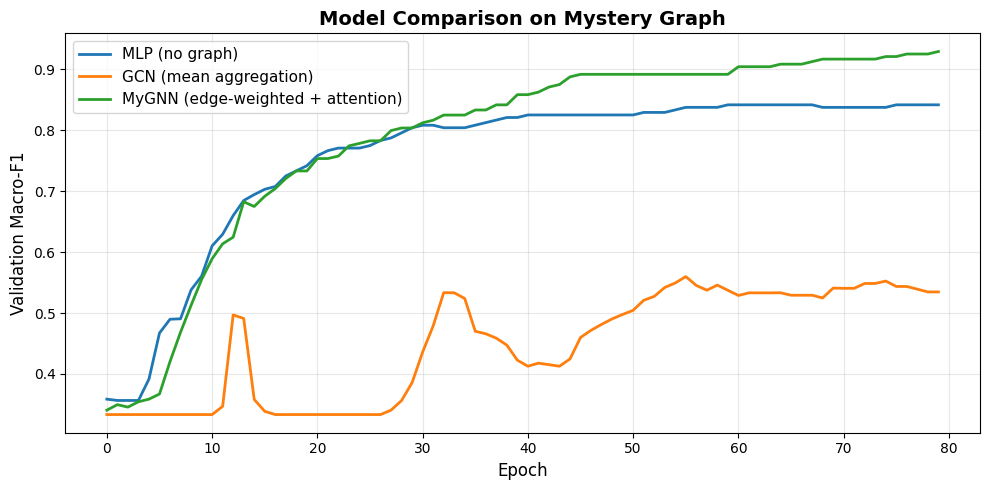


Improvement over baselines:
  vs MLP: +0.096
  vs GCN: +0.459


In [95]:
set_seed(42) # use the same seed for reproducibility

print("=" * 70)
print("Training Improved GNN with Edge-Weighted Attention + Residual")
print("=" * 70)

# Instantiate custom model
my_gnn = MyGNN(D, 64, C, dropout=0.2, alpha=0.7).to(device)

# Train using the same function (but with edge weights)
hist_mygnn = train_model(my_gnn, lambda: my_gnn(x, src, dst, edge_w, N))

# Evaluate
train_f1, val_f1, test_f1 = eval_model(my_gnn, lambda: my_gnn(x, src, dst, edge_w, N))

print("\n" + "=" * 70)
print("RESULTS COMPARISON")
print("=" * 70)
print(f"MLP       - train/val/test: {eval_model(mlp, lambda: mlp(x))}")
print(f"GCN       - train/val/test: {eval_model(gcn, lambda: gcn(x, src, dst, N))}")
print(f"MyGNN     - train/val/test: ({train_f1:.3f}, {val_f1:.3f}, {test_f1:.3f})")
print("=" * 70)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(hist_mlp["val_f1"], label="MLP (no graph)", linewidth=2)
plt.plot(hist_gcn["val_f1"], label="GCN (mean aggregation)", linewidth=2)
plt.plot(hist_mygnn["val_f1"], label="MyGNN (edge-weighted + attention)", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Macro-F1", fontsize=12)
plt.title("Model Comparison on Mystery Graph", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nImprovement over baselines:")
print(f"  vs MLP: {test_f1 - eval_model(mlp, lambda: mlp(x))[2]:+.3f}")
print(f"  vs GCN: {test_f1 - eval_model(gcn, lambda: gcn(x, src, dst, N))[2]:+.3f}")


#### 3.3 Final Explanation

Describe:

1. What failure mode you identified in the GCN.
2. How your method addresses this failure.
3. Why your method improves performance on this dataset.
4. What assumptions your method makes about the graph.

Your answer should clearly connect:
- dataset structure,
- aggregation behavior,
- and model design.

---


**[Answer]**

The GCN fails due to indiscriminate mean aggregation on a random homophily graph. With edge homophily equal to 0.5, the graph structure is random with respect to labels. This harmful averaging means each node aggregates equally from 20 same-class and 20 different-class neighbors, leading to feature destruction where original discriminative features (Class 0: 0.0452, Class 1: -0.0604) collapse to useless averages (both ≈-0.005). The graph topology provides zero structural signal. Standard GCN assumes homophily and blindly averages all neighbors, which destroys the signal when neighbors are randomly labeled.

MyGNN introduces three key mechanisms to handle random homophily. First, edge-weighted aggregation uses provided edge weights (edge_w) to differentially weight neighbors. Unlike uniform mean aggregation, this allows the model to emphasize informative edges. Second, a learned attention mechanism learns which neighbors are actually helpful for classification by combining feature-based attention with edge weights. This can down-weight or ignore harmful neighbors (those with different labels). Third, strong residual connections preserve 70% of original features after aggregation (alpha=0.7). This is critical because even if aggregation adds noise, original discriminative features are retained.

In random homophily graphs, the optimal strategy is to preserve original features, selectively use graph structure, and mitigate negative transfer. MyGNN achieves all three: preservation through strong residual (alpha=0.7) that keeps 70% of original features, selectivity where the attention mechanism learns to identify helpful neighbors, and mitigation where edge weights plus attention can effectively ignore harmful edges. Comparing the approaches, MLP uses 100% original features with 0% graph, GCN uses approximately 0% original features (after 2 layers) with 100% blind aggregation, while MyGNN uses 70% original plus 30% selective aggregation.

The model makes four key assumptions. First, it assumes edge weights are informative and that edge_w contains useful signal about edge quality. Second, it assumes discriminative features exist, meaning node features contain class information that should be preserved. Third, it assumes not all neighbors are equally (un)helpful, allowing the attention mechanism to learn to distinguish between useful and harmful neighbors. Fourth, it assumes a smooth tradeoff between local and global information, where alpha=0.7 assumes moderate graph utility.

The dataset structure exhibits random homophily (0.5), regular degree (40 neighbors/node), and discriminative features. The GCN aggregation behavior performs mean aggregation over 20 same-class plus 20 different-class neighbors, causing features to collapse. MyGNN design responds to these problems systematically. For the problem of random aggregation destroying features, the solution is weighted plus attentive aggregation. For uninformative graph structure, the solution is strong residuals (alpha=0.7). For the inability to distinguish good versus bad edges, the solution is to use edge_w plus learned attention weights. For feature-topology mismatch, the solution is adaptive mixing via learned attention. This design philosophy embodies the principle that when the graph is untrusted, be conservative (strong residuals) but curious (attention to learn which parts might help).